# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


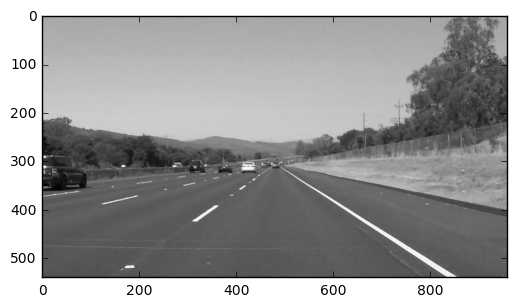

In [10]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [40]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    print("draw:", lines)
    for line in lines:
        print("111", line)
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [85]:
import os
image_files = os.listdir("test_images/")
if not os.path.exists("result_images"):
    os.makedirs("result_images")

def find_lane_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    slope_left = 0
    r_left = 0
    lines_left = []
    slope_right = 0
    r_right = 0
    lines_right = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:
                continue
            else:
                slope = (y1-y2)/(x1-x2)
                if slope == 0: # can't be horizontal line
                    continue
                r = math.atan(slope)
                if slope < 0: # left lane
                    if slope_left == 0: # first one
                        r_left = r
                        slope_left = slope
                        lines_left.append(line)
                    else:
                        if abs(r - r_left) < 0.05: # same line
                            lines_left.append(line)
                        elif r < r_left: # more appropriate one
                            r_left = r
                            slope_left = slope
                            lines_left = []
                            lines_left.append(line)
                elif slope > 0: # right lane
                    if slope_right == 0: # first one
                        r_right = r
                        slope_right = slope
                        lines_right.append(line)
                    else:
                        if abs(r - r_right) < 0.05: # same line
                            lines_right.append(line)
                        elif r > r_right: # more appropriate one
                            r_right = r
                            slope_right = slope
                            lines_right = []
                            lines_right.append(line)
    imshape = image.shape
    print("lines_left:", lines_left)
    print("lines_right:", lines_right)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    
    if lines_left:
        lines_left_x = []
        lines_left_y = []
        for line in lines_left:
            for x1,y1,x2,y2 in line:
                lines_left_x.append(x1)
                lines_left_x.append(x2)
                lines_left_y.append(y1)
                lines_left_y.append(y2)
                
        print("lines_left_x:", lines_left_x)        
        line_left_z = np.polyfit(lines_left_x, lines_left_y, 1)
        left_start_x = (imshape[0] - line_left_z[1])/line_left_z[0]
        left_end_x = (imshape[0]*2/3 - line_left_z[1])/line_left_z[0]    
        cv2.line(line_img, (int(left_start_x), imshape[0]), (int(left_end_x), imshape[0]*2//3), [255, 0, 0], 5)
            
    if lines_right:
        lines_right_x = []
        lines_right_y = []
        for line in lines_right:
            for x1,y1,x2,y2 in line:
                lines_right_x.append(x1)
                lines_right_x.append(x2)
                lines_right_y.append(y1)
                lines_right_y.append(y2)

        line_right_z = np.polyfit(lines_right_x, lines_right_y, 1)
        right_start_x = (imshape[0] - line_right_z[1])/line_right_z[0]
        right_end_x = (imshape[0]*2/3 - line_right_z[1])/line_right_z[0]       
        cv2.line(line_img, (int(right_start_x), imshape[0]), (int(right_end_x), imshape[0]*2//3), [255, 0, 0], 5)
    return line_img

for image_file in image_files:
    image = mpimg.imread("test_images/" + image_file)
    print('This image is:', type(image), 'with dimensions:', image.shape)
#    plt.imshow(image)
    gray = grayscale(image)
#    plt.imshow(gray, cmap='gray')
    blur_gray = gaussian_blur(gray, 7)
#    plt.imshow(blur_gray, cmap='gray')
    edges = canny(blur_gray, 50, 200)
#    plt.imshow(edges, cmap='gray')
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]),(imshape[1]/2, imshape[0]/3), (imshape[1],imshape[0])]], dtype=np.int32)
    masked = region_of_interest(edges, vertices)
#    plt.imshow(masked, cmap='gray')
    line_img = find_lane_lines(masked, 2, np.pi/180, 15, 100, 50)
#    plt.imshow(line_img)
    print('This line_img is:', type(line_img), 'with dimensions:', line_img.shape)
    result = weighted_img(line_img, image)
#    plt.imshow(result)
    mpimg.imsave("result_images/" + image_file, result)


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
lines_left: [array([[426, 345, 544, 231]], dtype=int32)]
lines_right: [array([[670, 424, 781, 490]], dtype=int32), array([[661, 425, 770, 493]], dtype=int32), array([[673, 424, 784, 491]], dtype=int32), array([[660, 426, 767, 493]], dtype=int32)]
lines_left_x: [426, 544]
This line_img is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
lines_left: [array([[342, 407, 477, 309]], dtype=int32), array([[219, 507, 477, 312]], dtype=int32), array([[180, 537, 324, 428]], dtype=int32)]
lines_right: [array([[712, 445, 874, 538]], dtype=int32), array([[700, 447, 852, 538]], dtype=int32), array([[701, 448, 851, 538]], dtype=int32)]
lines_left_x: [342, 477, 219, 477, 180, 324]
This line_img is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
lines_left: [array([[406, 366, 535, 

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [86]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [87]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 7)
    edges = canny(blur_gray, 50, 200)
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]),(imshape[1]/2, imshape[0]/3), (imshape[1],imshape[0])]], dtype=np.int32)
    masked = region_of_interest(edges, vertices)
    line_img = find_lane_lines(masked, 2, np.pi/180, 30, 100, 50)
    result = weighted_img(line_img, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [88]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

lines_left: [array([[203, 514, 311, 433]], dtype=int32), array([[187, 512, 304, 430]], dtype=int32), array([[202, 514, 310, 433]], dtype=int32), array([[361, 391, 478, 309]], dtype=int32), array([[358, 388, 473, 308]], dtype=int32)]
lines_right: [array([[494, 312, 870, 538]], dtype=int32), array([[634, 403, 748, 475]], dtype=int32), array([[710, 452, 847, 538]], dtype=int32), array([[480, 309, 633, 401]], dtype=int32), array([[482, 309, 587, 372]], dtype=int32), array([[624, 389, 784, 488]], dtype=int32)]
lines_left_x: [203, 311, 187, 304, 202, 310, 361, 478, 358, 473]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4








  0%|          | 0/222 [00:00<?, ?it/s]





  2%|▏         | 5/222 [00:00<00:04, 45.61it/s]

lines_left: [array([[203, 514, 311, 433]], dtype=int32), array([[187, 512, 304, 430]], dtype=int32), array([[202, 514, 310, 433]], dtype=int32), array([[361, 391, 478, 309]], dtype=int32), array([[358, 388, 473, 308]], dtype=int32)]
lines_right: [array([[494, 312, 870, 538]], dtype=int32), array([[634, 403, 748, 475]], dtype=int32), array([[710, 452, 847, 538]], dtype=int32), array([[480, 309, 633, 401]], dtype=int32), array([[482, 309, 587, 372]], dtype=int32), array([[624, 389, 784, 488]], dtype=int32)]
lines_left_x: [203, 311, 187, 304, 202, 310, 361, 478, 358, 473]
lines_left: [array([[171, 538, 289, 449]], dtype=int32), array([[151, 539, 279, 446]], dtype=int32), array([[348, 396, 474, 308]], dtype=int32), array([[352, 399, 460, 320]], dtype=int32), array([[347, 396, 472, 308]], dtype=int32), array([[349, 398, 450, 327]], dtype=int32)]
lines_right: [array([[675, 422, 868, 538]], dtype=int32), array([[483, 309, 720, 457]], dtype=int32), array([[707, 450, 845, 537]], dtype=int32), a

lines_left: [array([[310, 422, 437, 333]], dtype=int32), array([[316, 425, 476, 309]], dtype=int32)]
lines_right: [array([[511, 322, 870, 538]], dtype=int32), array([[457, 293, 849, 538]], dtype=int32), array([[611, 390, 760, 483]], dtype=int32)]
lines_left_x: [310, 437, 316, 476]








  5%|▍         | 10/222 [00:00<00:04, 43.51it/s]





  7%|▋         | 15/222 [00:00<00:04, 44.41it/s]

lines_left: [array([[300, 440, 412, 352]], dtype=int32)]
lines_right: [array([[590, 373, 865, 539]], dtype=int32), array([[603, 387, 844, 538]], dtype=int32), array([[514, 326, 866, 538]], dtype=int32), array([[454, 295, 576, 368]], dtype=int32), array([[686, 438, 815, 521]], dtype=int32)]
lines_left_x: [300, 412]
lines_left: [array([[309, 318, 482, 293]], dtype=int32)]
lines_right: [array([[562, 358, 859, 537]], dtype=int32), array([[478, 308, 688, 444]], dtype=int32), array([[716, 460, 837, 538]], dtype=int32), array([[472, 296, 584, 371]], dtype=int32), array([[589, 374, 702, 444]], dtype=int32)]
lines_left_x: [309, 482]
lines_left: [array([[372, 318, 477, 296]], dtype=int32)]
lines_right: [array([[396, 256, 771, 499]], dtype=int32), array([[519, 332, 700, 445]], dtype=int32), array([[744, 470, 855, 539]], dtype=int32), array([[397, 256, 733, 465]], dtype=int32), array([[655, 425, 833, 537]], dtype=int32), array([[394, 256, 563, 358]], dtype=int32), array([[493, 318, 778, 503]], dty







  9%|▉         | 20/222 [00:00<00:04, 44.57it/s]





 12%|█▏        | 26/222 [00:00<00:04, 46.44it/s]

lines_left: [array([[339, 400, 480, 309]], dtype=int32), array([[345, 402, 479, 308]], dtype=int32), array([[339, 399, 439, 332]], dtype=int32)]
lines_right: [array([[398, 251, 606, 381]], dtype=int32), array([[395, 251, 738, 474]], dtype=int32), array([[740, 465, 855, 539]], dtype=int32), array([[487, 309, 593, 373]], dtype=int32), array([[438, 286, 646, 407]], dtype=int32), array([[439, 284, 551, 351]], dtype=int32), array([[594, 379, 700, 450]], dtype=int32)]
lines_left_x: [339, 480, 345, 479, 339, 439]
lines_left: [array([[326, 411, 473, 308]], dtype=int32), array([[334, 412, 475, 310]], dtype=int32), array([[328, 413, 481, 310]], dtype=int32)]
lines_right: [array([[450, 287, 734, 472]], dtype=int32), array([[397, 253, 854, 538]], dtype=int32), array([[695, 448, 833, 538]], dtype=int32), array([[399, 253, 855, 538]], dtype=int32), array([[395, 252, 666, 428]], dtype=int32)]
lines_left_x: [326, 473, 334, 475, 328, 481]
lines_left: [array([[315, 425, 478, 311]], dtype=int32), array([







 14%|█▍        | 31/222 [00:00<00:04, 45.67it/s]

lines_left: [array([[307, 428, 473, 307]], dtype=int32), array([[314, 428, 490, 301]], dtype=int32), array([[308, 428, 441, 332]], dtype=int32)]
lines_right: [array([[396, 252, 705, 453]], dtype=int32), array([[443, 281, 855, 539]], dtype=int32), array([[677, 436, 834, 538]], dtype=int32), array([[610, 385, 856, 538]], dtype=int32), array([[489, 306, 593, 381]], dtype=int32), array([[705, 454, 833, 537]], dtype=int32), array([[390, 252, 543, 348]], dtype=int32)]
lines_left_x: [307, 473, 314, 490, 308, 441]
lines_left: [array([[362, 394, 475, 309]], dtype=int32), array([[353, 395, 478, 304]], dtype=int32), array([[352, 395, 478, 303]], dtype=int32), array([[354, 396, 485, 304]], dtype=int32), array([[357, 396, 474, 311]], dtype=int32)]
lines_right: [array([[458, 293, 834, 537]], dtype=int32), array([[461, 292, 856, 539]], dtype=int32), array([[619, 390, 856, 538]], dtype=int32), array([[464, 292, 592, 375]], dtype=int32), array([[606, 388, 717, 462]], dtype=int32)]
lines_left_x: [362, 4







 17%|█▋        | 37/222 [00:00<00:03, 47.61it/s]

lines_left: [array([[228, 494, 403, 358]], dtype=int32), array([[200, 501, 301, 430]], dtype=int32)]
lines_right: [array([[541, 343, 854, 539]], dtype=int32), array([[555, 357, 833, 538]], dtype=int32), array([[571, 363, 779, 493]], dtype=int32), array([[397, 253, 555, 356]], dtype=int32), array([[399, 253, 548, 346]], dtype=int32), array([[392, 253, 555, 351]], dtype=int32), array([[388, 252, 570, 366]], dtype=int32)]
lines_left_x: [228, 403, 200, 301]
lines_left: [array([[167, 538, 291, 445]], dtype=int32), array([[147, 539, 281, 445]], dtype=int32), array([[146, 538, 278, 446]], dtype=int32), array([[353, 399, 479, 304]], dtype=int32), array([[355, 399, 480, 305]], dtype=int32), array([[358, 396, 475, 308]], dtype=int32)]
lines_right: [array([[554, 351, 854, 539]], dtype=int32), array([[653, 422, 832, 539]], dtype=int32), array([[584, 371, 805, 509]], dtype=int32), array([[477, 306, 648, 417]], dtype=int32), array([[732, 473, 832, 538]], dtype=int32)]
lines_left_x: [167, 291, 147, 2







 19%|█▉        | 42/222 [00:00<00:03, 48.08it/s]

lines_left: [array([[325, 413, 476, 308]], dtype=int32), array([[323, 413, 477, 305]], dtype=int32), array([[325, 412, 478, 305]], dtype=int32)]
lines_right: [array([[561, 354, 855, 538]], dtype=int32), array([[462, 291, 753, 487]], dtype=int32), array([[467, 291, 597, 378]], dtype=int32), array([[479, 304, 641, 413]], dtype=int32), array([[634, 408, 771, 497]], dtype=int32)]
lines_left_x: [325, 476, 323, 477, 325, 478]
lines_left: [array([[314, 426, 488, 300]], dtype=int32), array([[364, 386, 488, 299]], dtype=int32)]
lines_right: [array([[601, 380, 854, 538]], dtype=int32), array([[630, 405, 834, 538]], dtype=int32), array([[459, 291, 607, 388]], dtype=int32), array([[462, 291, 591, 372]], dtype=int32), array([[476, 304, 627, 395]], dtype=int32), array([[699, 449, 833, 539]], dtype=int32)]
lines_left_x: [314, 488, 364, 488]
lines_left: [array([[371, 386, 476, 304]], dtype=int32), array([[358, 394, 478, 304]], dtype=int32)]
lines_right: [array([[580, 366, 854, 538]], dtype=int32), arr

lines_left: [array([[305, 433, 476, 304]], dtype=int32)]
lines_right: [array([[480, 303, 734, 474]], dtype=int32), array([[486, 304, 712, 450]], dtype=int32), array([[617, 388, 763, 482]], dtype=int32), array([[539, 342, 728, 469]], dtype=int32)]
lines_left_x: [305, 476]
lines_left: [array([[321, 309, 486, 301]], dtype=int32), array([[320, 308, 498, 298]], dtype=int32)]
lines_right: [array([[480, 303, 757, 489]], dtype=int32), array([[484, 302, 727, 459]], dtype=int32), array([[644, 405, 754, 476]], dtype=int32), array([[487, 308, 671, 432]], dtype=int32), array([[708, 455, 808, 522]], dtype=int32)]
lines_left_x: [321, 486, 320, 498]








 21%|██        | 47/222 [00:01<00:04, 39.51it/s]

lines_left: [array([[310, 429, 442, 319]], dtype=int32), array([[254, 471, 476, 304]], dtype=int32)]
lines_right: [array([[480, 303, 831, 539]], dtype=int32), array([[627, 396, 854, 538]], dtype=int32), array([[495, 311, 606, 381]], dtype=int32), array([[488, 309, 714, 461]], dtype=int32)]
lines_left_x: [310, 442, 254, 476]
lines_left: [array([[215, 500, 400, 356]], dtype=int32), array([[239, 482, 402, 355]], dtype=int32)]
lines_right: [array([[544, 346, 830, 539]], dtype=int32), array([[631, 399, 853, 538]], dtype=int32), array([[461, 291, 772, 500]], dtype=int32), array([[463, 291, 565, 355]], dtype=int32)]
lines_left_x: [215, 400, 239, 402]
lines_left: [array([[141, 538, 283, 439]], dtype=int32), array([[162, 538, 289, 443]], dtype=int32), array([[161, 538, 292, 439]], dtype=int32), array([[140, 538, 280, 440]], dtype=int32)]
lines_right: [array([[466, 291, 763, 483]], dtype=int32), array([[544, 346, 830, 538]], dtype=int32), array([[461, 291, 767, 497]], dtype=int32), array([[715, 







 23%|██▎       | 52/222 [00:01<00:04, 35.86it/s]

lines_left: [array([[321, 410, 439, 328]], dtype=int32), array([[323, 412, 481, 306]], dtype=int32), array([[329, 412, 478, 304]], dtype=int32), array([[322, 409, 441, 329]], dtype=int32)]
lines_right: [array([[555, 353, 830, 538]], dtype=int32), array([[580, 366, 806, 508]], dtype=int32), array([[481, 304, 697, 439]], dtype=int32), array([[495, 314, 720, 465]], dtype=int32)]
lines_left_x: [321, 439, 323, 481, 329, 478, 322, 441]
lines_left: [array([[359, 383, 475, 305]], dtype=int32), array([[305, 423, 474, 309]], dtype=int32), array([[307, 424, 472, 312]], dtype=int32), array([[359, 384, 476, 305]], dtype=int32)]
lines_right: [array([[539, 343, 830, 539]], dtype=int32), array([[707, 447, 852, 538]], dtype=int32), array([[481, 304, 719, 453]], dtype=int32), array([[502, 319, 702, 453]], dtype=int32), array([[592, 374, 852, 537]], dtype=int32)]
lines_left_x: [359, 475, 305, 474, 307, 472, 359, 476]
lines_left: [array([[353, 393, 475, 305]], dtype=int32)]
lines_right: [array([[543, 346,







 25%|██▌       | 56/222 [00:01<00:04, 35.60it/s]

lines_left: [array([[346, 399, 468, 310]], dtype=int32), array([[341, 401, 472, 313]], dtype=int32)]
lines_right: [array([[549, 350, 830, 539]], dtype=int32), array([[717, 453, 853, 538]], dtype=int32), array([[482, 304, 606, 382]], dtype=int32), array([[542, 346, 654, 421]], dtype=int32)]
lines_left_x: [346, 468, 341, 472]
lines_left: [array([[332, 410, 475, 310]], dtype=int32), array([[343, 396, 470, 311]], dtype=int32), array([[329, 411, 432, 337]], dtype=int32)]
lines_right: [array([[511, 324, 851, 537]], dtype=int32), array([[485, 310, 623, 400]], dtype=int32), array([[597, 384, 768, 496]], dtype=int32), array([[577, 369, 829, 538]], dtype=int32)]
lines_left_x: [332, 475, 343, 470, 329, 432]
lines_left: [array([[307, 421, 472, 309]], dtype=int32), array([[313, 423, 474, 310]], dtype=int32), array([[331, 405, 436, 335]], dtype=int32)]
lines_right: [array([[397, 254, 850, 537]], dtype=int32), array([[394, 253, 714, 461]], dtype=int32), array([[639, 406, 851, 539]], dtype=int32), arr







 27%|██▋       | 60/222 [00:01<00:06, 26.17it/s]

lines_left: [array([[437, 325, 618, 283]], dtype=int32)]
lines_right: [array([[551, 354, 826, 539]], dtype=int32), array([[465, 293, 769, 490]], dtype=int32), array([[463, 293, 706, 450]], dtype=int32), array([[597, 384, 826, 538]], dtype=int32)]
lines_left_x: [437, 618]
lines_left: [array([[196, 507, 302, 430]], dtype=int32), array([[182, 505, 295, 429]], dtype=int32), array([[359, 390, 477, 311]], dtype=int32)]
lines_right: [array([[479, 307, 823, 539]], dtype=int32), array([[559, 355, 802, 512]], dtype=int32), array([[543, 345, 646, 419]], dtype=int32), array([[600, 387, 824, 538]], dtype=int32), array([[622, 396, 722, 461]], dtype=int32)]
lines_left_x: [196, 302, 182, 295, 359, 477]
lines_left: [array([[132, 539, 272, 444]], dtype=int32), array([[152, 539, 280, 446]], dtype=int32), array([[152, 538, 281, 444]], dtype=int32), array([[343, 394, 473, 310]], dtype=int32), array([[349, 397, 491, 301]], dtype=int32), array([[344, 396, 480, 308]], dtype=int32)]
lines_right: [array([[480, 







 29%|██▉       | 64/222 [00:01<00:07, 21.97it/s]

lines_left: [array([[133, 537, 245, 464]], dtype=int32), array([[151, 538, 251, 468]], dtype=int32), array([[152, 537, 252, 467]], dtype=int32), array([[331, 402, 472, 311]], dtype=int32), array([[333, 402, 473, 308]], dtype=int32)]
lines_right: [array([[552, 356, 823, 538]], dtype=int32), array([[493, 313, 638, 407]], dtype=int32), array([[624, 397, 843, 539]], dtype=int32), array([[480, 308, 621, 403]], dtype=int32)]
lines_left_x: [133, 245, 151, 251, 152, 252, 331, 472, 333, 473]
lines_left: [array([[319, 415, 490, 304]], dtype=int32), array([[317, 414, 476, 307]], dtype=int32), array([[324, 414, 486, 301]], dtype=int32)]
lines_right: [array([[492, 313, 645, 412]], dtype=int32), array([[479, 307, 822, 538]], dtype=int32), array([[657, 418, 843, 538]], dtype=int32), array([[478, 307, 616, 400]], dtype=int32), array([[495, 314, 616, 393]], dtype=int32)]
lines_left_x: [319, 490, 317, 476, 324, 486]
lines_left: [array([[303, 426, 492, 303]], dtype=int32), array([[359, 385, 491, 300]], d







 30%|███       | 67/222 [00:02<00:07, 21.03it/s]





 32%|███▏      | 70/222 [00:02<00:07, 20.39it/s]

lines_left: [array([[332, 408, 479, 305]], dtype=int32), array([[324, 406, 473, 306]], dtype=int32), array([[328, 409, 480, 307]], dtype=int32), array([[322, 407, 480, 305]], dtype=int32)]
lines_right: [array([[478, 305, 824, 538]], dtype=int32), array([[602, 382, 782, 498]], dtype=int32), array([[496, 314, 707, 451]], dtype=int32), array([[713, 463, 825, 538]], dtype=int32), array([[497, 314, 742, 473]], dtype=int32)]
lines_left_x: [332, 479, 324, 473, 328, 480, 322, 480]
lines_left: [array([[306, 420, 475, 306]], dtype=int32), array([[318, 418, 479, 305]], dtype=int32), array([[311, 415, 435, 334]], dtype=int32)]
lines_right: [array([[481, 309, 768, 502]], dtype=int32), array([[482, 305, 755, 482]], dtype=int32), array([[606, 385, 803, 512]], dtype=int32), array([[478, 305, 824, 538]], dtype=int32)]
lines_left_x: [306, 475, 318, 479, 311, 435]
lines_left: [array([[329, 309, 430, 300]], dtype=int32)]
lines_right: [array([[476, 305, 822, 538]], dtype=int32), array([[481, 305, 801, 512]







 33%|███▎      | 73/222 [00:02<00:08, 18.22it/s]

lines_left: [array([[481, 314, 602, 284]], dtype=int32)]
lines_right: [array([[481, 309, 821, 538]], dtype=int32), array([[626, 398, 843, 539]], dtype=int32), array([[493, 312, 795, 508]], dtype=int32), array([[490, 313, 821, 537]], dtype=int32), array([[499, 315, 600, 383]], dtype=int32)]
lines_left_x: [481, 602]
lines_left: [array([[202, 498, 395, 358]], dtype=int32), array([[198, 499, 304, 428]], dtype=int32), array([[353, 387, 478, 305]], dtype=int32), array([[357, 389, 480, 306]], dtype=int32)]
lines_right: [array([[481, 305, 842, 539]], dtype=int32), array([[475, 306, 626, 407]], dtype=int32), array([[477, 305, 792, 518]], dtype=int32), array([[644, 410, 842, 538]], dtype=int32), array([[479, 307, 821, 538]], dtype=int32), array([[497, 314, 599, 383]], dtype=int32)]
lines_left_x: [202, 395, 198, 304, 353, 478, 357, 480]
lines_left: [array([[348, 396, 477, 306]], dtype=int32), array([[128, 535, 274, 440]], dtype=int32), array([[142, 538, 281, 444]], dtype=int32), array([[346, 396,







 34%|███▍      | 76/222 [00:02<00:07, 20.17it/s]

lines_left: [array([[321, 412, 473, 306]], dtype=int32), array([[316, 409, 476, 305]], dtype=int32), array([[317, 411, 488, 300]], dtype=int32), array([[388, 366, 494, 297]], dtype=int32)]
lines_right: [array([[519, 330, 840, 539]], dtype=int32), array([[648, 423, 818, 538]], dtype=int32), array([[456, 291, 576, 372]], dtype=int32), array([[597, 388, 819, 538]], dtype=int32), array([[485, 314, 592, 383]], dtype=int32), array([[722, 461, 841, 538]], dtype=int32), array([[474, 306, 589, 381]], dtype=int32), array([[463, 291, 646, 414]], dtype=int32)]
lines_left_x: [321, 473, 316, 476, 317, 488, 388, 494]
lines_left: [array([[305, 423, 489, 299]], dtype=int32), array([[355, 384, 477, 304]], dtype=int32), array([[304, 423, 471, 306]], dtype=int32), array([[359, 386, 486, 300]], dtype=int32), array([[301, 423, 419, 341]], dtype=int32)]
lines_right: [array([[478, 304, 839, 539]], dtype=int32), array([[604, 393, 819, 538]], dtype=int32), array([[455, 291, 647, 421]], dtype=int32), array([[665







 36%|███▌      | 79/222 [00:02<00:08, 17.11it/s]





 37%|███▋      | 82/222 [00:02<00:07, 18.68it/s]

lines_left: [array([[325, 409, 487, 300]], dtype=int32), array([[320, 408, 471, 306]], dtype=int32), array([[320, 409, 436, 333]], dtype=int32)]
lines_right: [array([[395, 252, 834, 537]], dtype=int32), array([[405, 254, 813, 539]], dtype=int32), array([[701, 460, 813, 538]], dtype=int32), array([[402, 253, 523, 332]], dtype=int32), array([[391, 251, 519, 334]], dtype=int32), array([[662, 426, 834, 538]], dtype=int32), array([[388, 251, 569, 369]], dtype=int32), array([[389, 251, 585, 374]], dtype=int32)]
lines_left_x: [325, 487, 320, 471, 320, 436]
lines_left: [array([[313, 418, 490, 299]], dtype=int32), array([[303, 419, 472, 305]], dtype=int32), array([[310, 419, 486, 300]], dtype=int32), array([[304, 416, 479, 307]], dtype=int32), array([[350, 388, 468, 312]], dtype=int32)]
lines_right: [array([[476, 304, 742, 490]], dtype=int32), array([[491, 311, 692, 446]], dtype=int32), array([[638, 416, 813, 538]], dtype=int32), array([[478, 305, 606, 389]], dtype=int32)]
lines_left_x: [313, 4







 38%|███▊      | 85/222 [00:02<00:06, 20.89it/s]





 40%|███▉      | 88/222 [00:03<00:07, 18.37it/s]

lines_left: [array([[140, 536, 281, 441]], dtype=int32), array([[133, 526, 274, 438]], dtype=int32), array([[121, 534, 275, 438]], dtype=int32), array([[342, 395, 487, 301]], dtype=int32), array([[341, 395, 475, 305]], dtype=int32), array([[380, 372, 493, 299]], dtype=int32)]
lines_right: [array([[458, 291, 811, 538]], dtype=int32), array([[689, 443, 832, 539]], dtype=int32), array([[460, 291, 694, 448]], dtype=int32), array([[507, 324, 629, 412]], dtype=int32), array([[524, 333, 675, 435]], dtype=int32)]
lines_left_x: [140, 281, 133, 274, 121, 275, 342, 487, 341, 475, 380, 493]
lines_left: [array([[117, 539, 244, 457]], dtype=int32), array([[331, 403, 437, 329]], dtype=int32), array([[136, 538, 254, 458]], dtype=int32), array([[338, 403, 478, 305]], dtype=int32), array([[327, 401, 475, 305]], dtype=int32), array([[335, 403, 441, 329]], dtype=int32)]
lines_right: [array([[456, 291, 809, 538]], dtype=int32), array([[462, 291, 768, 497]], dtype=int32), array([[535, 341, 679, 438]], dtype







 41%|████      | 91/222 [00:03<00:07, 17.24it/s]

lines_left: [array([[355, 384, 476, 306]], dtype=int32), array([[304, 424, 479, 306]], dtype=int32), array([[302, 424, 460, 314]], dtype=int32), array([[358, 387, 491, 301]], dtype=int32)]
lines_right: [array([[404, 254, 809, 538]], dtype=int32), array([[461, 291, 767, 497]], dtype=int32), array([[674, 434, 830, 539]], dtype=int32), array([[556, 361, 808, 538]], dtype=int32), array([[414, 256, 628, 405]], dtype=int32), array([[501, 320, 656, 424]], dtype=int32)]
lines_left_x: [355, 476, 304, 479, 302, 460, 358, 491]
lines_left: [array([[345, 391, 484, 301]], dtype=int32), array([[350, 393, 477, 310]], dtype=int32), array([[346, 391, 471, 313]], dtype=int32)]
lines_right: [array([[405, 254, 653, 428]], dtype=int32), array([[561, 359, 705, 456]], dtype=int32), array([[462, 291, 830, 539]], dtype=int32), array([[476, 301, 600, 391]], dtype=int32)]
lines_left_x: [345, 484, 350, 477, 346, 471]
lines_left: [array([[344, 400, 476, 304]], dtype=int32)]
lines_right: [array([[574, 374, 808, 538]







 43%|████▎     | 95/222 [00:03<00:06, 18.19it/s]

lines_left: [array([[316, 419, 492, 301]], dtype=int32), array([[305, 419, 479, 306]], dtype=int32), array([[309, 421, 416, 351]], dtype=int32)]
lines_right: [array([[560, 358, 828, 539]], dtype=int32), array([[488, 309, 717, 475]], dtype=int32), array([[717, 463, 829, 538]], dtype=int32), array([[653, 428, 789, 526]], dtype=int32), array([[491, 306, 626, 404]], dtype=int32), array([[478, 306, 581, 371]], dtype=int32)]
lines_left_x: [316, 492, 305, 479, 309, 416]
lines_left: [array([[400, 322, 504, 302]], dtype=int32), array([[380, 317, 499, 300]], dtype=int32)]
lines_right: [array([[555, 354, 828, 538]], dtype=int32), array([[555, 359, 768, 509]], dtype=int32), array([[616, 403, 808, 538]], dtype=int32), array([[710, 458, 829, 538]], dtype=int32), array([[408, 255, 607, 395]], dtype=int32), array([[458, 291, 589, 376]], dtype=int32), array([[593, 379, 697, 451]], dtype=int32)]
lines_left_x: [400, 504, 380, 499]
lines_left: [array([[395, 362, 495, 300]], dtype=int32)]
lines_right: [arr







 44%|████▎     | 97/222 [00:03<00:07, 17.68it/s]





 45%|████▍     | 99/222 [00:03<00:06, 17.81it/s]

lines_left: [array([[202, 495, 431, 335]], dtype=int32), array([[190, 494, 293, 425]], dtype=int32), array([[359, 388, 477, 309]], dtype=int32), array([[362, 385, 495, 292]], dtype=int32), array([[433, 322, 534, 249]], dtype=int32)]
lines_right: [array([[634, 413, 812, 538]], dtype=int32), array([[405, 252, 541, 344]], dtype=int32), array([[419, 255, 720, 465]], dtype=int32), array([[723, 467, 832, 538]], dtype=int32), array([[403, 252, 561, 359]], dtype=int32), array([[501, 313, 630, 403]], dtype=int32), array([[638, 415, 760, 503]], dtype=int32)]
lines_left_x: [202, 431, 190, 293, 359, 477, 362, 495, 433, 534]
lines_left: [array([[132, 531, 278, 436]], dtype=int32), array([[146, 532, 284, 439]], dtype=int32), array([[147, 532, 285, 439]], dtype=int32), array([[133, 529, 274, 437]], dtype=int32), array([[381, 368, 496, 299]], dtype=int32), array([[148, 532, 286, 439]], dtype=int32)]
lines_right: [array([[618, 399, 811, 539]], dtype=int32), array([[631, 403, 831, 538]], dtype=int32), a







 46%|████▌     | 102/222 [00:03<00:06, 18.78it/s]





 47%|████▋     | 105/222 [00:04<00:05, 19.65it/s]

lines_left: [array([[351, 391, 485, 304]], dtype=int32), array([[353, 393, 484, 305]], dtype=int32), array([[351, 390, 476, 306]], dtype=int32)]
lines_right: [array([[567, 359, 832, 538]], dtype=int32), array([[420, 256, 725, 477]], dtype=int32), array([[650, 422, 811, 539]], dtype=int32), array([[417, 255, 617, 400]], dtype=int32), array([[407, 253, 561, 353]], dtype=int32), array([[446, 284, 592, 375]], dtype=int32)]
lines_left_x: [351, 485, 353, 484, 351, 476]
lines_left: [array([[357, 394, 480, 305]], dtype=int32), array([[370, 379, 478, 306]], dtype=int32)]
lines_right: [array([[481, 305, 782, 516]], dtype=int32), array([[498, 313, 832, 538]], dtype=int32), array([[483, 305, 648, 421]], dtype=int32)]
lines_left_x: [357, 480, 370, 478]
lines_left: [array([[327, 408, 484, 306]], dtype=int32), array([[332, 410, 478, 312]], dtype=int32)]
lines_right: [array([[578, 373, 813, 538]], dtype=int32), array([[468, 292, 833, 538]], dtype=int32), array([[413, 256, 830, 537]], dtype=int32), arr







 49%|████▊     | 108/222 [00:04<00:05, 20.00it/s]

lines_left: [array([[392, 312, 505, 304]], dtype=int32), array([[310, 311, 514, 300]], dtype=int32), array([[399, 310, 513, 298]], dtype=int32)]
lines_right: [array([[590, 379, 817, 538]], dtype=int32), array([[654, 417, 805, 516]], dtype=int32), array([[465, 290, 586, 369]], dtype=int32), array([[542, 345, 653, 415]], dtype=int32), array([[735, 471, 838, 538]], dtype=int32)]
lines_left_x: [392, 505, 310, 514, 399, 513]
lines_left: [array([[400, 320, 629, 292]], dtype=int32), array([[386, 315, 514, 297]], dtype=int32), array([[399, 321, 524, 306]], dtype=int32)]
lines_right: [array([[614, 396, 817, 539]], dtype=int32), array([[498, 311, 793, 509]], dtype=int32), array([[483, 304, 586, 374]], dtype=int32), array([[490, 310, 601, 385]], dtype=int32), array([[510, 318, 737, 471]], dtype=int32)]
lines_left_x: [400, 629, 386, 514, 399, 524]
lines_left: [array([[200, 492, 300, 425]], dtype=int32), array([[208, 496, 312, 426]], dtype=int32), array([[309, 423, 477, 310]], dtype=int32)]
lines_r







 50%|█████     | 111/222 [00:04<00:05, 20.25it/s]





 51%|█████▏    | 114/222 [00:04<00:04, 22.00it/s]

lines_left: [array([[146, 528, 257, 456]], dtype=int32), array([[152, 539, 266, 459]], dtype=int32), array([[342, 403, 492, 302]], dtype=int32), array([[341, 403, 489, 303]], dtype=int32)]
lines_right: [array([[511, 324, 816, 538]], dtype=int32), array([[480, 306, 588, 376]], dtype=int32), array([[493, 307, 837, 539]], dtype=int32), array([[488, 304, 777, 499]], dtype=int32), array([[489, 307, 640, 413]], dtype=int32)]
lines_left_x: [146, 257, 152, 266, 342, 492, 341, 489]
lines_left: [array([[324, 412, 481, 311]], dtype=int32), array([[324, 410, 477, 307]], dtype=int32)]
lines_right: [array([[416, 256, 818, 538]], dtype=int32), array([[545, 342, 838, 539]], dtype=int32), array([[417, 256, 727, 465]], dtype=int32), array([[411, 255, 540, 345]], dtype=int32), array([[611, 392, 725, 474]], dtype=int32)]
lines_left_x: [324, 481, 324, 477]
lines_left: [array([[310, 420, 480, 306]], dtype=int32), array([[315, 423, 482, 306]], dtype=int32), array([[362, 384, 476, 307]], dtype=int32), array([







 53%|█████▎    | 118/222 [00:04<00:05, 20.73it/s]

lines_left: [array([[319, 417, 477, 310]], dtype=int32), array([[314, 416, 477, 306]], dtype=int32), array([[317, 417, 484, 305]], dtype=int32)]
lines_right: [array([[465, 290, 802, 509]], dtype=int32), array([[460, 290, 742, 480]], dtype=int32), array([[663, 427, 788, 512]], dtype=int32), array([[454, 291, 600, 382]], dtype=int32), array([[548, 343, 705, 445]], dtype=int32)]
lines_left_x: [319, 477, 314, 477, 317, 484]
lines_left: [array([[325, 415, 439, 335]], dtype=int32)]
lines_right: [array([[741, 470, 846, 538]], dtype=int32), array([[600, 382, 825, 539]], dtype=int32), array([[452, 291, 573, 364]], dtype=int32), array([[460, 290, 625, 393]], dtype=int32), array([[585, 372, 744, 483]], dtype=int32), array([[463, 290, 584, 366]], dtype=int32)]
lines_left_x: [325, 439]
lines_left: [array([[330, 306, 467, 290]], dtype=int32)]
lines_right: [array([[426, 257, 614, 393]], dtype=int32), array([[551, 346, 651, 418]], dtype=int32)]
lines_left_x: [330, 467]








 55%|█████▍    | 121/222 [00:04<00:04, 20.23it/s]

lines_left: [array([[310, 307, 460, 291]], dtype=int32)]
lines_right: [array([[467, 291, 847, 538]], dtype=int32), array([[461, 291, 826, 537]], dtype=int32), array([[415, 256, 550, 347]], dtype=int32), array([[693, 437, 847, 537]], dtype=int32), array([[671, 431, 826, 539]], dtype=int32)]
lines_left_x: [310, 460]
lines_left: [array([[220, 491, 405, 357]], dtype=int32), array([[208, 488, 308, 421]], dtype=int32), array([[258, 464, 404, 358]], dtype=int32)]
lines_right: [array([[460, 291, 826, 538]], dtype=int32), array([[573, 361, 750, 475]], dtype=int32), array([[581, 371, 753, 487]], dtype=int32), array([[464, 292, 577, 365]], dtype=int32), array([[480, 307, 661, 425]], dtype=int32), array([[596, 376, 699, 443]], dtype=int32)]
lines_left_x: [220, 405, 208, 308, 258, 404]
lines_left: [array([[165, 528, 294, 437]], dtype=int32), array([[152, 526, 287, 435]], dtype=int32), array([[351, 393, 483, 307]], dtype=int32), array([[359, 395, 482, 306]], dtype=int32), array([[358, 395, 477, 312]







 56%|█████▌    | 124/222 [00:04<00:04, 21.63it/s]





 57%|█████▋    | 127/222 [00:05<00:04, 22.94it/s]





 59%|█████▊    | 130/222 [00:05<00:03, 24.66it/s]

lines_left: [array([[314, 418, 485, 307]], dtype=int32), array([[311, 419, 478, 307]], dtype=int32), array([[377, 381, 478, 311]], dtype=int32)]
lines_right: [array([[547, 345, 853, 537]], dtype=int32), array([[570, 363, 831, 539]], dtype=int32), array([[616, 393, 832, 538]], dtype=int32), array([[460, 290, 603, 386]], dtype=int32), array([[621, 391, 733, 461]], dtype=int32)]
lines_left_x: [314, 485, 311, 478, 377, 478]
lines_left: [array([[365, 391, 476, 308]], dtype=int32)]
lines_right: [array([[462, 291, 715, 449]], dtype=int32), array([[456, 291, 752, 483]], dtype=int32), array([[718, 451, 854, 539]], dtype=int32), array([[459, 290, 624, 398]], dtype=int32), array([[458, 291, 701, 449]], dtype=int32), array([[500, 315, 854, 537]], dtype=int32)]
lines_left_x: [365, 476]
lines_left: [array([[353, 399, 485, 306]], dtype=int32), array([[346, 399, 484, 306]], dtype=int32), array([[346, 397, 481, 306]], dtype=int32), array([[355, 398, 485, 307]], dtype=int32)]
lines_right: [array([[462, 







 60%|██████    | 134/222 [00:05<00:03, 26.06it/s]

lines_left: [array([[420, 322, 525, 309]], dtype=int32)]
lines_right: [array([[457, 292, 837, 538]], dtype=int32), array([[755, 474, 858, 538]], dtype=int32), array([[464, 294, 857, 539]], dtype=int32), array([[459, 292, 668, 428]], dtype=int32), array([[499, 315, 857, 538]], dtype=int32)]
lines_left_x: [420, 525]
lines_left: [array([[216, 492, 479, 308]], dtype=int32), array([[299, 441, 484, 307]], dtype=int32), array([[215, 491, 431, 345]], dtype=int32)]
lines_right: [array([[499, 315, 858, 539]], dtype=int32), array([[457, 291, 837, 538]], dtype=int32), array([[458, 291, 713, 457]], dtype=int32), array([[581, 367, 754, 475]], dtype=int32)]
lines_left_x: [216, 479, 299, 484, 215, 431]
lines_left: [array([[164, 527, 294, 436]], dtype=int32), array([[178, 528, 302, 438]], dtype=int32), array([[171, 521, 290, 438]], dtype=int32), array([[362, 395, 479, 307]], dtype=int32), array([[355, 393, 491, 301]], dtype=int32), array([[360, 395, 489, 305]], dtype=int32)]
lines_right: [array([[457, 







 62%|██████▏   | 137/222 [00:05<00:03, 23.19it/s]





 63%|██████▎   | 140/222 [00:05<00:03, 21.43it/s]

lines_left: [array([[326, 419, 492, 299]], dtype=int32), array([[323, 419, 428, 340]], dtype=int32), array([[325, 419, 480, 306]], dtype=int32), array([[322, 419, 424, 342]], dtype=int32)]
lines_right: [array([[461, 291, 842, 538]], dtype=int32), array([[484, 303, 767, 479]], dtype=int32), array([[711, 443, 864, 538]], dtype=int32), array([[483, 303, 586, 365]], dtype=int32), array([[454, 288, 598, 378]], dtype=int32), array([[458, 290, 575, 363]], dtype=int32), array([[490, 301, 591, 369]], dtype=int32), array([[596, 378, 841, 537]], dtype=int32), array([[590, 368, 695, 434]], dtype=int32)]
lines_left_x: [326, 492, 323, 428, 325, 480, 322, 424]
lines_left: [array([[360, 388, 477, 306]], dtype=int32), array([[369, 388, 485, 304]], dtype=int32)]
lines_right: [array([[485, 306, 843, 538]], dtype=int32), array([[492, 306, 865, 539]], dtype=int32), array([[637, 399, 807, 502]], dtype=int32), array([[562, 355, 665, 415]], dtype=int32), array([[617, 392, 843, 539]], dtype=int32)]
lines_left_







 64%|██████▍   | 143/222 [00:05<00:03, 21.58it/s]

[array([[460, 291, 775, 487]], dtype=int32), array([[457, 291, 839, 539]], dtype=int32), array([[459, 291, 572, 359]], dtype=int32), array([[753, 473, 861, 538]], dtype=int32), array([[666, 427, 800, 514]], dtype=int32), array([[453, 294, 560, 356]], dtype=int32), array([[641, 403, 808, 507]], dtype=int32), array([[496, 317, 617, 393]], dtype=int32)]
lines_left_x: [324, 485, 329, 481, 360, 481]
lines_left: [array([[317, 430, 487, 306]], dtype=int32), array([[308, 430, 414, 353]], dtype=int32), array([[357, 395, 481, 308]], dtype=int32)]
lines_right: [array([[682, 438, 837, 539]], dtype=int32), array([[492, 310, 858, 539]], dtype=int32), array([[482, 307, 838, 538]], dtype=int32), array([[492, 311, 795, 500]], dtype=int32), array([[491, 314, 601, 383]], dtype=int32)]
lines_left_x: [317, 487, 308, 414, 357, 481]
lines_left: [array([[419, 323, 553, 297]], dtype=int32), array([[422, 321, 554, 293]], dtype=int32)]
lines_right: [array([[434, 274, 858, 539]], dtype=int32), array([[432, 275, 8







 66%|██████▌   | 146/222 [00:05<00:03, 21.79it/s]





 67%|██████▋   | 149/222 [00:06<00:03, 20.79it/s]

lines_left: [array([[175, 522, 299, 435]], dtype=int32), array([[364, 395, 482, 306]], dtype=int32), array([[204, 515, 402, 361]], dtype=int32)]
lines_right: [array([[653, 408, 862, 538]], dtype=int32), array([[483, 306, 841, 538]], dtype=int32), array([[483, 305, 840, 537]], dtype=int32)]
lines_left_x: [175, 299, 364, 482, 204, 402]
lines_left: [array([[356, 402, 478, 307]], dtype=int32)]
lines_right: [array([[483, 304, 843, 538]], dtype=int32), array([[486, 304, 790, 493]], dtype=int32), array([[742, 462, 865, 538]], dtype=int32)]
lines_left_x: [356, 478]
lines_left: [array([[335, 409, 486, 304]], dtype=int32), array([[339, 411, 477, 307]], dtype=int32), array([[336, 408, 480, 307]], dtype=int32), array([[343, 410, 481, 310]], dtype=int32)]
lines_right: [array([[457, 292, 585, 369]], dtype=int32), array([[662, 412, 830, 516]], dtype=int32), array([[487, 304, 683, 426]], dtype=int32), array([[618, 392, 740, 469]], dtype=int32), array([[733, 466, 846, 537]], dtype=int32), array([[484, 







 68%|██████▊   | 152/222 [00:06<00:03, 20.77it/s]

lines_left: [array([[360, 399, 481, 311]], dtype=int32), array([[354, 396, 484, 305]], dtype=int32)]
lines_right: [array([[614, 383, 872, 538]], dtype=int32), array([[438, 273, 804, 510]], dtype=int32), array([[434, 272, 734, 466]], dtype=int32), array([[501, 310, 611, 381]], dtype=int32), array([[649, 405, 870, 538]], dtype=int32), array([[427, 275, 553, 348]], dtype=int32), array([[507, 317, 608, 378]], dtype=int32)]
lines_left_x: [360, 481, 354, 484]
lines_left: [array([[363, 390, 484, 305]], dtype=int32), array([[342, 405, 505, 299]], dtype=int32), array([[354, 397, 502, 297]], dtype=int32), array([[352, 405, 481, 308]], dtype=int32)]
lines_right: [array([[464, 290, 739, 461]], dtype=int32), array([[462, 290, 802, 510]], dtype=int32), array([[559, 348, 799, 497]], dtype=int32), array([[487, 305, 602, 380]], dtype=int32), array([[744, 472, 847, 539]], dtype=int32)]
lines_left_x: [363, 484, 342, 505, 354, 502, 352, 481]
lines_left: [array([[354, 396, 481, 307]], dtype=int32), array([







 70%|██████▉   | 155/222 [00:06<00:03, 19.29it/s]





 71%|███████   | 157/222 [00:06<00:03, 18.72it/s]

lines_left: [array([[371, 297, 484, 285]], dtype=int32), array([[358, 303, 460, 292]], dtype=int32), array([[375, 318, 545, 294]], dtype=int32)]
lines_right: [array([[462, 288, 848, 539]], dtype=int32), array([[464, 288, 756, 470]], dtype=int32), array([[652, 404, 869, 539]], dtype=int32), array([[460, 288, 616, 389]], dtype=int32), array([[408, 253, 542, 343]], dtype=int32), array([[466, 288, 613, 387]], dtype=int32), array([[703, 436, 828, 514]], dtype=int32)]
lines_left_x: [371, 484, 358, 460, 375, 545]
lines_left: [array([[422, 313, 547, 293]], dtype=int32), array([[423, 320, 533, 298]], dtype=int32)]
lines_right: [array([[577, 357, 836, 518]], dtype=int32), array([[462, 288, 849, 539]], dtype=int32), array([[464, 288, 849, 538]], dtype=int32), array([[463, 288, 568, 353]], dtype=int32), array([[458, 287, 565, 356]], dtype=int32), array([[465, 288, 711, 441]], dtype=int32)]
lines_left_x: [422, 547, 423, 533]
lines_left: [array([[247, 484, 437, 336]], dtype=int32), array([[243, 487,







 72%|███████▏  | 160/222 [00:06<00:03, 20.06it/s]

lines_left: [array([[175, 538, 290, 452]], dtype=int32), array([[156, 538, 278, 450]], dtype=int32), array([[354, 399, 467, 314]], dtype=int32), array([[358, 399, 482, 309]], dtype=int32), array([[357, 399, 485, 306]], dtype=int32), array([[176, 537, 287, 453]], dtype=int32), array([[353, 397, 471, 312]], dtype=int32)]
lines_right: [array([[459, 287, 877, 538]], dtype=int32), array([[671, 422, 856, 538]], dtype=int32), array([[452, 288, 647, 405]], dtype=int32), array([[499, 310, 740, 455]], dtype=int32), array([[484, 306, 622, 389]], dtype=int32)]
lines_left_x: [175, 290, 156, 278, 354, 467, 358, 482, 357, 485, 176, 287, 353, 471]
lines_left: [array([[350, 408, 484, 307]], dtype=int32), array([[341, 407, 480, 306]], dtype=int32), array([[386, 378, 505, 295]], dtype=int32)]
lines_right: [array([[572, 354, 879, 538]], dtype=int32), array([[458, 288, 858, 538]], dtype=int32), array([[459, 287, 879, 539]], dtype=int32), array([[571, 358, 768, 481]], dtype=int32)]
lines_left_x: [350, 484, 







 73%|███████▎  | 163/222 [00:06<00:02, 20.05it/s]





 75%|███████▍  | 166/222 [00:06<00:02, 21.79it/s]

lines_left: [array([[350, 405, 477, 309]], dtype=int32), array([[358, 406, 481, 310]], dtype=int32)]
lines_right: [array([[622, 389, 863, 539]], dtype=int32), array([[456, 289, 883, 536]], dtype=int32), array([[449, 290, 667, 416]], dtype=int32), array([[753, 461, 886, 538]], dtype=int32), array([[546, 345, 736, 459]], dtype=int32)]
lines_left_x: [350, 477, 358, 481]
lines_left: [array([[345, 416, 446, 337]], dtype=int32), array([[337, 416, 480, 308]], dtype=int32)]
lines_right: [array([[456, 289, 887, 538]], dtype=int32), array([[460, 293, 784, 488]], dtype=int32), array([[453, 290, 622, 391]], dtype=int32), array([[741, 454, 886, 538]], dtype=int32), array([[452, 290, 552, 350]], dtype=int32)]
lines_left_x: [345, 446, 337, 480]
lines_left: [array([[321, 428, 481, 311]], dtype=int32), array([[325, 424, 477, 310]], dtype=int32), array([[371, 394, 477, 312]], dtype=int32)]
lines_right: [array([[499, 314, 887, 538]], dtype=int32), array([[625, 392, 737, 461]], dtype=int32), array([[458, 







 76%|███████▌  | 169/222 [00:07<00:02, 22.27it/s]





 78%|███████▊  | 173/222 [00:07<00:02, 22.66it/s]

lines_left: [array([[328, 430, 437, 339]], dtype=int32)]
lines_right: [array([[482, 309, 863, 538]], dtype=int32), array([[454, 290, 884, 538]], dtype=int32), array([[456, 294, 618, 391]], dtype=int32), array([[673, 424, 863, 539]], dtype=int32)]
lines_left_x: [328, 437]
lines_left: [array([[212, 523, 468, 316]], dtype=int32), array([[367, 393, 478, 309]], dtype=int32), array([[375, 394, 475, 313]], dtype=int32), array([[258, 487, 407, 362]], dtype=int32), array([[209, 524, 314, 442]], dtype=int32)]
lines_right: [array([[451, 290, 864, 538]], dtype=int32), array([[454, 290, 884, 538]], dtype=int32), array([[450, 290, 863, 539]], dtype=int32)]
lines_left_x: [212, 468, 367, 478, 375, 475, 258, 407, 209, 314]
lines_left: [array([[194, 538, 300, 453]], dtype=int32), array([[176, 538, 291, 452]], dtype=int32), array([[357, 400, 478, 309]], dtype=int32), array([[365, 401, 477, 310]], dtype=int32), array([[367, 401, 481, 309]], dtype=int32), array([[359, 399, 479, 309]], dtype=int32), array([







 79%|███████▉  | 176/222 [00:07<00:02, 21.61it/s]

lines_left: [array([[372, 388, 477, 309]], dtype=int32), array([[324, 432, 483, 308]], dtype=int32), array([[373, 389, 494, 301]], dtype=int32)]
lines_right: [array([[451, 289, 884, 539]], dtype=int32), array([[450, 289, 859, 535]], dtype=int32), array([[453, 288, 584, 364]], dtype=int32), array([[492, 317, 625, 388]], dtype=int32), array([[449, 293, 592, 369]], dtype=int32), array([[488, 306, 679, 420]], dtype=int32)]
lines_left_x: [372, 477, 324, 483, 373, 494]
lines_left: [array([[364, 395, 473, 310]], dtype=int32), array([[371, 397, 489, 302]], dtype=int32), array([[372, 396, 473, 311]], dtype=int32), array([[365, 395, 494, 301]], dtype=int32)]
lines_right: [array([[584, 370, 864, 539]], dtype=int32), array([[574, 359, 885, 539]], dtype=int32), array([[454, 288, 570, 355]], dtype=int32), array([[453, 293, 586, 370]], dtype=int32), array([[448, 289, 567, 358]], dtype=int32)]
lines_left_x: [364, 473, 371, 489, 372, 473, 365, 494]
lines_left: [array([[371, 390, 490, 303]], dtype=int32







 81%|████████  | 179/222 [00:07<00:01, 21.84it/s]

lines_left: [array([[335, 428, 470, 307]], dtype=int32)]
lines_right: [array([[493, 305, 594, 375]], dtype=int32)]
lines_left_x: [335, 470]
lines_left: [array([[317, 442, 421, 352]], dtype=int32), array([[322, 439, 477, 309]], dtype=int32), array([[318, 442, 444, 336]], dtype=int32)]
lines_right: [array([[417, 255, 591, 372]], dtype=int32)]
lines_left_x: [317, 421, 322, 477, 318, 444]
lines_left: [array([[370, 307, 486, 278]], dtype=int32)]
lines_right: [array([[454, 287, 627, 387]], dtype=int32), array([[619, 389, 867, 538]], dtype=int32), array([[446, 288, 650, 401]], dtype=int32), array([[781, 476, 887, 539]], dtype=int32), array([[590, 371, 713, 437]], dtype=int32)]
lines_left_x: [370, 486]
lines_left: [array([[380, 294, 481, 285]], dtype=int32), array([[369, 309, 508, 302]], dtype=int32)]
lines_right: [array([[457, 291, 868, 538]], dtype=int32), array([[774, 472, 889, 538]], dtype=int32), array([[636, 392, 754, 462]], dtype=int32), array([[457, 286, 696, 429]], dtype=int32), array







 82%|████████▏ | 182/222 [00:07<00:01, 20.03it/s]





 84%|████████▍ | 186/222 [00:07<00:01, 21.60it/s]

lines_left: [array([[367, 400, 477, 308]], dtype=int32), array([[201, 537, 306, 452]], dtype=int32), array([[181, 538, 292, 451]], dtype=int32), array([[361, 399, 472, 309]], dtype=int32)]
lines_right: [array([[428, 256, 551, 342]], dtype=int32), array([[494, 307, 598, 374]], dtype=int32), array([[424, 255, 570, 353]], dtype=int32)]
lines_left_x: [367, 477, 201, 306, 181, 292, 361, 472]
lines_left: [array([[349, 406, 474, 309]], dtype=int32), array([[355, 409, 469, 314]], dtype=int32), array([[349, 407, 459, 321]], dtype=int32), array([[349, 408, 478, 311]], dtype=int32)]
lines_right: [array([[640, 401, 868, 538]], dtype=int32), array([[589, 365, 889, 538]], dtype=int32), array([[454, 291, 593, 371]], dtype=int32), array([[501, 313, 692, 424]], dtype=int32), array([[703, 440, 868, 539]], dtype=int32), array([[738, 453, 890, 538]], dtype=int32)]
lines_left_x: [349, 474, 355, 469, 349, 459, 349, 478]
lines_left: [array([[346, 418, 478, 307]], dtype=int32), array([[337, 418, 481, 306]], d







 85%|████████▌ | 189/222 [00:07<00:01, 21.40it/s]





 87%|████████▋ | 193/222 [00:08<00:01, 22.47it/s]

lines_left: [array([[349, 412, 476, 306]], dtype=int32), array([[340, 410, 441, 331]], dtype=int32), array([[345, 412, 482, 305]], dtype=int32)]
lines_right: [array([[698, 424, 897, 538]], dtype=int32), array([[391, 248, 876, 539]], dtype=int32), array([[403, 250, 672, 411]], dtype=int32), array([[400, 249, 592, 364]], dtype=int32), array([[784, 474, 898, 538]], dtype=int32), array([[567, 353, 853, 525]], dtype=int32), array([[392, 248, 522, 329]], dtype=int32)]
lines_left_x: [349, 476, 340, 441, 345, 482]
lines_left: [array([[332, 422, 481, 302]], dtype=int32), array([[326, 422, 441, 329]], dtype=int32)]
lines_right: [array([[452, 282, 881, 539]], dtype=int32), array([[715, 431, 902, 538]], dtype=int32), array([[459, 282, 612, 373]], dtype=int32), array([[456, 286, 567, 352]], dtype=int32), array([[501, 309, 641, 390]], dtype=int32), array([[786, 471, 903, 538]], dtype=int32)]
lines_left_x: [332, 481, 326, 441]
lines_left: [array([[327, 430, 474, 307]], dtype=int32)]
lines_right: [arr







 88%|████████▊ | 196/222 [00:08<00:01, 21.51it/s]

[array([[324, 433, 475, 306]], dtype=int32), array([[232, 512, 373, 390]], dtype=int32), array([[376, 394, 482, 305]], dtype=int32), array([[312, 447, 436, 340]], dtype=int32), array([[221, 520, 323, 437]], dtype=int32)]
lines_right: [array([[454, 288, 819, 498]], dtype=int32), array([[448, 289, 688, 428]], dtype=int32), array([[717, 447, 835, 516]], dtype=int32), array([[611, 377, 892, 539]], dtype=int32), array([[447, 290, 587, 370]], dtype=int32), array([[457, 288, 566, 353]], dtype=int32)]
lines_left_x: [324, 475, 232, 373, 376, 482, 312, 436, 221, 323]
lines_left: [array([[199, 537, 304, 452]], dtype=int32), array([[178, 538, 297, 449]], dtype=int32), array([[369, 400, 482, 309]], dtype=int32), array([[181, 535, 294, 450]], dtype=int32), array([[364, 397, 474, 308]], dtype=int32)]
lines_right: [array([[617, 381, 890, 538]], dtype=int32), array([[452, 288, 869, 539]], dtype=int32), array([[457, 288, 595, 370]], dtype=int32), array([[443, 294, 564, 356]], dtype=int32), array([[441, 







 90%|████████▉ | 199/222 [00:08<00:01, 21.35it/s]





 91%|█████████ | 202/222 [00:08<00:00, 22.10it/s]

lines_left: [array([[316, 432, 480, 308]], dtype=int32), array([[317, 434, 475, 306]], dtype=int32), array([[328, 431, 443, 335]], dtype=int32), array([[320, 434, 476, 312]], dtype=int32)]
lines_right: [array([[461, 292, 889, 539]], dtype=int32), array([[450, 287, 868, 538]], dtype=int32), array([[454, 291, 637, 400]], dtype=int32), array([[655, 409, 868, 537]], dtype=int32), array([[659, 405, 775, 472]], dtype=int32)]
lines_left_x: [316, 480, 317, 475, 328, 443, 320, 476]
lines_left: [array([[363, 395, 465, 321]], dtype=int32)]
lines_right: [array([[452, 286, 891, 539]], dtype=int32), array([[579, 364, 870, 538]], dtype=int32), array([[659, 411, 871, 538]], dtype=int32), array([[446, 287, 549, 348]], dtype=int32), array([[732, 446, 892, 538]], dtype=int32), array([[454, 286, 631, 396]], dtype=int32), array([[455, 286, 599, 372]], dtype=int32), array([[677, 415, 891, 538]], dtype=int32)]
lines_left_x: [363, 465]
lines_left: [array([[362, 405, 521, 257]], dtype=int32), array([[420, 353,

lines_left: [array([[320, 439, 442, 336]], dtype=int32)]
lines_right: [array([[442, 287, 584, 366]], dtype=int32), array([[708, 432, 869, 524]], dtype=int32), array([[722, 448, 874, 539]], dtype=int32), array([[451, 285, 769, 468]], dtype=int32), array([[523, 327, 686, 428]], dtype=int32), array([[786, 476, 895, 539]], dtype=int32), array([[485, 312, 614, 384]], dtype=int32), array([[763, 473, 875, 538]], dtype=int32)]
lines_left_x: [320, 442]
lines_left: []
lines_right: [array([[695, 432, 878, 538]], dtype=int32), array([[655, 402, 900, 538]], dtype=int32), array([[440, 286, 627, 390]], dtype=int32), array([[448, 285, 633, 388]], dtype=int32), array([[442, 286, 584, 361]], dtype=int32), array([[730, 452, 836, 515]], dtype=int32), array([[736, 448, 898, 538]], dtype=int32)]








 92%|█████████▏| 205/222 [00:08<00:01, 15.88it/s]





 94%|█████████▍| 209/222 [00:08<00:00, 18.89it/s]

lines_left: [array([[341, 418, 528, 255]], dtype=int32), array([[342, 418, 480, 302]], dtype=int32)]
lines_right: [array([[642, 398, 878, 539]], dtype=int32), array([[447, 285, 728, 441]], dtype=int32), array([[442, 285, 582, 363]], dtype=int32), array([[669, 409, 901, 538]], dtype=int32), array([[448, 284, 624, 389]], dtype=int32), array([[400, 249, 638, 397]], dtype=int32), array([[702, 435, 878, 537]], dtype=int32)]
lines_left_x: [341, 528, 342, 480]
lines_left: [array([[207, 515, 314, 432]], dtype=int32), array([[219, 519, 326, 433]], dtype=int32), array([[323, 430, 483, 305]], dtype=int32), array([[319, 431, 437, 336]], dtype=int32)]
lines_right: [array([[637, 395, 878, 539]], dtype=int32), array([[450, 286, 697, 423]], dtype=int32), array([[621, 382, 901, 538]], dtype=int32), array([[436, 284, 645, 400]], dtype=int32), array([[439, 285, 541, 340]], dtype=int32), array([[605, 377, 788, 486]], dtype=int32)]
lines_left_x: [207, 314, 219, 326, 323, 483, 319, 437]
lines_left: [array([







 95%|█████████▌| 212/222 [00:09<00:00, 18.41it/s]

lines_left: [array([[320, 427, 483, 300]], dtype=int32), array([[325, 430, 479, 310]], dtype=int32), array([[329, 429, 446, 331]], dtype=int32), array([[320, 429, 448, 333]], dtype=int32)]
lines_right: [array([[479, 302, 906, 539]], dtype=int32), array([[483, 306, 885, 538]], dtype=int32), array([[445, 286, 581, 364]], dtype=int32)]
lines_left_x: [320, 483, 325, 479, 329, 446, 320, 448]
lines_left: [array([[372, 386, 504, 297]], dtype=int32)]
lines_right: [array([[484, 305, 906, 538]], dtype=int32), array([[483, 307, 884, 538]], dtype=int32), array([[482, 307, 593, 371]], dtype=int32)]
lines_left_x: [372, 504]
lines_left: [array([[364, 402, 482, 299]], dtype=int32)]
lines_right: [array([[413, 269, 598, 375]], dtype=int32), array([[414, 267, 904, 538]], dtype=int32), array([[588, 368, 883, 538]], dtype=int32), array([[484, 307, 817, 491]], dtype=int32), array([[413, 268, 882, 539]], dtype=int32)]
lines_left_x: [364, 482]
lines_left: [array([[347, 414, 483, 308]], dtype=int32), array([[3







 97%|█████████▋| 215/222 [00:09<00:00, 20.38it/s]

lines_left: [array([[335, 426, 485, 301]], dtype=int32), array([[339, 413, 485, 303]], dtype=int32)]
lines_right: [array([[485, 308, 899, 538]], dtype=int32), array([[432, 281, 878, 538]], dtype=int32), array([[492, 313, 651, 401]], dtype=int32), array([[570, 361, 702, 435]], dtype=int32)]
lines_left_x: [335, 485, 339, 485]
lines_left: [array([[315, 442, 443, 338]], dtype=int32)]
lines_right: [array([[484, 308, 900, 538]], dtype=int32), array([[489, 313, 878, 538]], dtype=int32), array([[490, 312, 898, 538]], dtype=int32), array([[485, 314, 669, 416]], dtype=int32)]
lines_left_x: [315, 443]
lines_left: [array([[323, 302, 439, 292]], dtype=int32), array([[321, 301, 432, 288]], dtype=int32), array([[386, 312, 517, 301]], dtype=int32)]
lines_right: [array([[484, 309, 897, 538]], dtype=int32), array([[431, 281, 876, 538]], dtype=int32), array([[485, 309, 898, 538]], dtype=int32), array([[509, 327, 611, 384]], dtype=int32)]
lines_left_x: [323, 439, 321, 432, 386, 517]
lines_left: [array([[4







 98%|█████████▊| 218/222 [00:09<00:00, 18.24it/s]





100%|█████████▉| 221/222 [00:09<00:00, 19.43it/s]







lines_left: [array([[199, 537, 303, 450]], dtype=int32), array([[178, 538, 291, 450]], dtype=int32)]
lines_right: [array([[411, 270, 875, 538]], dtype=int32), array([[483, 309, 897, 538]], dtype=int32), array([[484, 308, 615, 381]], dtype=int32), array([[410, 272, 601, 378]], dtype=int32)]
lines_left_x: [199, 303, 178, 291]
lines_left: [array([[349, 409, 490, 307]], dtype=int32), array([[349, 405, 488, 301]], dtype=int32)]
lines_right: [array([[430, 280, 867, 533]], dtype=int32), array([[583, 364, 896, 538]], dtype=int32), array([[483, 308, 631, 390]], dtype=int32), array([[482, 309, 615, 386]], dtype=int32)]
lines_left_x: [349, 490, 349, 488]
lines_left: [array([[339, 419, 447, 332]], dtype=int32), array([[340, 419, 490, 298]], dtype=int32), array([[333, 418, 486, 302]], dtype=int32), array([[342, 419, 486, 303]], dtype=int32)]
lines_right: [array([[482, 310, 835, 514]], dtype=int32), array([[483, 308, 896, 537]], dtype=int32), array([[796, 482, 896, 539]], dtype=int32), array([[492, 

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [89]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [90]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

lines_left: [array([[106, 537, 456, 326]], dtype=int32), array([[251, 457, 447, 334]], dtype=int32), array([[140, 528, 318, 416]], dtype=int32), array([[105, 538, 258, 446]], dtype=int32), array([[178, 505, 355, 391]], dtype=int32), array([[256, 447, 358, 384]], dtype=int32)]
lines_right: [array([[658, 427, 758, 497]], dtype=int32), array([[668, 426, 775, 495]], dtype=int32), array([[537, 338, 662, 425]], dtype=int32), array([[671, 427, 775, 497]], dtype=int32)]
lines_left_x: [106, 456, 251, 447, 140, 318, 105, 258, 178, 355, 256, 358]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4








  0%|          | 0/682 [00:00<?, ?it/s]





  1%|          | 6/682 [00:00<00:12, 54.78it/s]

lines_left: [array([[106, 537, 456, 326]], dtype=int32), array([[251, 457, 447, 334]], dtype=int32), array([[140, 528, 318, 416]], dtype=int32), array([[105, 538, 258, 446]], dtype=int32), array([[178, 505, 355, 391]], dtype=int32), array([[256, 447, 358, 384]], dtype=int32)]
lines_right: [array([[658, 427, 758, 497]], dtype=int32), array([[668, 426, 775, 495]], dtype=int32), array([[537, 338, 662, 425]], dtype=int32), array([[671, 427, 775, 497]], dtype=int32)]
lines_left_x: [106, 456, 251, 447, 140, 318, 105, 258, 178, 355, 256, 358]
lines_left: [array([[127, 538, 254, 456]], dtype=int32), array([[202, 479, 459, 324]], dtype=int32), array([[107, 537, 454, 328]], dtype=int32), array([[127, 539, 350, 395]], dtype=int32), array([[310, 422, 451, 331]], dtype=int32)]
lines_right: [array([[677, 440, 812, 535]], dtype=int32), array([[686, 439, 831, 533]], dtype=int32), array([[473, 297, 622, 393]], dtype=int32)]
lines_left_x: [127, 254, 202, 459, 107, 454, 127, 350, 310, 451]
lines_left: [a







  2%|▏         | 11/682 [00:00<00:13, 51.27it/s]





  2%|▏         | 17/682 [00:00<00:12, 51.76it/s]

lines_left: [array([[124, 539, 274, 442]], dtype=int32), array([[143, 538, 285, 443]], dtype=int32), array([[144, 539, 436, 342]], dtype=int32), array([[305, 424, 460, 320]], dtype=int32), array([[333, 406, 458, 322]], dtype=int32), array([[146, 537, 375, 383]], dtype=int32)]
lines_right: [array([[557, 354, 693, 442]], dtype=int32), array([[533, 335, 701, 440]], dtype=int32), array([[536, 335, 688, 442]], dtype=int32), array([[538, 335, 691, 442]], dtype=int32), array([[533, 337, 701, 442]], dtype=int32)]
lines_left_x: [124, 274, 143, 285, 144, 436, 305, 460, 333, 458, 146, 375]
lines_left: [array([[421, 353, 537, 233]], dtype=int32), array([[430, 341, 539, 224]], dtype=int32)]
lines_right: [array([[537, 335, 714, 459]], dtype=int32)]
lines_left_x: [421, 537, 430, 539]
lines_left: [array([[146, 539, 419, 354]], dtype=int32), array([[125, 538, 253, 458]], dtype=int32), array([[303, 426, 456, 323]], dtype=int32), array([[308, 428, 411, 358]], dtype=int32), array([[311, 420, 460, 319]], d







  3%|▎         | 22/682 [00:00<00:13, 50.25it/s]





  4%|▍         | 28/682 [00:00<00:12, 51.87it/s]

[array([[529, 333, 651, 412]], dtype=int32), array([[528, 330, 657, 410]], dtype=int32), array([[528, 332, 638, 406]], dtype=int32), array([[533, 330, 655, 412]], dtype=int32)]
lines_left_x: [380, 491]
lines_left: [array([[134, 538, 424, 342]], dtype=int32)]
lines_right: [array([[533, 330, 665, 422]], dtype=int32)]
lines_left_x: [134, 424]
lines_left: [array([[415, 349, 537, 227]], dtype=int32)]
lines_right: [array([[531, 331, 641, 408]], dtype=int32)]
lines_left_x: [415, 537]
lines_left: [array([[203, 492, 415, 349]], dtype=int32), array([[133, 538, 255, 456]], dtype=int32)]
lines_right: [array([[533, 333, 725, 453]], dtype=int32), array([[559, 354, 711, 452]], dtype=int32), array([[536, 338, 643, 405]], dtype=int32), array([[532, 335, 644, 405]], dtype=int32)]
lines_left_x: [203, 415, 133, 255]
lines_left: [array([[134, 538, 242, 466]], dtype=int32), array([[291, 435, 431, 337]], dtype=int32)]
lines_right: [array([[471, 294, 612, 382]], dtype=int32), array([[535, 338, 744, 474]], dty







  5%|▍         | 34/682 [00:00<00:12, 52.78it/s]





  6%|▌         | 40/682 [00:00<00:12, 53.21it/s]

[array([[429, 337, 536, 234]], dtype=int32), array([[423, 342, 538, 227]], dtype=int32)]
lines_right: [array([[527, 328, 638, 395]], dtype=int32)]
lines_left_x: [429, 536, 423, 538]
lines_left: [array([[190, 507, 397, 362]], dtype=int32), array([[247, 468, 374, 379]], dtype=int32)]
lines_right: [array([[529, 328, 631, 397]], dtype=int32), array([[532, 326, 635, 398]], dtype=int32)]
lines_left_x: [190, 397, 247, 374]
lines_left: [array([[348, 398, 497, 282]], dtype=int32), array([[275, 459, 375, 384]], dtype=int32)]
lines_right: [array([[531, 327, 670, 413]], dtype=int32), array([[530, 330, 661, 415]], dtype=int32), array([[533, 327, 668, 415]], dtype=int32), array([[530, 329, 663, 415]], dtype=int32), array([[554, 347, 665, 411]], dtype=int32)]
lines_left_x: [348, 497, 275, 375]
lines_left: [array([[354, 400, 494, 279]], dtype=int32), array([[368, 382, 496, 282]], dtype=int32)]
lines_right: [array([[532, 328, 690, 427]], dtype=int32), array([[555, 347, 677, 426]], dtype=int32), array([







  7%|▋         | 45/682 [00:00<00:12, 50.15it/s]

lines_left: [array([[360, 386, 489, 286]], dtype=int32), array([[329, 416, 443, 327]], dtype=int32), array([[143, 538, 361, 385]], dtype=int32), array([[163, 538, 308, 432]], dtype=int32), array([[164, 538, 272, 459]], dtype=int32), array([[357, 394, 494, 283]], dtype=int32), array([[144, 539, 334, 405]], dtype=int32), array([[328, 416, 437, 325]], dtype=int32)]
lines_right: []
lines_left_x: [360, 489, 329, 443, 143, 361, 163, 308, 164, 272, 357, 494, 144, 334, 328, 437]
lines_left: [array([[417, 348, 526, 239]], dtype=int32)]
lines_right: [array([[430, 254, 557, 346]], dtype=int32)]
lines_left_x: [417, 526]
lines_left: [array([[146, 539, 316, 419]], dtype=int32), array([[167, 538, 402, 361]], dtype=int32), array([[356, 390, 492, 284]], dtype=int32), array([[145, 538, 357, 389]], dtype=int32), array([[224, 496, 362, 392]], dtype=int32)]
lines_right: []
lines_left_x: [146, 316, 167, 402, 356, 492, 145, 357, 224, 362]
lines_left: [array([[166, 538, 426, 342]], dtype=int32), array([[252, 







  7%|▋         | 50/682 [00:01<00:14, 42.89it/s]





  8%|▊         | 55/682 [00:01<00:15, 40.85it/s]

lines_left: [array([[389, 363, 493, 287]], dtype=int32), array([[165, 539, 409, 355]], dtype=int32), array([[144, 538, 321, 414]], dtype=int32), array([[145, 537, 371, 378]], dtype=int32), array([[165, 538, 447, 325]], dtype=int32)]
lines_right: [array([[470, 295, 619, 384]], dtype=int32), array([[681, 423, 808, 496]], dtype=int32), array([[672, 423, 792, 498]], dtype=int32), array([[683, 423, 809, 496]], dtype=int32), array([[675, 426, 791, 498]], dtype=int32)]
lines_left_x: [389, 493, 165, 409, 144, 321, 145, 371, 165, 447]
lines_left: [array([[165, 539, 440, 331]], dtype=int32), array([[145, 539, 282, 440]], dtype=int32), array([[317, 417, 491, 286]], dtype=int32), array([[165, 538, 497, 288]], dtype=int32), array([[359, 387, 487, 291]], dtype=int32)]
lines_right: [array([[708, 437, 873, 536]], dtype=int32), array([[694, 437, 853, 536]], dtype=int32), array([[421, 266, 629, 391]], dtype=int32), array([[704, 437, 873, 534]], dtype=int32), array([[693, 437, 794, 500]], dtype=int32)]
l







  9%|▉         | 60/682 [00:01<00:17, 35.15it/s]

lines_left: [array([[385, 368, 485, 290]], dtype=int32)]
lines_right: [array([[528, 329, 643, 409]], dtype=int32)]
lines_left_x: [385, 485]
lines_left: [array([[253, 469, 432, 338]], dtype=int32), array([[141, 538, 496, 290]], dtype=int32), array([[160, 538, 297, 438]], dtype=int32), array([[140, 538, 493, 291]], dtype=int32)]
lines_right: [array([[417, 270, 556, 310]], dtype=int32)]
lines_left_x: [253, 432, 141, 496, 160, 297, 140, 493]
lines_left: [array([[140, 539, 491, 293]], dtype=int32), array([[159, 538, 420, 348]], dtype=int32), array([[390, 363, 490, 293]], dtype=int32), array([[140, 538, 290, 433]], dtype=int32), array([[160, 538, 270, 458]], dtype=int32), array([[353, 391, 482, 294]], dtype=int32)]
lines_right: [array([[527, 333, 704, 439]], dtype=int32), array([[552, 352, 695, 441]], dtype=int32), array([[528, 332, 631, 399]], dtype=int32)]
lines_left_x: [140, 491, 159, 420, 390, 490, 140, 290, 160, 270, 353, 482]








  9%|▉         | 64/682 [00:01<00:31, 19.52it/s]

lines_left: [array([[158, 538, 423, 345]], dtype=int32), array([[137, 538, 261, 452]], dtype=int32), array([[328, 406, 489, 297]], dtype=int32), array([[375, 373, 496, 291]], dtype=int32), array([[177, 523, 294, 438]], dtype=int32)]
lines_right: [array([[508, 319, 722, 458]], dtype=int32), array([[602, 376, 733, 458]], dtype=int32), array([[498, 310, 693, 441]], dtype=int32)]
lines_left_x: [158, 423, 137, 261, 328, 489, 375, 496, 177, 294]
lines_left: [array([[372, 382, 548, 234]], dtype=int32)]
lines_right: [array([[461, 289, 608, 384]], dtype=int32), array([[667, 417, 770, 479]], dtype=int32), array([[465, 286, 660, 417]], dtype=int32), array([[464, 287, 604, 381]], dtype=int32), array([[460, 289, 606, 384]], dtype=int32), array([[670, 418, 771, 478]], dtype=int32)]
lines_left_x: [372, 548]
lines_left: [array([[235, 471, 493, 291]], dtype=int32), array([[156, 538, 442, 330]], dtype=int32), array([[322, 410, 445, 327]], dtype=int32)]
lines_right: [array([[679, 431, 806, 510]], dtype=i







 10%|▉         | 68/682 [00:01<00:27, 22.42it/s]

[array([[136, 538, 293, 432]], dtype=int32), array([[156, 538, 496, 291]], dtype=int32), array([[309, 421, 490, 290]], dtype=int32), array([[342, 398, 490, 291]], dtype=int32)]
lines_right: [array([[703, 447, 849, 538]], dtype=int32), array([[715, 446, 861, 533]], dtype=int32), array([[717, 446, 864, 534]], dtype=int32), array([[520, 324, 623, 393]], dtype=int32), array([[518, 326, 630, 396]], dtype=int32)]
lines_left_x: [136, 293, 156, 496, 309, 490, 342, 490]
lines_left: [array([[358, 393, 464, 304]], dtype=int32)]
lines_right: [array([[437, 261, 590, 376]], dtype=int32)]
lines_left_x: [358, 464]
lines_left: [array([[158, 538, 496, 292]], dtype=int32), array([[154, 528, 328, 407]], dtype=int32), array([[361, 386, 484, 297]], dtype=int32), array([[230, 487, 413, 354]], dtype=int32)]
lines_right: [array([[520, 330, 659, 413]], dtype=int32), array([[536, 341, 653, 414]], dtype=int32), array([[522, 327, 657, 414]], dtype=int32), array([[538, 343, 651, 414]], dtype=int32)]
lines_left_x: [







 11%|█         | 72/682 [00:02<00:26, 23.23it/s]

lines_left: [array([[411, 351, 548, 236]], dtype=int32)]
lines_right: [array([[432, 264, 555, 350]], dtype=int32)]
lines_left_x: [411, 548]
lines_left: [array([[138, 539, 252, 460]], dtype=int32), array([[157, 539, 496, 293]], dtype=int32), array([[332, 407, 490, 293]], dtype=int32), array([[248, 474, 431, 341]], dtype=int32), array([[355, 390, 456, 321]], dtype=int32)]
lines_right: [array([[434, 264, 565, 356]], dtype=int32)]
lines_left_x: [138, 252, 157, 496, 332, 490, 248, 431, 355, 456]
lines_left: [array([[420, 349, 543, 230]], dtype=int32)]
lines_right: [array([[528, 333, 697, 447]], dtype=int32), array([[529, 333, 709, 445]], dtype=int32), array([[552, 353, 678, 435]], dtype=int32), array([[530, 333, 634, 403]], dtype=int32)]
lines_left_x: [420, 543]
lines_left: [array([[346, 398, 553, 242]], dtype=int32), array([[214, 499, 441, 334]], dtype=int32), array([[158, 539, 493, 295]], dtype=int32), array([[211, 490, 319, 415]], dtype=int32), array([[242, 469, 490, 296]], dtype=int32)]







 11%|█▏        | 77/682 [00:02<00:27, 21.94it/s]





 12%|█▏        | 80/682 [00:02<00:27, 21.95it/s]

lines_left: [array([[220, 484, 483, 300]], dtype=int32), array([[158, 539, 496, 294]], dtype=int32), array([[271, 449, 484, 300]], dtype=int32), array([[158, 538, 294, 439]], dtype=int32)]
lines_right: [array([[718, 453, 860, 538]], dtype=int32), array([[708, 453, 840, 539]], dtype=int32)]
lines_left_x: [220, 483, 158, 496, 271, 484, 158, 294]
lines_left: [array([[387, 368, 535, 253]], dtype=int32)]
lines_right: [array([[431, 266, 634, 403]], dtype=int32), array([[535, 342, 635, 407]], dtype=int32), array([[739, 474, 839, 539]], dtype=int32), array([[520, 331, 640, 406]], dtype=int32)]
lines_left_x: [387, 535]
lines_left: [array([[157, 539, 521, 275]], dtype=int32), array([[216, 486, 504, 285]], dtype=int32), array([[219, 495, 522, 275]], dtype=int32), array([[286, 438, 507, 284]], dtype=int32)]
lines_right: [array([[521, 329, 657, 414]], dtype=int32), array([[536, 342, 657, 415]], dtype=int32), array([[538, 344, 650, 416]], dtype=int32), array([[439, 280, 577, 366]], dtype=int32), arr







 12%|█▏        | 83/682 [00:02<00:31, 19.04it/s]

lines_left: [array([[155, 539, 484, 300]], dtype=int32), array([[227, 477, 488, 295]], dtype=int32), array([[250, 460, 357, 388]], dtype=int32), array([[402, 356, 531, 256]], dtype=int32)]
lines_right: [array([[436, 266, 599, 384]], dtype=int32), array([[524, 334, 631, 404]], dtype=int32)]
lines_left_x: [155, 484, 227, 488, 250, 357, 402, 531]
lines_left: [array([[228, 476, 517, 274]], dtype=int32), array([[155, 539, 490, 296]], dtype=int32), array([[221, 480, 362, 384]], dtype=int32), array([[155, 538, 373, 380]], dtype=int32)]
lines_right: [array([[524, 331, 651, 411]], dtype=int32), array([[531, 335, 651, 410]], dtype=int32)]
lines_left_x: [228, 517, 155, 490, 221, 362, 155, 373]
lines_left: [array([[134, 538, 372, 377]], dtype=int32), array([[155, 538, 379, 376]], dtype=int32), array([[180, 521, 489, 297]], dtype=int32), array([[370, 378, 486, 294]], dtype=int32), array([[351, 391, 451, 319]], dtype=int32), array([[205, 491, 313, 416]], dtype=int32)]
lines_right: [array([[521, 297,







 13%|█▎        | 86/682 [00:02<00:31, 19.12it/s]





 13%|█▎        | 89/682 [00:02<00:31, 18.63it/s]

lines_left: [array([[132, 538, 488, 298]], dtype=int32), array([[153, 539, 350, 396]], dtype=int32), array([[267, 457, 488, 297]], dtype=int32), array([[381, 369, 488, 296]], dtype=int32)]
lines_right: [array([[435, 267, 686, 442]], dtype=int32), array([[528, 337, 707, 453]], dtype=int32)]
lines_left_x: [132, 488, 153, 350, 267, 488, 381, 488]
lines_left: [array([[396, 365, 549, 237]], dtype=int32)]
lines_right: [array([[555, 355, 738, 474]], dtype=int32), array([[516, 327, 746, 470]], dtype=int32), array([[521, 329, 750, 472]], dtype=int32), array([[529, 337, 647, 411]], dtype=int32), array([[517, 329, 646, 412]], dtype=int32)]
lines_left_x: [396, 549]
lines_left: [array([[149, 538, 492, 298]], dtype=int32), array([[153, 523, 466, 312]], dtype=int32), array([[129, 539, 488, 297]], dtype=int32), array([[150, 539, 265, 458]], dtype=int32), array([[199, 504, 321, 416]], dtype=int32)]
lines_right: [array([[669, 422, 796, 501]], dtype=int32), array([[658, 422, 781, 502]], dtype=int32), arr







 14%|█▎        | 93/682 [00:03<00:27, 21.53it/s]

lines_left: [array([[153, 537, 490, 301]], dtype=int32), array([[133, 539, 488, 299]], dtype=int32), array([[264, 460, 441, 336]], dtype=int32)]
lines_right: [array([[535, 344, 635, 409]], dtype=int32), array([[521, 331, 644, 408]], dtype=int32), array([[754, 477, 855, 538]], dtype=int32), array([[522, 330, 636, 406]], dtype=int32), array([[520, 333, 639, 410]], dtype=int32)]
lines_left_x: [153, 490, 133, 488, 264, 441]
lines_left: [array([[409, 360, 519, 265]], dtype=int32)]
lines_right: [array([[521, 335, 652, 420]], dtype=int32), array([[433, 271, 598, 382]], dtype=int32), array([[536, 346, 650, 420]], dtype=int32), array([[521, 333, 654, 420]], dtype=int32)]
lines_left_x: [409, 519]
lines_left: [array([[155, 538, 439, 339]], dtype=int32), array([[136, 539, 488, 301]], dtype=int32), array([[196, 499, 483, 306]], dtype=int32), array([[369, 387, 487, 304]], dtype=int32)]
lines_right: [array([[481, 303, 604, 392]], dtype=int32)]
lines_left_x: [155, 439, 136, 488, 196, 483, 369, 487]
li







 14%|█▍        | 96/682 [00:03<00:29, 19.71it/s]





 15%|█▍        | 99/682 [00:03<00:28, 20.75it/s]

lines_left: [array([[156, 538, 333, 414]], dtype=int32), array([[137, 538, 488, 301]], dtype=int32), array([[137, 539, 488, 302]], dtype=int32), array([[370, 386, 490, 302]], dtype=int32)]
lines_right: [array([[532, 340, 647, 412]], dtype=int32), array([[525, 338, 635, 412]], dtype=int32), array([[432, 271, 645, 414]], dtype=int32), array([[525, 337, 643, 414]], dtype=int32), array([[529, 335, 646, 414]], dtype=int32)]
lines_left_x: [156, 333, 137, 488, 137, 488, 370, 490]
lines_left: [array([[371, 386, 476, 301]], dtype=int32)]
lines_right: [array([[527, 336, 663, 421]], dtype=int32), array([[549, 354, 657, 424]], dtype=int32), array([[526, 338, 659, 424]], dtype=int32), array([[562, 356, 662, 423]], dtype=int32), array([[428, 272, 585, 370]], dtype=int32), array([[548, 353, 656, 417]], dtype=int32)]
lines_left_x: [371, 476]
lines_left: [array([[369, 388, 477, 301]], dtype=int32)]
lines_right: [array([[550, 354, 676, 436]], dtype=int32), array([[527, 337, 684, 435]], dtype=int32), arr







 15%|█▍        | 102/682 [00:03<00:26, 22.07it/s]





 15%|█▌        | 105/682 [00:03<00:24, 23.92it/s]





 16%|█▌        | 110/682 [00:03<00:20, 27.63it/s]

lines_left: [array([[135, 539, 488, 301]], dtype=int32), array([[155, 538, 417, 354]], dtype=int32), array([[204, 503, 430, 344]], dtype=int32), array([[268, 450, 490, 301]], dtype=int32), array([[136, 537, 243, 465]], dtype=int32)]
lines_right: [array([[696, 440, 839, 529]], dtype=int32), array([[682, 439, 819, 531]], dtype=int32), array([[429, 271, 615, 396]], dtype=int32), array([[437, 271, 623, 396]], dtype=int32), array([[432, 271, 623, 395]], dtype=int32), array([[479, 305, 585, 371]], dtype=int32), array([[701, 442, 837, 530]], dtype=int32)]
lines_left_x: [135, 488, 155, 417, 204, 430, 268, 490, 136, 243]
lines_left: [array([[200, 495, 488, 301]], dtype=int32), array([[159, 534, 488, 303]], dtype=int32), array([[154, 538, 425, 348]], dtype=int32), array([[134, 538, 241, 466]], dtype=int32)]
lines_right: [array([[708, 458, 832, 538]], dtype=int32), array([[728, 459, 853, 537]], dtype=int32), array([[478, 303, 635, 401]], dtype=int32), array([[717, 455, 840, 529]], dtype=int32), a

lines_left: [array([[396, 365, 534, 261]], dtype=int32), array([[351, 396, 457, 319]], dtype=int32)]
lines_right: [array([[551, 355, 663, 428]], dtype=int32), array([[428, 274, 666, 423]], dtype=int32), array([[436, 273, 666, 428]], dtype=int32), array([[533, 338, 672, 425]], dtype=int32)]
lines_left_x: [396, 534, 351, 457]
lines_left: [array([[137, 539, 422, 346]], dtype=int32), array([[296, 433, 481, 304]], dtype=int32)]
lines_right: [array([[484, 302, 683, 441]], dtype=int32), array([[483, 303, 650, 420]], dtype=int32)]
lines_left_x: [137, 422, 296, 481]
lines_left: [array([[137, 538, 419, 348]], dtype=int32), array([[294, 434, 466, 314]], dtype=int32), array([[321, 416, 444, 330]], dtype=int32)]
lines_right: [array([[530, 339, 678, 438]], dtype=int32), array([[531, 337, 721, 456]], dtype=int32), array([[531, 338, 721, 457]], dtype=int32), array([[556, 358, 711, 458]], dtype=int32)]
lines_left_x: [137, 419, 294, 466, 321, 444]
lines_left: [array([[138, 539, 405, 358]], dtype=int32),







 17%|█▋        | 114/682 [00:04<00:26, 21.59it/s]





 17%|█▋        | 117/682 [00:04<00:26, 21.01it/s]

lines_left: [array([[138, 539, 391, 368]], dtype=int32), array([[397, 362, 539, 266]], dtype=int32), array([[351, 396, 468, 311]], dtype=int32)]
lines_right: [array([[476, 295, 612, 393]], dtype=int32)]
lines_left_x: [138, 391, 397, 539, 351, 468]
lines_left: [array([[138, 538, 416, 350]], dtype=int32), array([[296, 433, 471, 311]], dtype=int32)]
lines_right: [array([[695, 446, 836, 538]], dtype=int32), array([[706, 445, 849, 534]], dtype=int32), array([[715, 450, 855, 537]], dtype=int32), array([[452, 278, 626, 400]], dtype=int32), array([[444, 277, 619, 399]], dtype=int32)]
lines_left_x: [138, 416, 296, 471]
lines_left: [array([[410, 354, 552, 247]], dtype=int32), array([[300, 430, 441, 332]], dtype=int32)]
lines_right: [array([[457, 275, 591, 380]], dtype=int32)]
lines_left_x: [410, 552, 300, 441]
lines_left: [array([[137, 539, 406, 357]], dtype=int32)]
lines_right: [array([[539, 345, 650, 417]], dtype=int32), array([[448, 279, 653, 417]], dtype=int32), array([[488, 309, 659, 416]],







 18%|█▊        | 120/682 [00:04<00:25, 22.13it/s]





 18%|█▊        | 123/682 [00:04<00:24, 22.99it/s]

lines_left: [array([[156, 527, 359, 390]], dtype=int32)]
lines_right: [array([[454, 279, 616, 396]], dtype=int32), array([[505, 315, 621, 397]], dtype=int32)]
lines_left_x: [156, 359]
lines_left: [array([[139, 538, 389, 369]], dtype=int32)]
lines_right: [array([[521, 331, 637, 403]], dtype=int32), array([[521, 332, 633, 405]], dtype=int32), array([[527, 333, 638, 402]], dtype=int32)]
lines_left_x: [139, 389]
lines_left: [array([[140, 538, 385, 372]], dtype=int32), array([[230, 478, 334, 406]], dtype=int32)]
lines_right: [array([[527, 336, 647, 414]], dtype=int32), array([[528, 336, 652, 411]], dtype=int32), array([[530, 334, 642, 406]], dtype=int32)]
lines_left_x: [140, 385, 230, 334]
lines_left: [array([[246, 468, 467, 314]], dtype=int32), array([[289, 439, 466, 315]], dtype=int32)]
lines_right: [array([[486, 307, 670, 422]], dtype=int32), array([[552, 354, 660, 424]], dtype=int32), array([[444, 287, 668, 422]], dtype=int32), array([[551, 353, 665, 424]], dtype=int32), array([[489, 30







 18%|█▊        | 126/682 [00:04<00:29, 18.75it/s]

lines_left: [array([[246, 469, 467, 315]], dtype=int32), array([[206, 496, 467, 314]], dtype=int32)]
lines_right: [array([[532, 340, 707, 453]], dtype=int32), array([[533, 337, 717, 452]], dtype=int32)]
lines_left_x: [246, 467, 206, 467]
lines_left: [array([[163, 538, 445, 334]], dtype=int32), array([[192, 506, 466, 315]], dtype=int32), array([[143, 538, 259, 459]], dtype=int32), array([[226, 481, 354, 394]], dtype=int32)]
lines_right: [array([[559, 359, 736, 474]], dtype=int32), array([[533, 341, 750, 472]], dtype=int32), array([[500, 314, 738, 474]], dtype=int32), array([[533, 338, 674, 433]], dtype=int32)]
lines_left_x: [163, 445, 192, 466, 143, 259, 226, 354]
lines_left: [array([[209, 492, 423, 347]], dtype=int32), array([[185, 509, 368, 385]], dtype=int32)]
lines_right: [array([[667, 428, 780, 501]], dtype=int32), array([[677, 428, 796, 499]], dtype=int32), array([[668, 428, 777, 501]], dtype=int32), array([[679, 428, 792, 498]], dtype=int32), array([[675, 428, 789, 496]], dtype=i







 19%|█▉        | 129/682 [00:04<00:30, 18.12it/s]

lines_left: [array([[149, 534, 385, 374]], dtype=int32), array([[246, 467, 456, 325]], dtype=int32)]
lines_right: [array([[496, 318, 619, 398]], dtype=int32), array([[701, 442, 855, 538]], dtype=int32), array([[688, 443, 818, 525]], dtype=int32), array([[497, 318, 626, 395]], dtype=int32), array([[501, 315, 620, 398]], dtype=int32), array([[513, 328, 626, 396]], dtype=int32)]
lines_left_x: [149, 385, 246, 456]
lines_left: [array([[145, 536, 408, 358]], dtype=int32), array([[249, 465, 429, 343]], dtype=int32)]
lines_right: [array([[523, 334, 629, 405]], dtype=int32), array([[528, 335, 636, 405]], dtype=int32), array([[527, 332, 638, 404]], dtype=int32), array([[524, 334, 633, 405]], dtype=int32), array([[524, 332, 637, 405]], dtype=int32), array([[523, 333, 634, 405]], dtype=int32)]
lines_left_x: [145, 408, 249, 429]
lines_left: [array([[143, 539, 246, 467]], dtype=int32), array([[234, 477, 368, 384]], dtype=int32), array([[373, 382, 553, 252]], dtype=int32), array([[399, 364, 554, 252]







 19%|█▉        | 131/682 [00:04<00:31, 17.56it/s]





 20%|█▉        | 133/682 [00:05<00:33, 16.39it/s]

lines_left: [array([[143, 538, 275, 449]], dtype=int32), array([[346, 399, 465, 318]], dtype=int32), array([[142, 538, 311, 424]], dtype=int32), array([[297, 434, 466, 316]], dtype=int32)]
lines_right: [array([[502, 306, 654, 311]], dtype=int32)]
lines_left_x: [143, 275, 346, 465, 142, 311, 297, 466]
lines_left: [array([[263, 457, 447, 329]], dtype=int32), array([[210, 493, 334, 407]], dtype=int32)]
lines_right: [array([[528, 334, 631, 399]], dtype=int32), array([[455, 281, 595, 379]], dtype=int32), array([[528, 335, 629, 400]], dtype=int32)]
lines_left_x: [263, 447, 210, 334]
lines_left: [array([[142, 538, 411, 356]], dtype=int32), array([[320, 417, 456, 325]], dtype=int32)]
lines_right: [array([[509, 325, 639, 409]], dtype=int32), array([[498, 316, 644, 407]], dtype=int32), array([[499, 320, 635, 408]], dtype=int32), array([[501, 315, 644, 408]], dtype=int32), array([[515, 325, 640, 409]], dtype=int32)]
lines_left_x: [142, 411, 320, 456]
lines_left: [array([[164, 523, 452, 328]], dty







 20%|█▉        | 136/682 [00:05<00:29, 18.66it/s]





 21%|██        | 140/682 [00:05<00:25, 21.58it/s]

lines_left: [array([[142, 538, 410, 357]], dtype=int32), array([[341, 403, 463, 320]], dtype=int32)]
lines_right: [array([[500, 313, 640, 320]], dtype=int32), array([[500, 315, 611, 319]], dtype=int32)]
lines_left_x: [142, 410, 341, 463]
lines_left: [array([[144, 538, 372, 384]], dtype=int32), array([[333, 409, 457, 325]], dtype=int32), array([[199, 502, 307, 427]], dtype=int32)]
lines_right: [array([[500, 313, 654, 323]], dtype=int32), array([[500, 311, 671, 323]], dtype=int32)]
lines_left_x: [144, 372, 333, 457, 199, 307]
lines_left: [array([[163, 524, 398, 365]], dtype=int32)]
lines_right: [array([[559, 359, 716, 461]], dtype=int32), array([[500, 316, 729, 459]], dtype=int32), array([[533, 342, 717, 461]], dtype=int32), array([[603, 380, 728, 458]], dtype=int32), array([[534, 340, 648, 411]], dtype=int32)]
lines_left_x: [163, 398]
lines_left: [array([[143, 539, 280, 446]], dtype=int32), array([[278, 447, 465, 316]], dtype=int32), array([[143, 538, 359, 392]], dtype=int32), array([[2







 21%|██        | 144/682 [00:05<00:21, 24.90it/s]





 22%|██▏       | 147/682 [00:05<00:22, 24.31it/s]

lines_left: [array([[371, 383, 563, 249]], dtype=int32), array([[143, 537, 358, 392]], dtype=int32), array([[405, 359, 553, 252]], dtype=int32), array([[305, 427, 540, 268]], dtype=int32), array([[248, 466, 350, 397]], dtype=int32)]
lines_right: [array([[435, 277, 614, 388]], dtype=int32), array([[502, 320, 611, 391]], dtype=int32)]
lines_left_x: [371, 563, 143, 358, 405, 553, 305, 540, 248, 350]
lines_left: [array([[171, 519, 370, 384]], dtype=int32), array([[336, 406, 461, 321]], dtype=int32), array([[292, 438, 463, 319]], dtype=int32)]
lines_right: []
lines_left_x: [171, 370, 336, 461, 292, 463]
lines_left: [array([[143, 538, 361, 390]], dtype=int32), array([[226, 481, 378, 378]], dtype=int32)]
lines_right: [array([[448, 283, 635, 404]], dtype=int32), array([[435, 278, 631, 405]], dtype=int32), array([[432, 278, 556, 352]], dtype=int32)]
lines_left_x: [143, 361, 226, 378]
lines_left: [array([[310, 423, 538, 269]], dtype=int32), array([[142, 538, 356, 393]], dtype=int32), array([[381







 22%|██▏       | 150/682 [00:05<00:31, 16.69it/s]

lines_left: [array([[164, 539, 426, 349]], dtype=int32), array([[276, 446, 462, 320]], dtype=int32), array([[143, 538, 251, 465]], dtype=int32), array([[288, 447, 464, 323]], dtype=int32), array([[214, 502, 324, 422]], dtype=int32)]
lines_right: [array([[446, 284, 570, 361]], dtype=int32)]
lines_left_x: [164, 426, 276, 462, 143, 251, 288, 464, 214, 324]
lines_left: [array([[233, 475, 462, 320]], dtype=int32), array([[163, 538, 446, 332]], dtype=int32), array([[142, 539, 243, 470]], dtype=int32)]
lines_right: [array([[499, 307, 633, 311]], dtype=int32)]
lines_left_x: [233, 462, 163, 446, 142, 243]
lines_left: [array([[277, 457, 424, 351]], dtype=int32), array([[142, 538, 364, 388]], dtype=int32), array([[184, 509, 461, 322]], dtype=int32), array([[230, 491, 334, 413]], dtype=int32), array([[318, 426, 465, 323]], dtype=int32), array([[182, 524, 292, 446]], dtype=int32), array([[343, 409, 445, 332]], dtype=int32)]
lines_right: [array([[566, 358, 733, 471]], dtype=int32), array([[502, 316,







 22%|██▏       | 153/682 [00:06<00:34, 15.54it/s]





 23%|██▎       | 156/682 [00:06<00:29, 17.58it/s]

lines_left: [array([[164, 539, 460, 323]], dtype=int32), array([[143, 538, 446, 333]], dtype=int32), array([[308, 425, 463, 320]], dtype=int32), array([[254, 474, 407, 363]], dtype=int32)]
lines_right: [array([[673, 426, 793, 495]], dtype=int32), array([[668, 429, 779, 498]], dtype=int32), array([[678, 427, 790, 494]], dtype=int32)]
lines_left_x: [164, 460, 143, 446, 308, 463, 254, 407]
lines_left: [array([[189, 521, 413, 359]], dtype=int32), array([[143, 538, 309, 426]], dtype=int32), array([[311, 423, 463, 320]], dtype=int32), array([[281, 453, 463, 325]], dtype=int32), array([[200, 499, 382, 376]], dtype=int32)]
lines_right: [array([[701, 441, 852, 531]], dtype=int32), array([[691, 442, 832, 533]], dtype=int32), array([[698, 440, 844, 527]], dtype=int32), array([[451, 284, 627, 398]], dtype=int32)]
lines_left_x: [189, 413, 143, 309, 311, 463, 281, 463, 200, 382]
lines_left: [array([[144, 538, 335, 409]], dtype=int32), array([[165, 538, 463, 321]], dtype=int32), array([[346, 400, 485







 23%|██▎       | 159/682 [00:06<00:28, 18.67it/s]

lines_left: [array([[215, 492, 558, 260]], dtype=int32), array([[249, 479, 542, 273]], dtype=int32), array([[376, 384, 522, 286]], dtype=int32), array([[202, 513, 307, 439]], dtype=int32), array([[463, 322, 565, 253]], dtype=int32), array([[217, 503, 334, 418]], dtype=int32)]
lines_right: [array([[498, 318, 625, 394]], dtype=int32)]
lines_left_x: [215, 558, 249, 542, 376, 522, 202, 307, 463, 565, 217, 334]
lines_left: [array([[170, 539, 401, 372]], dtype=int32), array([[150, 538, 468, 323]], dtype=int32), array([[240, 476, 458, 328]], dtype=int32), array([[364, 399, 465, 326]], dtype=int32)]
lines_right: [array([[498, 319, 628, 403]], dtype=int32), array([[498, 318, 608, 386]], dtype=int32)]
lines_left_x: [170, 401, 150, 468, 240, 458, 364, 465]
lines_left: [array([[286, 454, 523, 288]], dtype=int32), array([[206, 500, 543, 272]], dtype=int32), array([[199, 517, 302, 444]], dtype=int32), array([[292, 441, 543, 271]], dtype=int32)]
lines_right: [array([[427, 282, 644, 412]], dtype=int32







 24%|██▍       | 163/682 [00:06<00:24, 21.47it/s]

lines_left: [array([[174, 538, 467, 325]], dtype=int32), array([[155, 538, 287, 446]], dtype=int32), array([[325, 422, 468, 322]], dtype=int32)]
lines_right: [array([[435, 280, 582, 368]], dtype=int32)]
lines_left_x: [174, 467, 155, 287, 325, 468]
lines_left: [array([[175, 539, 543, 271]], dtype=int32), array([[161, 535, 352, 402]], dtype=int32), array([[357, 400, 558, 254]], dtype=int32), array([[321, 432, 545, 257]], dtype=int32), array([[408, 365, 558, 256]], dtype=int32), array([[450, 332, 559, 253]], dtype=int32)]
lines_right: [array([[436, 280, 614, 391]], dtype=int32), array([[428, 280, 612, 391]], dtype=int32), array([[570, 361, 727, 462]], dtype=int32), array([[676, 424, 780, 486]], dtype=int32), array([[575, 363, 765, 486]], dtype=int32), array([[499, 320, 617, 388]], dtype=int32)]
lines_left_x: [175, 543, 161, 352, 357, 558, 321, 545, 408, 558, 450, 559]
lines_left: [array([[180, 534, 370, 396]], dtype=int32), array([[157, 537, 279, 454]], dtype=int32), array([[350, 412, 468







 24%|██▍       | 166/682 [00:06<00:31, 16.17it/s]





 25%|██▍       | 169/682 [00:06<00:28, 18.26it/s]

lines_left: [array([[174, 539, 454, 335]], dtype=int32), array([[216, 497, 468, 321]], dtype=int32), array([[155, 539, 265, 462]], dtype=int32)]
lines_right: [array([[714, 453, 856, 538]], dtype=int32), array([[724, 451, 875, 538]], dtype=int32), array([[504, 322, 643, 402]], dtype=int32), array([[498, 323, 637, 403]], dtype=int32), array([[715, 454, 855, 539]], dtype=int32), array([[503, 325, 642, 402]], dtype=int32)]
lines_left_x: [174, 454, 216, 468, 155, 265]
lines_left: [array([[175, 538, 446, 341]], dtype=int32), array([[182, 521, 468, 321]], dtype=int32), array([[156, 539, 336, 413]], dtype=int32)]
lines_right: [array([[756, 469, 877, 538]], dtype=int32), array([[746, 471, 856, 537]], dtype=int32), array([[760, 470, 878, 538]], dtype=int32), array([[549, 346, 657, 410]], dtype=int32), array([[525, 337, 652, 410]], dtype=int32), array([[546, 345, 650, 410]], dtype=int32), array([[529, 335, 649, 410]], dtype=int32)]
lines_left_x: [175, 446, 182, 468, 156, 336]
lines_left: [array([







 25%|██▌       | 172/682 [00:06<00:26, 19.32it/s]





 26%|██▌       | 175/682 [00:07<00:25, 19.86it/s]

lines_left: [array([[286, 461, 461, 329]], dtype=int32), array([[278, 457, 457, 327]], dtype=int32), array([[300, 441, 466, 324]], dtype=int32), array([[327, 431, 432, 352]], dtype=int32)]
lines_right: [array([[531, 340, 657, 415]], dtype=int32), array([[532, 339, 665, 413]], dtype=int32), array([[560, 352, 661, 415]], dtype=int32), array([[538, 343, 659, 415]], dtype=int32)]
lines_left_x: [286, 461, 278, 457, 300, 466, 327, 432]
lines_left: [array([[161, 538, 464, 326]], dtype=int32), array([[229, 504, 448, 339]], dtype=int32), array([[294, 456, 432, 352]], dtype=int32)]
lines_right: []
lines_left_x: [161, 464, 229, 448, 294, 432]
lines_left: [array([[162, 538, 373, 390]], dtype=int32), array([[236, 499, 431, 352]], dtype=int32), array([[164, 536, 387, 379]], dtype=int32), array([[304, 447, 421, 358]], dtype=int32)]
lines_right: []
lines_left_x: [162, 373, 236, 431, 164, 387, 304, 421]
lines_left: [array([[183, 539, 442, 343]], dtype=int32), array([[229, 493, 468, 320]], dtype=int32),







 26%|██▌       | 178/682 [00:07<00:23, 21.22it/s]

[array([[221, 500, 411, 362]], dtype=int32), array([[327, 432, 464, 325]], dtype=int32), array([[214, 518, 348, 414]], dtype=int32)]
lines_right: [array([[621, 386, 755, 473]], dtype=int32), array([[496, 314, 620, 386]], dtype=int32)]
lines_left_x: [221, 411, 327, 464, 214, 348]
lines_left: [array([[168, 539, 468, 321]], dtype=int32), array([[247, 492, 417, 363]], dtype=int32), array([[244, 484, 394, 375]], dtype=int32), array([[315, 442, 465, 325]], dtype=int32)]
lines_right: [array([[693, 428, 819, 498]], dtype=int32), array([[688, 429, 802, 500]], dtype=int32), array([[520, 333, 627, 392]], dtype=int32), array([[496, 316, 630, 390]], dtype=int32), array([[692, 428, 809, 490]], dtype=int32), array([[437, 278, 590, 373]], dtype=int32)]
lines_left_x: [168, 468, 247, 417, 244, 394, 315, 465]
lines_left: [array([[169, 539, 468, 322]], dtype=int32), array([[239, 501, 467, 323]], dtype=int32), array([[169, 538, 468, 321]], dtype=int32), array([[306, 450, 461, 329]], dtype=int32)]
lines_rig







 27%|██▋       | 181/682 [00:07<00:26, 18.59it/s]

lines_left: [array([[204, 529, 465, 326]], dtype=int32), array([[171, 538, 410, 364]], dtype=int32), array([[353, 405, 467, 322]], dtype=int32), array([[262, 485, 459, 331]], dtype=int32)]
lines_right: [array([[492, 318, 608, 385]], dtype=int32), array([[494, 318, 615, 385]], dtype=int32), array([[497, 319, 670, 415]], dtype=int32), array([[502, 319, 662, 415]], dtype=int32)]
lines_left_x: [204, 465, 171, 410, 353, 467, 262, 459]
lines_left: [array([[171, 538, 404, 368]], dtype=int32), array([[192, 538, 466, 324]], dtype=int32), array([[192, 539, 457, 332]], dtype=int32), array([[302, 442, 467, 322]], dtype=int32)]
lines_right: []
lines_left_x: [171, 404, 192, 466, 192, 457, 302, 467]
lines_left: [array([[192, 538, 463, 326]], dtype=int32), array([[282, 458, 461, 323]], dtype=int32), array([[172, 539, 319, 429]], dtype=int32)]
lines_right: [array([[495, 314, 629, 391]], dtype=int32), array([[491, 317, 627, 395]], dtype=int32), array([[495, 317, 632, 396]], dtype=int32), array([[530, 33







 27%|██▋       | 184/682 [00:07<00:33, 15.06it/s]





 27%|██▋       | 187/682 [00:07<00:28, 17.57it/s]

lines_left: [array([[193, 538, 458, 331]], dtype=int32), array([[172, 538, 379, 387]], dtype=int32), array([[350, 408, 464, 319]], dtype=int32), array([[328, 423, 467, 322]], dtype=int32), array([[286, 465, 387, 386]], dtype=int32)]
lines_right: [array([[500, 319, 653, 411]], dtype=int32), array([[530, 340, 635, 401]], dtype=int32)]
lines_left_x: [193, 458, 172, 379, 350, 464, 328, 467, 286, 387]
lines_left: [array([[235, 492, 403, 369]], dtype=int32), array([[193, 538, 462, 328]], dtype=int32), array([[345, 411, 466, 323]], dtype=int32), array([[174, 537, 339, 417]], dtype=int32), array([[194, 538, 414, 366]], dtype=int32)]
lines_right: [array([[434, 279, 568, 359]], dtype=int32)]
lines_left_x: [235, 403, 193, 462, 345, 466, 174, 339, 194, 414]
lines_left: [array([[274, 465, 452, 331]], dtype=int32), array([[194, 537, 463, 326]], dtype=int32), array([[194, 538, 458, 331]], dtype=int32), array([[174, 539, 287, 454]], dtype=int32)]
lines_right: [array([[432, 279, 574, 364]], dtype=int32







 28%|██▊       | 191/682 [00:07<00:24, 19.98it/s]





 29%|██▊       | 195/682 [00:08<00:20, 23.37it/s]

lines_left: [array([[174, 539, 455, 327]], dtype=int32), array([[271, 476, 458, 330]], dtype=int32), array([[194, 538, 310, 447]], dtype=int32), array([[174, 538, 282, 457]], dtype=int32), array([[302, 452, 453, 334]], dtype=int32)]
lines_right: [array([[727, 454, 873, 538]], dtype=int32), array([[740, 454, 893, 539]], dtype=int32), array([[432, 279, 640, 404]], dtype=int32), array([[739, 454, 842, 509]], dtype=int32)]
lines_left_x: [174, 455, 271, 458, 194, 310, 174, 282, 302, 453]
lines_left: [array([[280, 469, 458, 329]], dtype=int32), array([[174, 539, 456, 326]], dtype=int32), array([[174, 538, 310, 436]], dtype=int32), array([[331, 430, 463, 323]], dtype=int32)]
lines_right: [array([[762, 474, 874, 538]], dtype=int32), array([[774, 473, 893, 539]], dtype=int32), array([[546, 347, 655, 412]], dtype=int32), array([[540, 348, 652, 412]], dtype=int32), array([[540, 347, 653, 412]], dtype=int32)]
lines_left_x: [280, 458, 174, 456, 174, 310, 331, 463]
lines_left: [array([[250, 492, 455







 29%|██▉       | 200/682 [00:08<00:17, 27.64it/s]





 30%|██▉       | 204/682 [00:08<00:18, 26.46it/s]

lines_left: [array([[529, 341, 550, 235]], dtype=int32)]
lines_right: [array([[411, 311, 537, 318]], dtype=int32), array([[404, 314, 515, 318]], dtype=int32)]
lines_left_x: [529, 550]
lines_left: [array([[189, 538, 457, 328]], dtype=int32), array([[226, 497, 453, 326]], dtype=int32), array([[169, 539, 457, 322]], dtype=int32), array([[353, 408, 462, 322]], dtype=int32), array([[190, 538, 313, 442]], dtype=int32)]
lines_right: [array([[489, 315, 724, 456]], dtype=int32), array([[489, 317, 659, 419]], dtype=int32), array([[562, 358, 734, 453]], dtype=int32)]
lines_left_x: [189, 457, 226, 453, 169, 457, 353, 462, 190, 313]
lines_left: [array([[252, 477, 455, 324]], dtype=int32), array([[188, 538, 455, 329]], dtype=int32), array([[322, 432, 461, 323]], dtype=int32), array([[269, 464, 457, 322]], dtype=int32)]
lines_right: [array([[552, 235, 653, 311]], dtype=int32)]
lines_left_x: [252, 455, 188, 455, 322, 461, 269, 457]
lines_left: [array([[220, 500, 560, 244]], dtype=int32), array([[187, 

lines_left: [array([[173, 533, 293, 445]], dtype=int32), array([[188, 537, 460, 324]], dtype=int32), array([[355, 398, 483, 308]], dtype=int32), array([[187, 538, 297, 452]], dtype=int32), array([[319, 424, 453, 326]], dtype=int32)]
lines_right: [array([[420, 284, 660, 417]], dtype=int32), array([[483, 314, 656, 418]], dtype=int32), array([[487, 318, 664, 416]], dtype=int32), array([[537, 350, 654, 415]], dtype=int32)]
lines_left_x: [173, 293, 188, 460, 355, 483, 187, 297, 319, 453]
lines_left: [array([[175, 531, 460, 323]], dtype=int32), array([[187, 538, 460, 324]], dtype=int32), array([[265, 464, 451, 328]], dtype=int32), array([[296, 451, 453, 332]], dtype=int32)]
lines_right: [array([[487, 315, 615, 392]], dtype=int32), array([[487, 318, 616, 390]], dtype=int32)]
lines_left_x: [175, 460, 187, 460, 265, 451, 296, 453]
lines_left: [array([[185, 538, 369, 394]], dtype=int32), array([[166, 537, 459, 324]], dtype=int32), array([[195, 515, 450, 329]], dtype=int32), array([[336, 421, 451







 30%|███       | 208/682 [00:08<00:23, 20.09it/s]

lines_left: [array([[293, 454, 558, 247]], dtype=int32), array([[187, 520, 453, 326]], dtype=int32), array([[310, 432, 563, 249]], dtype=int32), array([[402, 365, 546, 249]], dtype=int32), array([[371, 394, 557, 249]], dtype=int32), array([[395, 370, 558, 238]], dtype=int32), array([[163, 538, 459, 323]], dtype=int32), array([[284, 459, 559, 252]], dtype=int32)]
lines_right: [array([[421, 279, 629, 404]], dtype=int32), array([[497, 323, 639, 402]], dtype=int32), array([[484, 320, 632, 405]], dtype=int32)]
lines_left_x: [293, 558, 187, 453, 310, 563, 402, 546, 371, 557, 395, 558, 163, 459, 284, 559]
lines_left: [array([[524, 341, 550, 235]], dtype=int32)]
lines_right: [array([[487, 318, 653, 410]], dtype=int32), array([[524, 342, 645, 412]], dtype=int32), array([[486, 314, 650, 412]], dtype=int32), array([[525, 342, 651, 412]], dtype=int32)]
lines_left_x: [524, 550]
lines_left: [array([[161, 539, 562, 247]], dtype=int32), array([[180, 538, 477, 314]], dtype=int32), array([[307, 441, 452







 31%|███       | 211/682 [00:08<00:27, 17.38it/s]





 31%|███▏      | 214/682 [00:09<00:27, 17.29it/s]

lines_left: [array([[160, 538, 539, 263]], dtype=int32), array([[179, 538, 485, 307]], dtype=int32), array([[346, 405, 538, 261]], dtype=int32), array([[431, 343, 537, 260]], dtype=int32)]
lines_right: [array([[430, 278, 567, 364]], dtype=int32)]
lines_left_x: [160, 539, 179, 485, 346, 538, 431, 537]
lines_left: [array([[246, 477, 559, 250]], dtype=int32), array([[179, 538, 484, 308]], dtype=int32), array([[260, 476, 454, 329]], dtype=int32), array([[273, 457, 467, 316]], dtype=int32)]
lines_right: [array([[421, 279, 564, 365]], dtype=int32), array([[466, 304, 572, 365]], dtype=int32), array([[420, 282, 572, 366]], dtype=int32)]
lines_left_x: [246, 559, 179, 484, 260, 454, 273, 467]
lines_left: [array([[160, 539, 470, 314]], dtype=int32), array([[180, 538, 323, 430]], dtype=int32), array([[450, 332, 559, 249]], dtype=int32), array([[338, 417, 481, 313]], dtype=int32), array([[159, 538, 295, 440]], dtype=int32), array([[371, 392, 472, 318]], dtype=int32)]
lines_right: [array([[432, 280,







 32%|███▏      | 217/682 [00:09<00:25, 18.03it/s]

lines_left: [array([[177, 538, 454, 329]], dtype=int32), array([[323, 421, 458, 323]], dtype=int32), array([[158, 538, 266, 460]], dtype=int32), array([[178, 539, 447, 336]], dtype=int32)]
lines_right: [array([[689, 442, 828, 526]], dtype=int32), array([[699, 440, 847, 525]], dtype=int32), array([[485, 319, 627, 398]], dtype=int32), array([[704, 442, 847, 524]], dtype=int32), array([[690, 442, 830, 526]], dtype=int32), array([[690, 441, 831, 526]], dtype=int32)]
lines_left_x: [177, 454, 323, 458, 158, 266, 178, 447]
lines_left: [array([[399, 372, 515, 264]], dtype=int32)]
lines_right: [array([[715, 458, 849, 538]], dtype=int32), array([[723, 455, 838, 518]], dtype=int32), array([[533, 348, 637, 406]], dtype=int32), array([[429, 278, 587, 380]], dtype=int32), array([[423, 278, 636, 406]], dtype=int32), array([[727, 456, 837, 517]], dtype=int32), array([[533, 346, 640, 403]], dtype=int32)]
lines_left_x: [399, 515]
lines_left: [array([[351, 407, 455, 320]], dtype=int32)]
lines_right: [arr







 32%|███▏      | 220/682 [00:09<00:25, 17.82it/s]





 33%|███▎      | 223/682 [00:09<00:22, 20.23it/s]

lines_left: [array([[153, 538, 455, 326]], dtype=int32), array([[175, 538, 451, 330]], dtype=int32), array([[174, 538, 311, 435]], dtype=int32)]
lines_right: [array([[484, 318, 612, 395]], dtype=int32), array([[485, 318, 613, 391]], dtype=int32), array([[485, 314, 597, 381]], dtype=int32)]
lines_left_x: [153, 455, 175, 451, 174, 311]
lines_left: [array([[153, 538, 390, 372]], dtype=int32), array([[209, 511, 369, 394]], dtype=int32), array([[250, 480, 384, 382]], dtype=int32), array([[349, 402, 451, 325]], dtype=int32)]
lines_right: [array([[429, 277, 553, 358]], dtype=int32)]
lines_left_x: [153, 390, 209, 369, 250, 384, 349, 451]
lines_left: [array([[151, 539, 456, 325]], dtype=int32), array([[171, 538, 352, 406]], dtype=int32), array([[177, 533, 377, 387]], dtype=int32), array([[151, 538, 268, 456]], dtype=int32), array([[302, 434, 419, 349]], dtype=int32)]
lines_right: [array([[429, 276, 635, 409]], dtype=int32), array([[443, 283, 637, 409]], dtype=int32)]
lines_left_x: [151, 456, 17







 33%|███▎      | 226/682 [00:09<00:25, 17.90it/s]

lines_left: [array([[152, 538, 458, 324]], dtype=int32), array([[171, 538, 353, 405]], dtype=int32), array([[307, 438, 419, 356]], dtype=int32), array([[442, 337, 548, 262]], dtype=int32), array([[358, 393, 543, 263]], dtype=int32), array([[270, 457, 433, 339]], dtype=int32)]
lines_right: [array([[423, 277, 566, 366]], dtype=int32), array([[444, 283, 570, 365]], dtype=int32)]
lines_left_x: [152, 458, 171, 353, 307, 419, 442, 548, 358, 543, 270, 433]
lines_left: [array([[327, 416, 459, 323]], dtype=int32), array([[251, 482, 446, 335]], dtype=int32), array([[153, 539, 372, 385]], dtype=int32), array([[174, 538, 286, 454]], dtype=int32), array([[309, 438, 453, 329]], dtype=int32), array([[155, 536, 267, 458]], dtype=int32)]
lines_right: [array([[526, 341, 649, 412]], dtype=int32), array([[556, 360, 680, 437]], dtype=int32), array([[486, 314, 650, 412]], dtype=int32), array([[595, 385, 720, 460]], dtype=int32)]
lines_left_x: [327, 459, 251, 446, 153, 372, 174, 286, 309, 453, 155, 267]
line







 33%|███▎      | 228/682 [00:09<00:27, 16.48it/s]

lines_left: [array([[434, 338, 536, 256]], dtype=int32)]
lines_right: [array([[681, 435, 801, 510]], dtype=int32), array([[688, 433, 817, 510]], dtype=int32), array([[422, 278, 623, 394]], dtype=int32), array([[680, 436, 799, 510]], dtype=int32)]
lines_left_x: [434, 536]
lines_left: [array([[151, 538, 476, 311]], dtype=int32), array([[203, 516, 458, 324]], dtype=int32), array([[427, 343, 550, 256]], dtype=int32), array([[361, 398, 566, 244]], dtype=int32), array([[292, 439, 476, 310]], dtype=int32), array([[172, 537, 281, 457]], dtype=int32), array([[455, 321, 564, 244]], dtype=int32)]
lines_right: [array([[422, 280, 633, 402]], dtype=int32), array([[425, 276, 629, 403]], dtype=int32), array([[704, 451, 835, 530]], dtype=int32), array([[714, 448, 866, 539]], dtype=int32), array([[723, 452, 867, 538]], dtype=int32), array([[487, 311, 588, 374]], dtype=int32)]
lines_left_x: [151, 476, 203, 458, 427, 550, 361, 566, 292, 476, 172, 281, 455, 564]
lines_left: [array([[172, 539, 467, 317]], d







 34%|███▍      | 232/682 [00:09<00:22, 19.71it/s]





 35%|███▍      | 236/682 [00:10<00:19, 22.67it/s]

[array([[304, 430, 546, 261]], dtype=int32), array([[169, 539, 358, 397]], dtype=int32), array([[163, 529, 267, 454]], dtype=int32), array([[325, 423, 457, 324]], dtype=int32), array([[323, 416, 545, 260]], dtype=int32)]
lines_right: [array([[424, 275, 610, 391]], dtype=int32), array([[425, 275, 612, 387]], dtype=int32), array([[482, 315, 614, 391]], dtype=int32), array([[423, 277, 614, 387]], dtype=int32), array([[425, 274, 592, 374]], dtype=int32)]
lines_left_x: [304, 546, 169, 358, 163, 267, 325, 457, 323, 545]
lines_left: [array([[148, 538, 473, 311]], dtype=int32), array([[211, 505, 478, 311]], dtype=int32), array([[167, 538, 480, 311]], dtype=int32), array([[147, 538, 263, 457]], dtype=int32), array([[293, 438, 476, 310]], dtype=int32)]
lines_right: [array([[488, 311, 622, 398]], dtype=int32), array([[486, 314, 601, 386]], dtype=int32), array([[488, 310, 624, 398]], dtype=int32)]
lines_left_x: [148, 473, 211, 478, 167, 480, 147, 263, 293, 476]
lines_left: [array([[167, 538, 442, 







 35%|███▌      | 239/682 [00:10<00:27, 16.12it/s]

lines_left: [array([[163, 538, 553, 255]], dtype=int32), array([[252, 465, 474, 310]], dtype=int32), array([[170, 521, 311, 423]], dtype=int32), array([[164, 538, 281, 453]], dtype=int32), array([[144, 539, 247, 467]], dtype=int32)]
lines_right: [array([[556, 353, 674, 429]], dtype=int32)]
lines_left_x: [163, 553, 252, 474, 170, 311, 164, 281, 144, 247]
lines_left: [array([[424, 349, 552, 262]], dtype=int32), array([[316, 421, 547, 260]], dtype=int32), array([[202, 499, 547, 258]], dtype=int32), array([[184, 524, 547, 261]], dtype=int32), array([[380, 376, 543, 253]], dtype=int32)]
lines_right: [array([[672, 429, 783, 498]], dtype=int32), array([[678, 426, 798, 495]], dtype=int32), array([[683, 427, 796, 492]], dtype=int32), array([[673, 429, 785, 498]], dtype=int32), array([[425, 274, 620, 391]], dtype=int32), array([[422, 280, 615, 391]], dtype=int32), array([[492, 316, 618, 392]], dtype=int32)]
lines_left_x: [424, 552, 316, 547, 202, 547, 184, 547, 380, 543]
lines_left: [array([[164







 35%|███▌      | 242/682 [00:10<00:26, 16.44it/s]

lines_left: [array([[183, 513, 547, 259]], dtype=int32), array([[165, 538, 547, 260]], dtype=int32), array([[145, 539, 290, 438]], dtype=int32), array([[165, 539, 548, 261]], dtype=int32), array([[376, 380, 535, 265]], dtype=int32), array([[337, 407, 444, 330]], dtype=int32)]
lines_right: [array([[724, 460, 849, 538]], dtype=int32), array([[734, 458, 869, 539]], dtype=int32), array([[468, 303, 587, 372]], dtype=int32), array([[750, 465, 858, 532]], dtype=int32), array([[732, 458, 860, 532]], dtype=int32), array([[724, 461, 847, 538]], dtype=int32)]
lines_left_x: [183, 547, 165, 547, 145, 290, 165, 548, 376, 535, 337, 444]
lines_left: [array([[165, 539, 445, 335]], dtype=int32), array([[187, 508, 457, 325]], dtype=int32), array([[456, 319, 556, 244]], dtype=int32), array([[145, 539, 257, 461]], dtype=int32), array([[329, 411, 459, 323]], dtype=int32), array([[266, 465, 454, 328]], dtype=int32)]
lines_right: [array([[430, 275, 594, 377]], dtype=int32), array([[424, 278, 592, 375]], dtype







 36%|███▌      | 245/682 [00:10<00:23, 18.23it/s]





 37%|███▋      | 249/682 [00:10<00:20, 20.97it/s]

lines_left: [array([[249, 466, 556, 259]], dtype=int32), array([[315, 431, 555, 257]], dtype=int32), array([[166, 538, 456, 327]], dtype=int32), array([[454, 322, 555, 251]], dtype=int32), array([[456, 317, 556, 244]], dtype=int32), array([[288, 441, 554, 255]], dtype=int32), array([[444, 330, 554, 253]], dtype=int32), array([[166, 539, 445, 336]], dtype=int32)]
lines_right: [array([[424, 280, 615, 390]], dtype=int32), array([[483, 316, 612, 393]], dtype=int32), array([[428, 276, 617, 394]], dtype=int32)]
lines_left_x: [249, 556, 315, 555, 166, 456, 454, 555, 456, 556, 288, 554, 444, 554, 166, 445]
lines_left: [array([[370, 392, 498, 285]], dtype=int32), array([[391, 377, 501, 285]], dtype=int32), array([[353, 404, 492, 288]], dtype=int32)]
lines_right: [array([[425, 278, 619, 399]], dtype=int32), array([[426, 277, 628, 398]], dtype=int32), array([[432, 276, 625, 401]], dtype=int32), array([[424, 281, 618, 393]], dtype=int32)]
lines_left_x: [370, 498, 391, 501, 353, 492]
lines_left: [a







 37%|███▋      | 254/682 [00:10<00:18, 22.64it/s]

lines_left: [array([[166, 539, 550, 260]], dtype=int32), array([[144, 538, 376, 381]], dtype=int32), array([[405, 364, 551, 265]], dtype=int32), array([[414, 352, 536, 269]], dtype=int32), array([[403, 360, 524, 281]], dtype=int32), array([[145, 538, 361, 392]], dtype=int32), array([[381, 382, 549, 259]], dtype=int32), array([[227, 494, 330, 421]], dtype=int32)]
lines_right: [array([[655, 415, 763, 477]], dtype=int32), array([[425, 278, 749, 480]], dtype=int32), array([[657, 415, 761, 477]], dtype=int32), array([[656, 415, 764, 480]], dtype=int32)]
lines_left_x: [166, 550, 144, 376, 405, 551, 414, 536, 403, 524, 145, 361, 381, 549, 227, 330]
lines_left: [array([[145, 538, 361, 392]], dtype=int32), array([[167, 539, 556, 256]], dtype=int32), array([[355, 395, 481, 313]], dtype=int32), array([[370, 384, 475, 313]], dtype=int32), array([[373, 388, 555, 255]], dtype=int32), array([[214, 493, 388, 372]], dtype=int32)]
lines_right: [array([[668, 430, 795, 509]], dtype=int32), array([[676, 42







 38%|███▊      | 257/682 [00:11<00:21, 20.21it/s]





 38%|███▊      | 260/682 [00:11<00:19, 21.72it/s]

lines_left: [array([[222, 501, 547, 256]], dtype=int32), array([[293, 440, 537, 263]], dtype=int32), array([[427, 344, 546, 255]], dtype=int32), array([[300, 444, 548, 257]], dtype=int32)]
lines_right: [array([[434, 276, 642, 411]], dtype=int32), array([[425, 277, 641, 412]], dtype=int32), array([[425, 276, 636, 408]], dtype=int32)]
lines_left_x: [222, 547, 293, 537, 427, 546, 300, 548]
lines_left: [array([[151, 539, 372, 384]], dtype=int32), array([[212, 509, 548, 256]], dtype=int32), array([[248, 483, 548, 257]], dtype=int32), array([[379, 379, 544, 255]], dtype=int32), array([[179, 519, 346, 402]], dtype=int32)]
lines_right: [array([[425, 277, 662, 420]], dtype=int32), array([[475, 313, 655, 417]], dtype=int32), array([[425, 278, 654, 421]], dtype=int32), array([[426, 277, 662, 419]], dtype=int32)]
lines_left_x: [151, 372, 212, 548, 248, 548, 379, 544, 179, 346]
lines_left: [array([[151, 538, 473, 312]], dtype=int32), array([[172, 539, 458, 324]], dtype=int32), array([[228, 498, 474







 39%|███▊      | 263/682 [00:11<00:19, 21.29it/s]

lines_left: [array([[300, 443, 458, 324]], dtype=int32), array([[289, 442, 548, 254]], dtype=int32), array([[180, 531, 296, 446]], dtype=int32), array([[305, 439, 406, 358]], dtype=int32), array([[287, 443, 459, 322]], dtype=int32)]
lines_right: [array([[426, 278, 647, 416]], dtype=int32), array([[470, 304, 654, 415]], dtype=int32), array([[550, 351, 650, 416]], dtype=int32)]
lines_left_x: [300, 458, 289, 548, 180, 296, 305, 406, 287, 459]
lines_left: [array([[386, 379, 526, 262]], dtype=int32), array([[414, 354, 529, 264]], dtype=int32)]
lines_right: [array([[426, 278, 561, 362]], dtype=int32), array([[426, 277, 564, 360]], dtype=int32), array([[425, 282, 565, 362]], dtype=int32), array([[424, 282, 563, 362]], dtype=int32)]
lines_left_x: [386, 526, 414, 529]
lines_left: [array([[151, 538, 459, 322]], dtype=int32), array([[296, 445, 452, 331]], dtype=int32), array([[171, 538, 313, 434]], dtype=int32), array([[457, 313, 560, 244]], dtype=int32), array([[340, 412, 455, 328]], dtype=int32







 39%|███▉      | 266/682 [00:11<00:19, 21.69it/s]





 39%|███▉      | 269/682 [00:11<00:18, 22.46it/s]

lines_left: [array([[148, 539, 464, 317]], dtype=int32), array([[168, 538, 553, 258]], dtype=int32), array([[381, 381, 553, 256]], dtype=int32), array([[212, 505, 553, 257]], dtype=int32), array([[345, 402, 470, 311]], dtype=int32)]
lines_right: [array([[485, 312, 616, 393]], dtype=int32), array([[687, 431, 806, 502]], dtype=int32), array([[676, 430, 790, 504]], dtype=int32), array([[676, 431, 781, 499]], dtype=int32), array([[482, 314, 614, 393]], dtype=int32)]
lines_left_x: [148, 464, 168, 553, 381, 553, 212, 553, 345, 470]
lines_left: [array([[149, 539, 474, 311]], dtype=int32), array([[172, 535, 477, 313]], dtype=int32), array([[235, 479, 449, 329]], dtype=int32), array([[300, 441, 476, 313]], dtype=int32)]
lines_right: [array([[700, 447, 846, 538]], dtype=int32), array([[711, 445, 867, 538]], dtype=int32), array([[482, 313, 627, 400]], dtype=int32), array([[485, 313, 633, 399]], dtype=int32), array([[734, 470, 847, 538]], dtype=int32), array([[706, 444, 860, 533]], dtype=int32)]
l







 40%|███▉      | 272/682 [00:11<00:18, 21.63it/s]

lines_left: [array([[216, 493, 453, 327]], dtype=int32), array([[170, 538, 456, 330]], dtype=int32), array([[150, 538, 271, 454]], dtype=int32), array([[288, 444, 462, 323]], dtype=int32), array([[328, 424, 461, 324]], dtype=int32)]
lines_right: [array([[523, 338, 625, 397]], dtype=int32), array([[527, 338, 628, 396]], dtype=int32)]
lines_left_x: [216, 453, 170, 456, 150, 271, 288, 462, 328, 461]
lines_left: [array([[151, 539, 474, 313]], dtype=int32), array([[170, 538, 454, 331]], dtype=int32), array([[254, 468, 476, 313]], dtype=int32), array([[261, 473, 480, 314]], dtype=int32)]
lines_right: [array([[482, 313, 610, 390]], dtype=int32)]
lines_left_x: [151, 474, 170, 454, 254, 476, 261, 480]
lines_left: [array([[259, 474, 479, 314]], dtype=int32), array([[152, 539, 474, 313]], dtype=int32), array([[217, 494, 475, 314]], dtype=int32)]
lines_right: [array([[485, 314, 650, 413]], dtype=int32), array([[554, 352, 656, 411]], dtype=int32), array([[530, 340, 646, 412]], dtype=int32)]
lines_l







 40%|████      | 275/682 [00:11<00:19, 21.31it/s]

lines_left: [array([[153, 539, 461, 324]], dtype=int32), array([[173, 538, 481, 314]], dtype=int32), array([[153, 538, 302, 434]], dtype=int32), array([[172, 538, 285, 456]], dtype=int32), array([[154, 538, 384, 377]], dtype=int32)]
lines_right: [array([[429, 282, 566, 364]], dtype=int32)]
lines_left_x: [153, 461, 173, 481, 153, 302, 172, 285, 154, 384]
lines_left: [array([[153, 539, 477, 312]], dtype=int32)]
lines_right: [array([[429, 280, 712, 450]], dtype=int32), array([[427, 283, 697, 433]], dtype=int32)]
lines_left_x: [153, 477]
lines_left: [array([[151, 539, 475, 312]], dtype=int32), array([[271, 456, 388, 374]], dtype=int32)]
lines_right: [array([[564, 358, 741, 468]], dtype=int32), array([[566, 358, 743, 460]], dtype=int32), array([[563, 358, 733, 464]], dtype=int32), array([[434, 274, 539, 345]], dtype=int32)]
lines_left_x: [151, 475, 271, 388]
lines_left: [array([[194, 509, 444, 334]], dtype=int32)]
lines_right: [array([[675, 428, 787, 495]], dtype=int32), array([[690, 428, 8







 41%|████      | 278/682 [00:12<00:20, 19.49it/s]





 41%|████      | 281/682 [00:12<00:20, 19.23it/s]

lines_left: [array([[152, 539, 476, 312]], dtype=int32), array([[195, 509, 477, 312]], dtype=int32)]
lines_right: [array([[428, 281, 624, 398]], dtype=int32), array([[698, 442, 835, 527]], dtype=int32), array([[707, 440, 862, 529]], dtype=int32)]
lines_left_x: [152, 476, 195, 477]
lines_left: [array([[153, 538, 467, 318]], dtype=int32), array([[153, 539, 476, 313]], dtype=int32)]
lines_right: [array([[739, 459, 876, 538]], dtype=int32), array([[428, 283, 592, 381]], dtype=int32), array([[726, 460, 853, 539]], dtype=int32), array([[726, 459, 851, 537]], dtype=int32), array([[421, 287, 645, 406]], dtype=int32), array([[428, 282, 597, 379]], dtype=int32), array([[736, 458, 875, 538]], dtype=int32), array([[735, 458, 839, 518]], dtype=int32)]
lines_left_x: [153, 467, 153, 476]
lines_left: [array([[155, 539, 476, 314]], dtype=int32), array([[154, 538, 449, 331]], dtype=int32), array([[155, 538, 446, 334]], dtype=int32)]
lines_right: [array([[770, 480, 875, 538]], dtype=int32), array([[428, 







 42%|████▏     | 285/682 [00:12<00:17, 22.52it/s]

[array([[156, 539, 352, 401]], dtype=int32), array([[336, 412, 453, 327]], dtype=int32), array([[155, 538, 333, 414]], dtype=int32)]
lines_right: [array([[525, 342, 635, 403]], dtype=int32), array([[523, 343, 630, 405]], dtype=int32)]
lines_left_x: [156, 352, 336, 453, 155, 333]
lines_left: [array([[154, 538, 476, 313]], dtype=int32), array([[314, 425, 473, 313]], dtype=int32)]
lines_right: [array([[524, 344, 643, 412]], dtype=int32), array([[525, 342, 649, 411]], dtype=int32), array([[529, 342, 646, 412]], dtype=int32)]
lines_left_x: [154, 476, 314, 473]
lines_left: [array([[153, 538, 476, 312]], dtype=int32), array([[156, 537, 287, 445]], dtype=int32), array([[453, 319, 555, 253]], dtype=int32), array([[326, 414, 441, 336]], dtype=int32)]
lines_right: [array([[425, 282, 563, 361]], dtype=int32)]
lines_left_x: [153, 476, 156, 287, 453, 555, 326, 441]
lines_left: [array([[376, 382, 476, 312]], dtype=int32), array([[223, 490, 359, 392]], dtype=int32), array([[364, 390, 472, 312]], dtype







 42%|████▏     | 288/682 [00:12<00:21, 18.52it/s]





 43%|████▎     | 291/682 [00:12<00:20, 19.03it/s]

lines_left: [array([[349, 403, 458, 327]], dtype=int32), array([[294, 449, 450, 335]], dtype=int32), array([[157, 538, 304, 432]], dtype=int32), array([[176, 538, 295, 451]], dtype=int32), array([[217, 496, 335, 411]], dtype=int32), array([[304, 442, 484, 312]], dtype=int32)]
lines_right: [array([[533, 347, 741, 467]], dtype=int32), array([[529, 349, 729, 469]], dtype=int32), array([[530, 347, 654, 418]], dtype=int32)]
lines_left_x: [349, 458, 294, 450, 157, 304, 176, 295, 217, 335, 304, 484]
lines_left: [array([[158, 537, 475, 315]], dtype=int32), array([[343, 408, 476, 315]], dtype=int32), array([[158, 539, 304, 433]], dtype=int32), array([[203, 504, 324, 419]], dtype=int32)]
lines_right: [array([[666, 431, 766, 493]], dtype=int32), array([[673, 429, 782, 492]], dtype=int32), array([[425, 284, 614, 397]], dtype=int32)]
lines_left_x: [158, 475, 343, 476, 158, 304, 203, 324]
lines_left: [array([[156, 538, 436, 342]], dtype=int32), array([[156, 539, 271, 456]], dtype=int32)]
lines_right







 43%|████▎     | 294/682 [00:13<00:23, 16.42it/s]





 44%|████▎     | 298/682 [00:13<00:19, 19.22it/s]

lines_left: [array([[154, 539, 476, 313]], dtype=int32), array([[157, 535, 260, 463]], dtype=int32), array([[154, 538, 351, 400]], dtype=int32)]
lines_right: [array([[537, 349, 652, 415]], dtype=int32), array([[754, 476, 866, 538]], dtype=int32), array([[536, 352, 643, 416]], dtype=int32), array([[481, 312, 649, 416]], dtype=int32), array([[545, 354, 645, 416]], dtype=int32)]
lines_left_x: [154, 476, 157, 260, 154, 351]
lines_left: [array([[154, 538, 477, 312]], dtype=int32), array([[365, 392, 465, 317]], dtype=int32), array([[174, 523, 293, 442]], dtype=int32)]
lines_right: [array([[437, 274, 593, 387]], dtype=int32)]
lines_left_x: [154, 477, 365, 465, 174, 293]
lines_left: [array([[154, 539, 478, 312]], dtype=int32), array([[154, 538, 324, 419]], dtype=int32), array([[361, 395, 465, 317]], dtype=int32)]
lines_right: [array([[439, 274, 600, 391]], dtype=int32), array([[482, 310, 609, 396]], dtype=int32)]
lines_left_x: [154, 478, 154, 324, 361, 465]
lines_left: [array([[154, 538, 421, 







 44%|████▍     | 301/682 [00:13<00:19, 19.16it/s]

lines_left: [array([[155, 538, 419, 353]], dtype=int32), array([[278, 454, 468, 316]], dtype=int32)]
lines_right: [array([[483, 310, 592, 383]], dtype=int32), array([[594, 380, 697, 444]], dtype=int32), array([[426, 281, 590, 383]], dtype=int32)]
lines_left_x: [155, 419, 278, 468]
lines_left: [array([[155, 538, 484, 308]], dtype=int32), array([[174, 538, 363, 400]], dtype=int32), array([[340, 415, 487, 308]], dtype=int32), array([[367, 389, 478, 311]], dtype=int32), array([[302, 444, 403, 370]], dtype=int32)]
lines_right: [array([[564, 361, 669, 434]], dtype=int32), array([[429, 277, 599, 388]], dtype=int32)]
lines_left_x: [155, 484, 174, 363, 340, 487, 367, 478, 302, 403]
lines_left: [array([[155, 538, 399, 367]], dtype=int32)]
lines_right: [array([[430, 276, 657, 423]], dtype=int32), array([[429, 277, 577, 373]], dtype=int32), array([[430, 275, 539, 346]], dtype=int32)]
lines_left_x: [155, 399]








 45%|████▍     | 304/682 [00:13<00:21, 17.62it/s]





 45%|████▌     | 308/682 [00:13<00:17, 20.78it/s]

lines_left: [array([[155, 538, 485, 307]], dtype=int32), array([[177, 536, 337, 419]], dtype=int32), array([[264, 463, 476, 309]], dtype=int32)]
lines_right: [array([[441, 272, 578, 375]], dtype=int32)]
lines_left_x: [155, 485, 177, 337, 264, 476]
lines_left: [array([[154, 538, 393, 370]], dtype=int32)]
lines_right: [array([[721, 454, 861, 538]], dtype=int32), array([[720, 465, 841, 538]], dtype=int32), array([[430, 276, 634, 403]], dtype=int32), array([[708, 449, 860, 537]], dtype=int32)]
lines_left_x: [154, 393]
lines_left: [array([[305, 431, 418, 351]], dtype=int32), array([[159, 533, 272, 456]], dtype=int32)]
lines_right: [array([[730, 469, 838, 539]], dtype=int32), array([[535, 347, 647, 412]], dtype=int32), array([[536, 345, 640, 412]], dtype=int32), array([[538, 344, 649, 410]], dtype=int32), array([[536, 346, 637, 411]], dtype=int32)]
lines_left_x: [305, 418, 159, 272]
lines_left: [array([[226, 487, 347, 400]], dtype=int32), array([[292, 440, 405, 360]], dtype=int32)]
lines_rig







 46%|████▌     | 311/682 [00:13<00:16, 22.12it/s]





 46%|████▌     | 314/682 [00:13<00:17, 20.84it/s]

lines_left: [array([[147, 539, 409, 355]], dtype=int32), array([[147, 538, 422, 345]], dtype=int32)]
lines_right: [array([[427, 277, 563, 361]], dtype=int32), array([[428, 276, 565, 358]], dtype=int32)]
lines_left_x: [147, 409, 147, 422]
lines_left: [array([[146, 539, 413, 352]], dtype=int32), array([[146, 538, 274, 449]], dtype=int32), array([[351, 397, 451, 322]], dtype=int32)]
lines_right: [array([[442, 269, 558, 360]], dtype=int32)]
lines_left_x: [146, 413, 146, 274, 351, 451]
lines_left: [array([[144, 538, 337, 407]], dtype=int32), array([[350, 398, 451, 322]], dtype=int32)]
lines_right: [array([[561, 356, 710, 456]], dtype=int32), array([[598, 379, 712, 456]], dtype=int32), array([[481, 308, 596, 383]], dtype=int32)]
lines_left_x: [144, 337, 350, 451]
lines_left: [array([[240, 474, 400, 362]], dtype=int32), array([[145, 539, 313, 422]], dtype=int32)]
lines_right: [array([[431, 274, 746, 478]], dtype=int32), array([[429, 277, 611, 386]], dtype=int32), array([[479, 310, 608, 385]],







 46%|████▋     | 317/682 [00:14<00:17, 20.40it/s]

lines_left: [array([[239, 475, 399, 363]], dtype=int32), array([[146, 539, 290, 438]], dtype=int32)]
lines_right: [array([[437, 271, 578, 373]], dtype=int32), array([[431, 274, 616, 395]], dtype=int32)]
lines_left_x: [239, 399, 146, 290]
lines_left: [array([[177, 518, 414, 352]], dtype=int32), array([[216, 490, 323, 417]], dtype=int32)]
lines_right: [array([[700, 449, 843, 538]], dtype=int32), array([[712, 447, 861, 536]], dtype=int32), array([[709, 446, 859, 536]], dtype=int32), array([[700, 448, 839, 535]], dtype=int32)]
lines_left_x: [177, 414, 216, 323]
lines_left: [array([[166, 526, 454, 325]], dtype=int32), array([[281, 456, 453, 327]], dtype=int32), array([[185, 526, 287, 450]], dtype=int32), array([[347, 401, 455, 320]], dtype=int32), array([[189, 509, 317, 422]], dtype=int32), array([[166, 538, 400, 368]], dtype=int32)]
lines_right: [array([[741, 465, 868, 538]], dtype=int32), array([[729, 467, 844, 539]], dtype=int32), array([[535, 348, 641, 409]], dtype=int32), array([[534, 







 47%|████▋     | 320/682 [00:14<00:17, 20.93it/s]





 48%|████▊     | 324/682 [00:14<00:15, 23.59it/s]

[array([[429, 278, 613, 392]], dtype=int32), array([[428, 279, 611, 393]], dtype=int32)]
lines_left_x: [189, 399, 261, 371]
lines_left: [array([[147, 539, 416, 350]], dtype=int32)]
lines_right: [array([[520, 338, 621, 398]], dtype=int32), array([[521, 336, 626, 396]], dtype=int32)]
lines_left_x: [147, 416]
lines_left: [array([[147, 539, 391, 368]], dtype=int32), array([[356, 392, 476, 308]], dtype=int32)]
lines_right: [array([[424, 281, 631, 405]], dtype=int32), array([[522, 337, 641, 403]], dtype=int32), array([[430, 277, 636, 405]], dtype=int32), array([[429, 278, 633, 405]], dtype=int32)]
lines_left_x: [147, 391, 356, 476]
lines_left: [array([[147, 539, 396, 364]], dtype=int32), array([[146, 538, 250, 466]], dtype=int32)]
lines_right: [array([[522, 339, 648, 414]], dtype=int32), array([[522, 337, 656, 414]], dtype=int32), array([[429, 277, 559, 356]], dtype=int32)]
lines_left_x: [147, 396, 146, 250]
lines_left: [array([[146, 538, 443, 330]], dtype=int32), array([[179, 516, 386, 371]







 48%|████▊     | 327/682 [00:14<00:16, 21.26it/s]

lines_left: [array([[159, 530, 442, 332]], dtype=int32), array([[146, 539, 446, 328]], dtype=int32)]
lines_right: [array([[432, 275, 569, 364]], dtype=int32)]
lines_left_x: [159, 442, 146, 446]
lines_left: [array([[146, 539, 446, 329]], dtype=int32), array([[347, 398, 447, 328]], dtype=int32), array([[175, 518, 291, 439]], dtype=int32)]
lines_right: [array([[561, 359, 733, 471]], dtype=int32), array([[562, 359, 725, 464]], dtype=int32)]
lines_left_x: [146, 446, 347, 447, 175, 291]
lines_left: [array([[147, 538, 447, 328]], dtype=int32), array([[185, 511, 290, 440]], dtype=int32)]
lines_right: [array([[435, 273, 564, 366]], dtype=int32)]
lines_left_x: [147, 447, 185, 290]
lines_left: [array([[146, 539, 447, 328]], dtype=int32), array([[147, 538, 445, 329]], dtype=int32)]
lines_right: [array([[695, 446, 843, 538]], dtype=int32), array([[703, 445, 865, 538]], dtype=int32), array([[479, 313, 626, 398]], dtype=int32), array([[476, 313, 618, 401]], dtype=int32), array([[698, 448, 832, 535]],







 48%|████▊     | 330/682 [00:14<00:16, 21.94it/s]

[array([[727, 464, 836, 534]], dtype=int32), array([[723, 465, 825, 531]], dtype=int32)]
lines_left_x: [165, 482, 215, 453, 146, 453, 166, 286, 365, 483]
lines_left: [array([[187, 509, 454, 322]], dtype=int32), array([[164, 538, 312, 430]], dtype=int32), array([[273, 457, 451, 327]], dtype=int32), array([[145, 536, 264, 455]], dtype=int32), array([[346, 405, 452, 325]], dtype=int32), array([[163, 538, 416, 354]], dtype=int32)]
lines_right: [array([[475, 312, 653, 415]], dtype=int32), array([[430, 278, 652, 416]], dtype=int32), array([[517, 336, 647, 417]], dtype=int32)]
lines_left_x: [187, 454, 164, 312, 273, 451, 145, 264, 346, 452, 163, 416]
lines_left: [array([[142, 539, 467, 311]], dtype=int32), array([[160, 538, 475, 310]], dtype=int32), array([[192, 504, 468, 311]], dtype=int32), array([[242, 478, 473, 310]], dtype=int32), array([[349, 395, 454, 319]], dtype=int32)]
lines_right: [array([[477, 310, 603, 389]], dtype=int32), array([[430, 277, 610, 389]], dtype=int32), array([[423, 







 49%|████▉     | 333/682 [00:14<00:17, 19.69it/s]





 49%|████▉     | 336/682 [00:14<00:16, 21.10it/s]

lines_left: [array([[410, 359, 514, 265]], dtype=int32)]
lines_right: [array([[480, 309, 634, 402]], dtype=int32), array([[426, 279, 625, 403]], dtype=int32), array([[497, 318, 630, 404]], dtype=int32), array([[521, 339, 627, 403]], dtype=int32)]
lines_left_x: [410, 514]
lines_left: [array([[200, 508, 350, 402]], dtype=int32), array([[139, 538, 345, 399]], dtype=int32), array([[179, 510, 472, 312]], dtype=int32), array([[158, 538, 259, 467]], dtype=int32), array([[347, 404, 474, 312]], dtype=int32), array([[140, 537, 473, 312]], dtype=int32)]
lines_right: [array([[431, 277, 639, 412]], dtype=int32), array([[429, 279, 647, 410]], dtype=int32), array([[477, 312, 645, 413]], dtype=int32), array([[478, 312, 633, 409]], dtype=int32)]
lines_left_x: [200, 350, 139, 345, 179, 472, 158, 259, 347, 474, 140, 473]
lines_left: [array([[138, 539, 474, 312]], dtype=int32), array([[232, 485, 484, 308]], dtype=int32), array([[138, 538, 471, 313]], dtype=int32), array([[158, 538, 273, 457]], dtype=int32







 50%|████▉     | 340/682 [00:15<00:15, 21.54it/s]

lines_left: [array([[156, 538, 485, 308]], dtype=int32), array([[136, 538, 327, 410]], dtype=int32), array([[224, 480, 476, 311]], dtype=int32), array([[318, 423, 475, 317]], dtype=int32)]
lines_right: [array([[666, 430, 777, 499]], dtype=int32), array([[673, 428, 792, 496]], dtype=int32), array([[483, 317, 614, 392]], dtype=int32), array([[432, 278, 613, 391]], dtype=int32), array([[484, 318, 609, 393]], dtype=int32)]
lines_left_x: [156, 485, 136, 327, 224, 476, 318, 475]
lines_left: [array([[156, 538, 485, 308]], dtype=int32), array([[210, 490, 476, 311]], dtype=int32), array([[137, 538, 337, 404]], dtype=int32), array([[159, 537, 313, 429]], dtype=int32)]
lines_right: [array([[475, 311, 616, 399]], dtype=int32), array([[688, 443, 832, 536]], dtype=int32), array([[698, 442, 855, 536]], dtype=int32), array([[482, 309, 620, 399]], dtype=int32), array([[688, 444, 810, 523]], dtype=int32), array([[477, 312, 624, 397]], dtype=int32), array([[703, 444, 852, 533]], dtype=int32)]
lines_left_







 50%|█████     | 343/682 [00:15<00:17, 19.84it/s]

lines_left: [array([[157, 538, 486, 308]], dtype=int32), array([[260, 457, 475, 312]], dtype=int32), array([[137, 538, 310, 422]], dtype=int32), array([[351, 401, 484, 308]], dtype=int32)]
lines_right: [array([[493, 318, 608, 387]], dtype=int32), array([[427, 280, 600, 388]], dtype=int32), array([[488, 317, 604, 386]], dtype=int32), array([[433, 277, 607, 390]], dtype=int32)]
lines_left_x: [157, 486, 260, 475, 137, 310, 351, 484]
lines_left: [array([[279, 444, 561, 254]], dtype=int32), array([[156, 538, 561, 255]], dtype=int32), array([[137, 538, 284, 439]], dtype=int32), array([[316, 419, 566, 244]], dtype=int32), array([[216, 486, 528, 276]], dtype=int32), array([[421, 347, 559, 260]], dtype=int32)]
lines_right: [array([[434, 276, 610, 395]], dtype=int32), array([[435, 276, 618, 395]], dtype=int32), array([[457, 293, 619, 394]], dtype=int32)]
lines_left_x: [279, 561, 156, 561, 137, 284, 316, 566, 216, 528, 421, 559]
lines_left: [array([[158, 537, 486, 307]], dtype=int32), array([[138







 51%|█████     | 346/682 [00:15<00:18, 18.53it/s]





 51%|█████     | 349/682 [00:15<00:16, 19.95it/s]

lines_left: [array([[139, 539, 451, 328]], dtype=int32), array([[159, 538, 424, 352]], dtype=int32), array([[158, 538, 438, 341]], dtype=int32), array([[257, 460, 447, 332]], dtype=int32)]
lines_right: [array([[492, 316, 661, 421]], dtype=int32), array([[493, 318, 653, 421]], dtype=int32), array([[529, 344, 660, 422]], dtype=int32)]
lines_left_x: [139, 451, 159, 424, 158, 438, 257, 447]
lines_left: [array([[139, 539, 450, 329]], dtype=int32), array([[159, 538, 424, 352]], dtype=int32), array([[162, 535, 438, 341]], dtype=int32), array([[238, 473, 446, 333]], dtype=int32)]
lines_right: [array([[314, 307, 453, 324]], dtype=int32)]
lines_left_x: [139, 450, 159, 424, 162, 438, 238, 446]
lines_left: [array([[140, 538, 467, 318]], dtype=int32), array([[159, 538, 420, 355]], dtype=int32), array([[140, 539, 448, 331]], dtype=int32), array([[158, 538, 434, 344]], dtype=int32)]
lines_right: [array([[493, 317, 696, 449]], dtype=int32), array([[595, 378, 706, 447]], dtype=int32), array([[563, 359,







 52%|█████▏    | 353/682 [00:15<00:14, 22.22it/s]





 52%|█████▏    | 356/682 [00:15<00:15, 21.10it/s]

lines_left: [array([[139, 539, 482, 308]], dtype=int32), array([[159, 538, 303, 437]], dtype=int32), array([[158, 538, 487, 307]], dtype=int32), array([[220, 485, 485, 307]], dtype=int32)]
lines_right: [array([[754, 477, 857, 539]], dtype=int32), array([[435, 277, 645, 413]], dtype=int32), array([[753, 477, 858, 538]], dtype=int32), array([[431, 278, 639, 413]], dtype=int32), array([[481, 310, 649, 411]], dtype=int32), array([[478, 312, 582, 377]], dtype=int32), array([[491, 314, 643, 413]], dtype=int32)]
lines_left_x: [139, 482, 159, 303, 158, 487, 220, 485]
lines_left: [array([[139, 538, 447, 330]], dtype=int32), array([[158, 538, 416, 357]], dtype=int32), array([[217, 496, 423, 351]], dtype=int32), array([[325, 414, 451, 326]], dtype=int32)]
lines_right: [array([[490, 313, 660, 423]], dtype=int32), array([[491, 317, 608, 388]], dtype=int32), array([[518, 335, 655, 421]], dtype=int32)]
lines_left_x: [139, 447, 158, 416, 217, 423, 325, 451]
lines_left: [array([[139, 538, 448, 329]], d







 53%|█████▎    | 360/682 [00:16<00:13, 23.55it/s]

lines_left: [array([[137, 539, 474, 312]], dtype=int32), array([[156, 538, 417, 355]], dtype=int32), array([[137, 538, 276, 445]], dtype=int32), array([[157, 539, 400, 368]], dtype=int32)]
lines_right: [array([[434, 276, 639, 414]], dtype=int32), array([[436, 272, 629, 407]], dtype=int32), array([[432, 278, 650, 419]], dtype=int32), array([[427, 280, 575, 372]], dtype=int32)]
lines_left_x: [137, 474, 156, 417, 137, 276, 157, 400]
lines_left: [array([[398, 368, 504, 266]], dtype=int32)]
lines_right: [array([[490, 317, 663, 429]], dtype=int32), array([[552, 353, 676, 430]], dtype=int32), array([[498, 318, 665, 430]], dtype=int32)]
lines_left_x: [398, 504]
lines_left: [array([[157, 538, 395, 371]], dtype=int32), array([[136, 539, 443, 332]], dtype=int32), array([[137, 538, 299, 429]], dtype=int32), array([[342, 402, 451, 323]], dtype=int32)]
lines_right: [array([[591, 376, 700, 444]], dtype=int32), array([[490, 316, 689, 445]], dtype=int32), array([[523, 341, 700, 443]], dtype=int32)]
lin







 53%|█████▎    | 364/682 [00:16<00:13, 23.42it/s]





 54%|█████▍    | 367/682 [00:16<00:13, 22.71it/s]

lines_left: [array([[353, 402, 454, 315]], dtype=int32)]
lines_right: [array([[708, 457, 835, 537]], dtype=int32), array([[711, 452, 828, 520]], dtype=int32), array([[713, 452, 813, 509]], dtype=int32), array([[530, 344, 632, 403]], dtype=int32), array([[425, 284, 582, 378]], dtype=int32)]
lines_left_x: [353, 454]
lines_left: [array([[342, 410, 449, 320]], dtype=int32)]
lines_right: [array([[427, 280, 646, 411]], dtype=int32), array([[530, 347, 641, 411]], dtype=int32), array([[755, 475, 857, 538]], dtype=int32), array([[753, 474, 857, 539]], dtype=int32)]
lines_left_x: [342, 449]
lines_left: [array([[315, 430, 522, 263]], dtype=int32), array([[340, 412, 510, 264]], dtype=int32), array([[326, 422, 433, 341]], dtype=int32)]
lines_right: [array([[423, 285, 659, 421]], dtype=int32), array([[428, 281, 662, 421]], dtype=int32), array([[427, 281, 598, 388]], dtype=int32), array([[463, 306, 583, 373]], dtype=int32)]
lines_left_x: [315, 522, 340, 510, 326, 433]
lines_left: [array([[390, 374, 5







 54%|█████▍    | 370/682 [00:16<00:12, 24.28it/s]





 55%|█████▍    | 373/682 [00:16<00:12, 23.90it/s]

lines_left: [array([[386, 376, 514, 261]], dtype=int32), array([[383, 377, 510, 263]], dtype=int32)]
lines_right: [array([[424, 284, 542, 354]], dtype=int32), array([[427, 283, 638, 405]], dtype=int32), array([[444, 295, 631, 407]], dtype=int32), array([[518, 339, 632, 402]], dtype=int32)]
lines_left_x: [386, 514, 383, 510]
lines_left: [array([[222, 485, 517, 279]], dtype=int32), array([[163, 539, 366, 391]], dtype=int32), array([[334, 414, 523, 276]], dtype=int32), array([[142, 538, 334, 408]], dtype=int32), array([[362, 388, 470, 307]], dtype=int32), array([[253, 464, 363, 387]], dtype=int32)]
lines_right: [array([[426, 283, 556, 358]], dtype=int32)]
lines_left_x: [222, 517, 163, 366, 334, 523, 142, 334, 362, 470, 253, 363]
lines_left: [array([[163, 539, 382, 379]], dtype=int32), array([[197, 502, 472, 310]], dtype=int32), array([[233, 478, 370, 382]], dtype=int32), array([[356, 397, 466, 317]], dtype=int32)]
lines_right: [array([[426, 283, 672, 425]], dtype=int32), array([[428, 282,







 55%|█████▌    | 376/682 [00:16<00:12, 24.34it/s]





 56%|█████▌    | 379/682 [00:16<00:13, 22.58it/s]

lines_left: [array([[144, 538, 478, 305]], dtype=int32), array([[308, 431, 491, 298]], dtype=int32), array([[163, 539, 331, 416]], dtype=int32), array([[143, 538, 475, 306]], dtype=int32), array([[163, 538, 317, 426]], dtype=int32)]
lines_right: [array([[674, 437, 795, 515]], dtype=int32), array([[687, 436, 806, 505]], dtype=int32), array([[686, 436, 806, 506]], dtype=int32), array([[682, 435, 809, 511]], dtype=int32)]
lines_left_x: [144, 478, 308, 491, 163, 331, 143, 475, 163, 317]
lines_left: [array([[141, 539, 475, 305]], dtype=int32), array([[161, 539, 317, 425]], dtype=int32), array([[296, 440, 473, 307]], dtype=int32), array([[366, 383, 466, 308]], dtype=int32), array([[160, 538, 490, 298]], dtype=int32), array([[236, 473, 477, 305]], dtype=int32), array([[290, 443, 482, 303]], dtype=int32)]
lines_right: [array([[696, 451, 835, 538]], dtype=int32), array([[708, 449, 856, 538]], dtype=int32), array([[427, 282, 579, 377]], dtype=int32), array([[463, 306, 628, 401]], dtype=int32)]
l







 56%|█████▌    | 382/682 [00:16<00:13, 22.02it/s]





 56%|█████▋    | 385/682 [00:17<00:12, 23.54it/s]

lines_left: [array([[195, 500, 319, 414]], dtype=int32), array([[159, 539, 475, 309]], dtype=int32), array([[327, 410, 476, 302]], dtype=int32), array([[159, 538, 475, 308]], dtype=int32), array([[138, 539, 296, 429]], dtype=int32), array([[359, 388, 475, 304]], dtype=int32)]
lines_right: [array([[429, 282, 621, 397]], dtype=int32), array([[424, 285, 615, 399]], dtype=int32), array([[425, 284, 616, 399]], dtype=int32), array([[428, 283, 621, 398]], dtype=int32)]
lines_left_x: [195, 319, 159, 475, 327, 476, 159, 475, 138, 296, 359, 475]
lines_left: [array([[216, 484, 476, 308]], dtype=int32), array([[159, 539, 466, 316]], dtype=int32), array([[158, 538, 475, 308]], dtype=int32), array([[161, 523, 265, 451]], dtype=int32)]
lines_right: [array([[424, 285, 626, 401]], dtype=int32), array([[426, 285, 629, 407]], dtype=int32), array([[413, 281, 634, 404]], dtype=int32), array([[429, 283, 633, 406]], dtype=int32)]
lines_left_x: [216, 476, 159, 466, 158, 475, 161, 265]
lines_left: [array([[179







 57%|█████▋    | 388/682 [00:17<00:12, 23.01it/s]

lines_left: [array([[135, 538, 477, 307]], dtype=int32), array([[156, 538, 305, 433]], dtype=int32), array([[308, 429, 478, 310]], dtype=int32), array([[373, 377, 476, 307]], dtype=int32)]
lines_right: [array([[434, 277, 660, 429]], dtype=int32), array([[433, 280, 550, 356]], dtype=int32)]
lines_left_x: [135, 477, 156, 305, 308, 478, 373, 476]
lines_left: [array([[355, 396, 460, 314]], dtype=int32), array([[366, 389, 477, 306]], dtype=int32), array([[347, 396, 466, 310]], dtype=int32), array([[363, 385, 469, 308]], dtype=int32)]
lines_right: [array([[431, 282, 604, 386]], dtype=int32), array([[654, 418, 754, 476]], dtype=int32), array([[433, 280, 739, 478]], dtype=int32), array([[554, 361, 753, 476]], dtype=int32)]
lines_left_x: [355, 460, 366, 477, 347, 466, 363, 469]
lines_left: [array([[169, 529, 338, 407]], dtype=int32), array([[134, 539, 385, 369]], dtype=int32), array([[336, 410, 475, 306]], dtype=int32), array([[134, 538, 478, 306]], dtype=int32), array([[155, 539, 310, 426]], d







 57%|█████▋    | 391/682 [00:17<00:13, 21.89it/s]





 58%|█████▊    | 394/682 [00:17<00:12, 22.22it/s]

lines_left: [array([[156, 536, 479, 309]], dtype=int32), array([[134, 538, 477, 307]], dtype=int32), array([[154, 538, 358, 395]], dtype=int32), array([[264, 452, 378, 373]], dtype=int32), array([[141, 532, 303, 426]], dtype=int32)]
lines_right: [array([[429, 284, 651, 417]], dtype=int32), array([[434, 281, 645, 418]], dtype=int32), array([[429, 283, 584, 376]], dtype=int32)]
lines_left_x: [156, 479, 134, 477, 154, 358, 264, 378, 141, 303]
lines_left: [array([[285, 445, 479, 309]], dtype=int32), array([[133, 539, 477, 307]], dtype=int32), array([[183, 516, 290, 443]], dtype=int32), array([[362, 384, 476, 307]], dtype=int32), array([[154, 539, 268, 457]], dtype=int32), array([[373, 382, 479, 307]], dtype=int32)]
lines_right: [array([[434, 282, 602, 391]], dtype=int32), array([[434, 280, 545, 352]], dtype=int32)]
lines_left_x: [285, 479, 133, 477, 183, 290, 362, 476, 154, 268, 373, 479]
lines_left: [array([[153, 538, 354, 397]], dtype=int32), array([[133, 539, 478, 306]], dtype=int32), a







 58%|█████▊    | 397/682 [00:17<00:15, 18.86it/s]





 59%|█████▊    | 400/682 [00:17<00:13, 20.45it/s]

lines_left: [array([[152, 538, 480, 308]], dtype=int32), array([[132, 539, 353, 390]], dtype=int32), array([[210, 487, 477, 307]], dtype=int32), array([[302, 432, 455, 324]], dtype=int32)]
lines_right: [array([[432, 283, 671, 438]], dtype=int32), array([[433, 282, 672, 431]], dtype=int32), array([[434, 282, 681, 436]], dtype=int32)]
lines_left_x: [152, 480, 132, 353, 210, 477, 302, 455]
lines_left: [array([[132, 539, 477, 306]], dtype=int32), array([[152, 538, 442, 335]], dtype=int32), array([[151, 538, 450, 328]], dtype=int32), array([[265, 450, 458, 320]], dtype=int32)]
lines_right: [array([[431, 283, 695, 454]], dtype=int32), array([[591, 379, 706, 453]], dtype=int32), array([[527, 340, 706, 452]], dtype=int32), array([[525, 340, 677, 442]], dtype=int32)]
lines_left_x: [132, 477, 152, 442, 151, 450, 265, 458]
lines_left: [array([[199, 506, 328, 413]], dtype=int32), array([[170, 513, 346, 395]], dtype=int32), array([[311, 419, 478, 307]], dtype=int32), array([[373, 384, 480, 307]], d







 59%|█████▉    | 404/682 [00:18<00:12, 22.03it/s]





 60%|█████▉    | 407/682 [00:18<00:11, 23.75it/s]

lines_left: [array([[150, 539, 481, 307]], dtype=int32), array([[132, 535, 481, 308]], dtype=int32), array([[150, 538, 315, 423]], dtype=int32), array([[128, 538, 382, 373]], dtype=int32), array([[352, 399, 472, 306]], dtype=int32)]
lines_right: [array([[433, 283, 648, 417]], dtype=int32), array([[437, 280, 641, 418]], dtype=int32), array([[432, 284, 638, 418]], dtype=int32)]
lines_left_x: [150, 481, 132, 481, 150, 315, 128, 382, 352, 472]
lines_left: [array([[274, 453, 482, 308]], dtype=int32), array([[293, 432, 478, 308]], dtype=int32), array([[142, 530, 247, 460]], dtype=int32), array([[151, 537, 282, 446]], dtype=int32), array([[255, 465, 380, 380]], dtype=int32)]
lines_right: [array([[487, 309, 596, 391]], dtype=int32)]
lines_left_x: [274, 482, 293, 478, 142, 247, 151, 282, 255, 380]
lines_left: [array([[407, 360, 528, 259]], dtype=int32)]
lines_right: [array([[436, 282, 615, 398]], dtype=int32), array([[432, 284, 608, 398]], dtype=int32)]
lines_left_x: [407, 528]
lines_left: [arr

lines_left: [array([[151, 538, 279, 449]], dtype=int32), array([[130, 538, 362, 387]], dtype=int32), array([[353, 399, 480, 307]], dtype=int32), array([[339, 408, 472, 308]], dtype=int32), array([[376, 383, 481, 307]], dtype=int32)]
lines_right: [array([[435, 283, 558, 360]], dtype=int32), array([[433, 284, 552, 361]], dtype=int32)]
lines_left_x: [151, 279, 130, 362, 353, 480, 339, 472, 376, 481]
lines_left: [array([[309, 421, 483, 308]], dtype=int32), array([[152, 538, 277, 451]], dtype=int32), array([[207, 501, 479, 311]], dtype=int32), array([[279, 442, 480, 307]], dtype=int32), array([[132, 539, 257, 455]], dtype=int32), array([[152, 539, 450, 330]], dtype=int32)]
lines_right: [array([[433, 283, 676, 435]], dtype=int32), array([[473, 309, 670, 437]], dtype=int32), array([[550, 355, 655, 428]], dtype=int32), array([[547, 358, 662, 425]], dtype=int32)]
lines_left_x: [309, 483, 152, 277, 207, 479, 279, 480, 132, 257, 152, 450]








 60%|██████    | 410/682 [00:18<00:15, 17.82it/s]





 61%|██████    | 413/682 [00:18<00:14, 18.57it/s]

lines_left: [array([[132, 539, 292, 432]], dtype=int32), array([[152, 539, 483, 307]], dtype=int32), array([[337, 404, 473, 309]], dtype=int32), array([[210, 499, 483, 308]], dtype=int32)]
lines_right: [array([[592, 379, 701, 450]], dtype=int32), array([[437, 281, 691, 452]], dtype=int32), array([[436, 282, 560, 366]], dtype=int32), array([[524, 340, 631, 407]], dtype=int32), array([[561, 361, 700, 448]], dtype=int32)]
lines_left_x: [132, 292, 152, 483, 337, 473, 210, 483]
lines_left: [array([[152, 539, 483, 307]], dtype=int32), array([[244, 465, 481, 306]], dtype=int32), array([[163, 518, 281, 439]], dtype=int32), array([[175, 523, 484, 307]], dtype=int32), array([[305, 425, 480, 307]], dtype=int32)]
lines_right: [array([[526, 343, 728, 465]], dtype=int32), array([[438, 281, 720, 471]], dtype=int32), array([[530, 341, 698, 446]], dtype=int32), array([[528, 345, 691, 443]], dtype=int32), array([[532, 343, 665, 426]], dtype=int32)]
lines_left_x: [152, 483, 244, 481, 163, 281, 175, 484, 







 61%|██████    | 416/682 [00:18<00:13, 19.69it/s]

lines_left: [array([[133, 539, 316, 416]], dtype=int32), array([[152, 538, 485, 305]], dtype=int32), array([[348, 396, 475, 307]], dtype=int32), array([[155, 537, 485, 306]], dtype=int32), array([[133, 538, 233, 471]], dtype=int32), array([[383, 371, 484, 305]], dtype=int32)]
lines_right: [array([[534, 346, 636, 412]], dtype=int32), array([[440, 277, 640, 412]], dtype=int32), array([[536, 343, 645, 411]], dtype=int32), array([[539, 350, 643, 412]], dtype=int32), array([[535, 343, 638, 412]], dtype=int32)]
lines_left_x: [133, 316, 152, 485, 348, 475, 155, 485, 133, 233, 383, 484]
lines_left: [array([[251, 461, 483, 305]], dtype=int32), array([[153, 539, 486, 306]], dtype=int32), array([[153, 538, 450, 330]], dtype=int32), array([[338, 402, 461, 319]], dtype=int32)]
lines_right: [array([[539, 345, 663, 422]], dtype=int32), array([[545, 352, 654, 423]], dtype=int32)]
lines_left_x: [251, 483, 153, 486, 153, 450, 338, 461]
lines_left: [array([[154, 539, 486, 306]], dtype=int32), array([[197







 62%|██████▏   | 421/682 [00:18<00:12, 21.61it/s]





 62%|██████▏   | 424/682 [00:18<00:12, 21.16it/s]

lines_left: [array([[155, 538, 486, 307]], dtype=int32), array([[224, 480, 484, 305]], dtype=int32), array([[135, 538, 256, 457]], dtype=int32), array([[135, 539, 317, 417]], dtype=int32)]
lines_right: [array([[586, 375, 689, 447]], dtype=int32), array([[436, 282, 692, 448]], dtype=int32), array([[442, 278, 587, 379]], dtype=int32)]
lines_left_x: [155, 486, 224, 484, 135, 256, 135, 317]
lines_left: [array([[154, 538, 486, 306]], dtype=int32), array([[214, 486, 477, 309]], dtype=int32), array([[272, 448, 426, 344]], dtype=int32)]
lines_right: [array([[437, 281, 733, 466]], dtype=int32), array([[435, 282, 696, 451]], dtype=int32), array([[473, 305, 645, 412]], dtype=int32), array([[441, 280, 640, 414]], dtype=int32)]
lines_left_x: [154, 486, 214, 477, 272, 426]
lines_left: [array([[155, 538, 486, 306]], dtype=int32), array([[197, 497, 478, 308]], dtype=int32), array([[237, 471, 484, 305]], dtype=int32), array([[154, 538, 483, 307]], dtype=int32)]
lines_right: [array([[442, 276, 667, 433]







 63%|██████▎   | 427/682 [00:19<00:12, 20.30it/s]

lines_left: [array([[156, 538, 487, 307]], dtype=int32), array([[136, 539, 450, 327]], dtype=int32), array([[157, 539, 413, 359]], dtype=int32), array([[318, 417, 457, 326]], dtype=int32), array([[137, 537, 308, 425]], dtype=int32)]
lines_right: [array([[746, 473, 851, 539]], dtype=int32), array([[482, 307, 634, 409]], dtype=int32), array([[480, 309, 638, 408]], dtype=int32)]
lines_left_x: [156, 487, 136, 450, 157, 413, 318, 457, 137, 308]
lines_left: [array([[156, 538, 486, 307]], dtype=int32), array([[197, 499, 484, 306]], dtype=int32), array([[157, 539, 430, 347]], dtype=int32), array([[137, 538, 313, 420]], dtype=int32)]
lines_right: [array([[540, 346, 649, 419]], dtype=int32), array([[518, 337, 645, 419]], dtype=int32), array([[438, 282, 653, 416]], dtype=int32), array([[436, 282, 544, 352]], dtype=int32)]
lines_left_x: [156, 486, 197, 484, 157, 430, 137, 313]
lines_left: [array([[156, 538, 486, 307]], dtype=int32), array([[192, 502, 483, 306]], dtype=int32), array([[137, 538, 448







 63%|██████▎   | 430/682 [00:19<00:13, 18.77it/s]





 63%|██████▎   | 432/682 [00:19<00:15, 16.64it/s]

lines_left: [array([[136, 538, 447, 328]], dtype=int32), array([[156, 538, 423, 351]], dtype=int32), array([[264, 453, 484, 305]], dtype=int32), array([[376, 382, 486, 307]], dtype=int32), array([[344, 399, 458, 319]], dtype=int32)]
lines_right: [array([[522, 339, 636, 410]], dtype=int32), array([[522, 337, 638, 407]], dtype=int32), array([[524, 336, 631, 402]], dtype=int32), array([[522, 338, 633, 410]], dtype=int32)]
lines_left_x: [136, 447, 156, 423, 264, 484, 376, 486, 344, 458]
lines_left: [array([[155, 538, 490, 303]], dtype=int32), array([[135, 539, 492, 299]], dtype=int32), array([[238, 479, 490, 302]], dtype=int32), array([[298, 430, 491, 300]], dtype=int32)]
lines_right: [array([[441, 280, 647, 419]], dtype=int32), array([[436, 281, 655, 417]], dtype=int32), array([[436, 282, 634, 411]], dtype=int32), array([[522, 339, 646, 419]], dtype=int32)]
lines_left_x: [155, 490, 135, 492, 238, 490, 298, 491]
lines_left: [array([[155, 538, 486, 306]], dtype=int32), array([[135, 538, 296







 64%|██████▎   | 434/682 [00:19<00:14, 17.13it/s]





 64%|██████▍   | 437/682 [00:19<00:12, 19.19it/s]

lines_left: [array([[224, 479, 492, 298]], dtype=int32), array([[154, 538, 490, 303]], dtype=int32), array([[280, 442, 492, 299]], dtype=int32), array([[293, 442, 397, 367]], dtype=int32)]
lines_right: [array([[441, 280, 563, 362]], dtype=int32), array([[437, 281, 564, 360]], dtype=int32)]
lines_left_x: [224, 492, 154, 490, 280, 492, 293, 397]
lines_left: [array([[169, 515, 446, 328]], dtype=int32), array([[153, 538, 485, 306]], dtype=int32), array([[153, 539, 486, 306]], dtype=int32), array([[133, 538, 239, 467]], dtype=int32), array([[304, 426, 457, 319]], dtype=int32), array([[341, 401, 460, 321]], dtype=int32)]
lines_right: [array([[438, 281, 568, 362]], dtype=int32), array([[439, 280, 561, 363]], dtype=int32), array([[440, 280, 552, 355]], dtype=int32)]
lines_left_x: [169, 446, 153, 485, 153, 486, 133, 239, 304, 457, 341, 460]
lines_left: [array([[224, 479, 492, 298]], dtype=int32), array([[154, 539, 416, 355]], dtype=int32), array([[153, 538, 490, 302]], dtype=int32), array([[271







 65%|██████▍   | 440/682 [00:19<00:11, 21.16it/s]





 65%|██████▍   | 443/682 [00:19<00:11, 21.53it/s]

lines_left: [array([[153, 538, 490, 302]], dtype=int32), array([[133, 539, 434, 336]], dtype=int32), array([[133, 538, 300, 426]], dtype=int32), array([[319, 415, 443, 329]], dtype=int32)]
lines_right: [array([[707, 456, 830, 539]], dtype=int32), array([[441, 278, 627, 403]], dtype=int32), array([[716, 463, 831, 538]], dtype=int32)]
lines_left_x: [153, 490, 133, 434, 133, 300, 319, 443]
lines_left: [array([[131, 538, 234, 469]], dtype=int32), array([[223, 478, 425, 342]], dtype=int32), array([[132, 539, 343, 397]], dtype=int32), array([[384, 371, 491, 294]], dtype=int32)]
lines_right: [array([[497, 315, 639, 411]], dtype=int32)]
lines_left_x: [131, 234, 223, 425, 132, 343, 384, 491]
lines_left: [array([[130, 539, 298, 426]], dtype=int32), array([[317, 415, 457, 317]], dtype=int32)]
lines_right: [array([[435, 280, 651, 420]], dtype=int32), array([[426, 277, 601, 382]], dtype=int32), array([[536, 344, 654, 420]], dtype=int32), array([[478, 307, 652, 420]], dtype=int32)]
lines_left_x: [13

lines_left: [array([[165, 527, 483, 305]], dtype=int32), array([[213, 483, 446, 326]], dtype=int32), array([[128, 539, 286, 433]], dtype=int32), array([[322, 418, 484, 305]], dtype=int32)]
lines_right: [array([[435, 281, 625, 404]], dtype=int32), array([[436, 279, 633, 402]], dtype=int32), array([[523, 339, 628, 405]], dtype=int32)]
lines_left_x: [165, 483, 213, 446, 128, 286, 322, 484]
lines_left: [array([[187, 501, 448, 325]], dtype=int32), array([[285, 436, 417, 347]], dtype=int32)]
lines_right: [array([[479, 306, 619, 400]], dtype=int32), array([[434, 282, 554, 359]], dtype=int32), array([[482, 306, 644, 415]], dtype=int32)]
lines_left_x: [187, 448, 285, 417]
lines_left: [array([[130, 538, 326, 410]], dtype=int32), array([[212, 496, 449, 330]], dtype=int32), array([[208, 486, 364, 384]], dtype=int32), array([[349, 399, 458, 322]], dtype=int32), array([[422, 348, 545, 274]], dtype=int32)]
lines_right: [array([[424, 278, 561, 360]], dtype=int32), array([[433, 282, 557, 362]], dtype=i







 65%|██████▌   | 446/682 [00:20<00:13, 17.86it/s]





 66%|██████▌   | 448/682 [00:20<00:14, 16.62it/s]

lines_left: [array([[254, 467, 448, 331]], dtype=int32), array([[224, 477, 448, 326]], dtype=int32), array([[339, 406, 458, 322]], dtype=int32), array([[131, 537, 347, 396]], dtype=int32), array([[273, 453, 454, 326]], dtype=int32)]
lines_right: [array([[435, 282, 562, 364]], dtype=int32), array([[436, 281, 565, 362]], dtype=int32), array([[423, 278, 565, 364]], dtype=int32)]
lines_left_x: [254, 448, 224, 448, 339, 458, 131, 347, 273, 454]
lines_left: [array([[309, 419, 493, 299]], dtype=int32), array([[148, 539, 493, 298]], dtype=int32), array([[128, 539, 237, 466]], dtype=int32), array([[209, 497, 492, 299]], dtype=int32), array([[253, 457, 493, 296]], dtype=int32), array([[338, 401, 492, 294]], dtype=int32)]
lines_right: [array([[441, 276, 655, 425]], dtype=int32), array([[479, 306, 592, 382]], dtype=int32), array([[527, 342, 636, 413]], dtype=int32)]
lines_left_x: [309, 493, 148, 493, 128, 237, 209, 492, 253, 493, 338, 492]
lines_left: [array([[148, 539, 484, 304]], dtype=int32), a







 66%|██████▌   | 451/682 [00:20<00:12, 18.49it/s]





 67%|██████▋   | 454/682 [00:20<00:11, 19.83it/s]

lines_left: [array([[148, 539, 477, 308]], dtype=int32), array([[190, 498, 474, 307]], dtype=int32), array([[161, 517, 474, 306]], dtype=int32), array([[266, 455, 457, 321]], dtype=int32)]
lines_right: [array([[667, 431, 780, 504]], dtype=int32), array([[679, 430, 799, 504]], dtype=int32), array([[668, 430, 783, 505]], dtype=int32)]
lines_left_x: [148, 477, 190, 474, 161, 474, 266, 457]
lines_left: [array([[149, 537, 484, 302]], dtype=int32), array([[128, 539, 483, 300]], dtype=int32), array([[175, 508, 484, 300]], dtype=int32), array([[238, 475, 451, 326]], dtype=int32)]
lines_right: [array([[691, 444, 830, 538]], dtype=int32)]
lines_left_x: [149, 484, 128, 483, 175, 484, 238, 451]
lines_left: [array([[149, 538, 481, 305]], dtype=int32), array([[245, 462, 484, 301]], dtype=int32), array([[129, 539, 482, 301]], dtype=int32), array([[162, 517, 447, 325]], dtype=int32)]
lines_right: [array([[439, 278, 629, 406]], dtype=int32), array([[720, 463, 832, 538]], dtype=int32), array([[536, 341,







 67%|██████▋   | 457/682 [00:20<00:11, 19.45it/s]

lines_left: [array([[173, 505, 389, 364]], dtype=int32), array([[144, 538, 332, 407]], dtype=int32), array([[143, 538, 292, 434]], dtype=int32), array([[324, 414, 481, 304]], dtype=int32), array([[372, 374, 475, 307]], dtype=int32), array([[213, 478, 457, 320]], dtype=int32)]
lines_right: [array([[437, 278, 631, 399]], dtype=int32), array([[430, 276, 623, 401]], dtype=int32), array([[521, 334, 629, 401]], dtype=int32), array([[522, 336, 627, 401]], dtype=int32)]
lines_left_x: [173, 389, 144, 332, 143, 292, 324, 481, 372, 475, 213, 457]
lines_left: [array([[124, 538, 379, 372]], dtype=int32), array([[125, 538, 243, 461]], dtype=int32), array([[348, 393, 475, 304]], dtype=int32)]
lines_right: [array([[476, 308, 645, 409]], dtype=int32), array([[436, 280, 638, 411]], dtype=int32), array([[437, 279, 644, 408]], dtype=int32)]
lines_left_x: [124, 379, 125, 243, 348, 475]
lines_left: [array([[125, 539, 354, 390]], dtype=int32), array([[343, 396, 486, 303]], dtype=int32), array([[280, 438, 402







 67%|██████▋   | 460/682 [00:20<00:10, 21.19it/s]





 68%|██████▊   | 463/682 [00:21<00:11, 19.90it/s]

lines_left: [array([[255, 462, 487, 305]], dtype=int32), array([[272, 444, 483, 302]], dtype=int32), array([[329, 411, 486, 305]], dtype=int32)]
lines_right: [array([[438, 280, 570, 362]], dtype=int32), array([[430, 278, 563, 364]], dtype=int32), array([[441, 279, 568, 364]], dtype=int32), array([[437, 281, 565, 364]], dtype=int32), array([[437, 280, 569, 362]], dtype=int32)]
lines_left_x: [255, 487, 272, 483, 329, 486]
lines_left: [array([[270, 445, 472, 309]], dtype=int32), array([[206, 486, 317, 412]], dtype=int32), array([[123, 538, 253, 456]], dtype=int32)]
lines_right: [array([[438, 279, 742, 469]], dtype=int32), array([[528, 340, 731, 471]], dtype=int32), array([[556, 356, 742, 468]], dtype=int32)]
lines_left_x: [270, 472, 206, 317, 123, 253]
lines_left: [array([[125, 539, 286, 434]], dtype=int32), array([[309, 417, 486, 302]], dtype=int32)]
lines_right: [array([[436, 280, 604, 389]], dtype=int32), array([[676, 427, 785, 495]], dtype=int32), array([[662, 428, 773, 497]], dtype=i







 68%|██████▊   | 466/682 [00:21<00:10, 19.90it/s]

lines_left: [array([[161, 519, 383, 370]], dtype=int32), array([[304, 424, 478, 307]], dtype=int32)]
lines_right: [array([[722, 458, 853, 537]], dtype=int32), array([[712, 461, 832, 538]], dtype=int32), array([[513, 333, 628, 405]], dtype=int32), array([[426, 278, 636, 404]], dtype=int32), array([[720, 458, 854, 538]], dtype=int32), array([[519, 333, 625, 404]], dtype=int32), array([[521, 333, 627, 402]], dtype=int32)]
lines_left_x: [161, 383, 304, 478]
lines_left: [array([[170, 513, 352, 391]], dtype=int32), array([[351, 393, 479, 307]], dtype=int32), array([[274, 444, 459, 320]], dtype=int32)]
lines_right: [array([[438, 281, 641, 413]], dtype=int32), array([[424, 278, 648, 413]], dtype=int32), array([[519, 336, 647, 413]], dtype=int32), array([[438, 282, 574, 367]], dtype=int32), array([[428, 279, 544, 349]], dtype=int32)]
lines_left_x: [170, 352, 351, 479, 274, 459]
lines_left: [array([[280, 449, 481, 309]], dtype=int32), array([[353, 392, 480, 307]], dtype=int32), array([[212, 485,







 69%|██████▉   | 469/682 [00:21<00:09, 22.09it/s]





 69%|██████▉   | 472/682 [00:21<00:09, 21.29it/s]

lines_left: [array([[150, 539, 368, 386]], dtype=int32), array([[186, 500, 431, 340]], dtype=int32), array([[129, 538, 382, 373]], dtype=int32), array([[150, 538, 280, 447]], dtype=int32)]
lines_right: [array([[444, 276, 632, 408]], dtype=int32)]
lines_left_x: [150, 368, 186, 431, 129, 382, 150, 280]
lines_left: [array([[151, 539, 364, 390]], dtype=int32), array([[147, 526, 426, 344]], dtype=int32), array([[282, 448, 460, 324]], dtype=int32), array([[150, 538, 301, 433]], dtype=int32), array([[139, 532, 369, 382]], dtype=int32)]
lines_right: [array([[438, 282, 651, 420]], dtype=int32), array([[551, 352, 658, 418]], dtype=int32), array([[439, 280, 655, 420]], dtype=int32), array([[526, 342, 656, 420]], dtype=int32)]
lines_left_x: [151, 364, 147, 426, 282, 460, 150, 301, 139, 369]
lines_left: [array([[269, 447, 433, 340]], dtype=int32), array([[164, 530, 358, 395]], dtype=int32), array([[273, 455, 459, 325]], dtype=int32), array([[328, 409, 455, 327]], dtype=int32)]
lines_right: []
lines







 70%|██████▉   | 476/682 [00:21<00:08, 23.70it/s]

[array([[141, 532, 486, 308]], dtype=int32), array([[256, 466, 421, 354]], dtype=int32), array([[134, 537, 357, 392]], dtype=int32), array([[254, 468, 378, 382]], dtype=int32), array([[296, 438, 425, 351]], dtype=int32)]
lines_right: [array([[561, 360, 754, 490]], dtype=int32), array([[668, 425, 772, 489]], dtype=int32), array([[607, 387, 755, 490]], dtype=int32)]
lines_left_x: [141, 486, 256, 421, 134, 357, 254, 378, 296, 425]
lines_left: [array([[324, 421, 486, 308]], dtype=int32), array([[316, 419, 460, 322]], dtype=int32), array([[133, 539, 234, 471]], dtype=int32), array([[280, 451, 459, 326]], dtype=int32)]
lines_right: [array([[686, 437, 827, 522]], dtype=int32), array([[677, 440, 809, 525]], dtype=int32), array([[689, 438, 812, 512]], dtype=int32), array([[677, 438, 811, 525]], dtype=int32)]
lines_left_x: [324, 486, 316, 460, 133, 234, 280, 459]
lines_left: [array([[206, 503, 485, 308]], dtype=int32), array([[218, 484, 460, 321]], dtype=int32), array([[187, 504, 293, 433]], dty







 70%|███████   | 480/682 [00:21<00:09, 20.73it/s]

[array([[444, 277, 605, 394]], dtype=int32)]
lines_left_x: [158, 486, 234, 415, 139, 335, 159, 427]
lines_left: [array([[140, 538, 462, 321]], dtype=int32), array([[158, 538, 487, 308]], dtype=int32), array([[140, 539, 417, 352]], dtype=int32), array([[242, 479, 486, 308]], dtype=int32)]
lines_right: [array([[438, 282, 637, 407]], dtype=int32), array([[522, 340, 629, 409]], dtype=int32), array([[492, 317, 634, 409]], dtype=int32), array([[525, 342, 632, 409]], dtype=int32)]
lines_left_x: [140, 462, 158, 487, 140, 417, 242, 486]
lines_left: [array([[159, 538, 420, 355]], dtype=int32), array([[140, 539, 461, 322]], dtype=int32), array([[314, 423, 458, 323]], dtype=int32), array([[178, 512, 306, 428]], dtype=int32)]
lines_right: 







 71%|███████   | 483/682 [00:21<00:09, 21.33it/s]





 71%|███████▏  | 487/682 [00:22<00:07, 24.73it/s]

[array([[490, 316, 653, 418]], dtype=int32), array([[509, 330, 646, 419]], dtype=int32), array([[487, 319, 652, 415]], dtype=int32)]
lines_left_x: [159, 420, 140, 461, 314, 458, 178, 306]
lines_left: [array([[160, 539, 403, 368]], dtype=int32), array([[176, 515, 415, 354]], dtype=int32), array([[140, 539, 299, 432]], dtype=int32), array([[159, 538, 419, 356]], dtype=int32), array([[318, 421, 460, 322]], dtype=int32)]
lines_right: [array([[438, 283, 563, 361]], dtype=int32)]
lines_left_x: [160, 403, 176, 415, 140, 299, 159, 419, 318, 460]
lines_left: [array([[142, 538, 461, 323]], dtype=int32), array([[160, 538, 414, 360]], dtype=int32), array([[141, 538, 250, 465]], dtype=int32), array([[162, 538, 357, 401]], dtype=int32), array([[332, 412, 463, 321]], dtype=int32)]
lines_right: [array([[424, 279, 560, 318]], dtype=int32)]
lines_left_x: [142, 461, 160, 414, 141, 250, 162, 357, 332, 463]
lines_left: [array([[140, 539, 408, 358]], dtype=int32), array([[159, 538, 487, 308]], dtype=int32),







 72%|███████▏  | 490/682 [00:22<00:07, 26.03it/s]





 72%|███████▏  | 493/682 [00:22<00:06, 27.06it/s]

lines_left: [array([[156, 538, 380, 381]], dtype=int32), array([[143, 532, 311, 422]], dtype=int32), array([[281, 441, 479, 312]], dtype=int32)]
lines_right: [array([[491, 315, 656, 418]], dtype=int32), array([[500, 324, 649, 420]], dtype=int32), array([[541, 345, 652, 420]], dtype=int32), array([[441, 279, 651, 420]], dtype=int32)]
lines_left_x: [156, 380, 143, 311, 281, 479]
lines_left: [array([[136, 539, 478, 308]], dtype=int32), array([[155, 539, 380, 381]], dtype=int32), array([[205, 493, 392, 367]], dtype=int32), array([[226, 488, 383, 378]], dtype=int32)]
lines_right: [array([[360, 275, 461, 320]], dtype=int32)]
lines_left_x: [136, 478, 155, 380, 205, 392, 226, 383]
lines_left: [array([[156, 538, 464, 322]], dtype=int32), array([[137, 538, 461, 320]], dtype=int32), array([[338, 409, 449, 331]], dtype=int32), array([[304, 427, 430, 339]], dtype=int32)]
lines_right: [array([[439, 280, 616, 399]], dtype=int32), array([[440, 279, 619, 399]], dtype=int32)]
lines_left_x: [156, 464, 13







 73%|███████▎  | 496/682 [00:22<00:08, 21.18it/s]

lines_left: [array([[258, 468, 463, 320]], dtype=int32), array([[138, 538, 463, 319]], dtype=int32), array([[158, 539, 274, 455]], dtype=int32), array([[266, 461, 463, 323]], dtype=int32), array([[333, 406, 453, 325]], dtype=int32), array([[177, 511, 296, 433]], dtype=int32)]
lines_right: [array([[533, 339, 705, 455]], dtype=int32), array([[599, 378, 718, 455]], dtype=int32), array([[598, 378, 717, 455]], dtype=int32), array([[555, 358, 701, 453]], dtype=int32), array([[530, 341, 638, 408]], dtype=int32)]
lines_left_x: [258, 463, 138, 463, 158, 274, 266, 463, 333, 453, 177, 296]
lines_left: [array([[288, 445, 452, 330]], dtype=int32), array([[197, 499, 338, 404]], dtype=int32), array([[163, 535, 312, 427]], dtype=int32), array([[327, 410, 443, 331]], dtype=int32), array([[139, 537, 460, 321]], dtype=int32), array([[338, 409, 442, 336]], dtype=int32)]
lines_right: [array([[536, 340, 736, 475]], dtype=int32), array([[534, 340, 751, 475]], dtype=int32), array([[605, 383, 728, 469]], dtype







 73%|███████▎  | 499/682 [00:22<00:10, 17.08it/s]





 74%|███████▎  | 502/682 [00:22<00:10, 16.45it/s]

lines_left: [array([[139, 538, 474, 312]], dtype=int32), array([[223, 492, 353, 400]], dtype=int32), array([[161, 536, 306, 434]], dtype=int32), array([[355, 397, 480, 313]], dtype=int32), array([[327, 410, 473, 311]], dtype=int32), array([[350, 402, 462, 321]], dtype=int32)]
lines_right: [array([[693, 445, 837, 538]], dtype=int32), array([[708, 445, 859, 539]], dtype=int32), array([[710, 455, 838, 538]], dtype=int32), array([[703, 443, 808, 508]], dtype=int32)]
lines_left_x: [139, 474, 223, 353, 161, 306, 355, 480, 327, 473, 350, 462]
lines_left: [array([[160, 538, 365, 390]], dtype=int32), array([[141, 537, 485, 305]], dtype=int32), array([[350, 401, 494, 304]], dtype=int32), array([[276, 445, 484, 304]], dtype=int32)]
lines_right: [array([[722, 464, 837, 538]], dtype=int32), array([[735, 462, 847, 529]], dtype=int32), array([[722, 463, 838, 538]], dtype=int32), array([[485, 312, 641, 405]], dtype=int32), array([[536, 346, 637, 406]], dtype=int32), array([[537, 344, 640, 406]], dtype







 74%|███████▍  | 505/682 [00:23<00:10, 17.37it/s]





 74%|███████▍  | 508/682 [00:23<00:08, 19.54it/s]

lines_left: [array([[242, 477, 486, 306]], dtype=int32), array([[139, 538, 476, 311]], dtype=int32), array([[139, 537, 483, 305]], dtype=int32), array([[157, 538, 281, 451]], dtype=int32), array([[185, 518, 478, 313]], dtype=int32)]
lines_right: [array([[425, 278, 612, 394]], dtype=int32), array([[427, 277, 622, 394]], dtype=int32), array([[440, 281, 617, 396]], dtype=int32)]
lines_left_x: [242, 486, 139, 476, 139, 483, 157, 281, 185, 478]
lines_left: [array([[198, 508, 464, 321]], dtype=int32), array([[138, 539, 451, 328]], dtype=int32), array([[137, 538, 422, 346]], dtype=int32), array([[138, 538, 436, 337]], dtype=int32)]
lines_right: [array([[525, 337, 634, 400]], dtype=int32), array([[524, 340, 630, 403]], dtype=int32), array([[526, 337, 632, 400]], dtype=int32)]
lines_left_x: [198, 464, 138, 451, 137, 422, 138, 436]
lines_left: [array([[180, 521, 437, 341]], dtype=int32), array([[137, 538, 464, 317]], dtype=int32), array([[137, 539, 449, 329]], dtype=int32), array([[253, 469, 463

lines_left: [array([[156, 538, 430, 346]], dtype=int32), array([[253, 461, 444, 333]], dtype=int32), array([[136, 538, 324, 412]], dtype=int32), array([[328, 416, 464, 324]], dtype=int32), array([[137, 539, 432, 340]], dtype=int32)]
lines_right: [array([[529, 341, 697, 450]], dtype=int32), array([[530, 341, 708, 448]], dtype=int32), array([[531, 341, 710, 448]], dtype=int32)]
lines_left_x: [156, 430, 253, 444, 136, 324, 328, 464, 137, 432]
lines_left: [array([[155, 538, 462, 323]], dtype=int32), array([[342, 402, 460, 323]], dtype=int32), array([[136, 538, 270, 448]], dtype=int32), array([[275, 446, 441, 335]], dtype=int32)]
lines_right: [array([[530, 343, 741, 470]], dtype=int32), array([[529, 345, 730, 470]], dtype=int32), array([[532, 343, 741, 469]], dtype=int32)]
lines_left_x: [155, 462, 342, 460, 136, 270, 275, 441]
lines_left: [array([[156, 538, 457, 327]], dtype=int32), array([[139, 535, 361, 390]], dtype=int32), array([[248, 463, 390, 370]], dtype=int32), array([[156, 539, 430







 75%|███████▍  | 511/682 [00:23<00:10, 16.23it/s]





 75%|███████▌  | 514/682 [00:23<00:09, 17.58it/s]

[array([[670, 428, 782, 495]], dtype=int32), array([[663, 431, 769, 497]], dtype=int32), array([[674, 429, 782, 494]], dtype=int32), array([[663, 430, 771, 497]], dtype=int32)]
lines_left_x: [156, 457, 139, 361, 248, 390, 156, 430]
lines_left: [array([[155, 538, 462, 323]], dtype=int32), array([[276, 446, 463, 320]], dtype=int32), array([[136, 539, 280, 442]], dtype=int32), array([[156, 539, 431, 347]], dtype=int32), array([[321, 417, 458, 325]], dtype=int32)]
lines_right: [array([[691, 442, 841, 532]], dtype=int32), array([[684, 444, 820, 532]], dtype=int32), array([[683, 442, 821, 532]], dtype=int32)]
lines_left_x: [155, 462, 276, 463, 136, 280, 156, 431, 321, 458]
lines_left: [array([[155, 538, 462, 323]], dtype=int32), array([[200, 496, 464, 318]], dtype=int32), array([[135, 539, 266, 451]], dtype=int32)]
lines_right: [array([[522, 340, 625, 407]], dtype=int32), array([[710, 461, 831, 539]], dtype=int32), array([[721, 459, 846, 534]], dtype=int32), array([[521, 337, 629, 407]], dty







 76%|███████▌  | 516/682 [00:23<00:09, 17.88it/s]





 76%|███████▌  | 519/682 [00:23<00:08, 20.27it/s]

lines_left: [array([[330, 413, 462, 320]], dtype=int32), array([[203, 492, 463, 317]], dtype=int32), array([[192, 510, 296, 439]], dtype=int32), array([[309, 428, 463, 324]], dtype=int32), array([[157, 535, 422, 350]], dtype=int32)]
lines_right: [array([[354, 277, 462, 321]], dtype=int32)]
lines_left_x: [330, 462, 203, 463, 192, 296, 309, 463, 157, 422]
lines_left: [array([[153, 525, 402, 358]], dtype=int32), array([[293, 439, 461, 321]], dtype=int32), array([[319, 421, 463, 323]], dtype=int32), array([[153, 537, 269, 458]], dtype=int32), array([[346, 397, 464, 315]], dtype=int32), array([[180, 508, 461, 318]], dtype=int32)]
lines_right: [array([[522, 340, 622, 402]], dtype=int32), array([[523, 337, 627, 399]], dtype=int32), array([[523, 338, 626, 402]], dtype=int32), array([[525, 337, 627, 401]], dtype=int32)]
lines_left_x: [153, 402, 293, 461, 319, 463, 153, 269, 346, 464, 180, 461]
lines_left: [array([[134, 539, 398, 361]], dtype=int32), array([[154, 538, 420, 352]], dtype=int32), a







 77%|███████▋  | 522/682 [00:23<00:07, 20.36it/s]





 77%|███████▋  | 525/682 [00:24<00:08, 19.58it/s]

lines_left: [array([[249, 461, 465, 320]], dtype=int32), array([[141, 533, 257, 457]], dtype=int32), array([[154, 539, 405, 363]], dtype=int32), array([[153, 538, 384, 377]], dtype=int32), array([[135, 539, 355, 391]], dtype=int32)]
lines_right: [array([[498, 316, 657, 423]], dtype=int32)]
lines_left_x: [249, 465, 141, 257, 154, 405, 153, 384, 135, 355]
lines_left: [array([[155, 538, 376, 383]], dtype=int32), array([[135, 538, 317, 416]], dtype=int32), array([[348, 398, 462, 322]], dtype=int32), array([[351, 402, 461, 323]], dtype=int32), array([[156, 539, 292, 441]], dtype=int32)]
lines_right: [array([[686, 436, 818, 515]], dtype=int32), array([[677, 438, 799, 517]], dtype=int32), array([[684, 436, 818, 516]], dtype=int32)]
lines_left_x: [155, 376, 135, 317, 348, 462, 351, 461, 156, 292]
lines_left: [array([[156, 538, 383, 379]], dtype=int32), array([[136, 538, 301, 427]], dtype=int32), array([[313, 421, 427, 345]], dtype=int32)]
lines_right: [array([[718, 454, 854, 538]], dtype=int32







 77%|███████▋  | 528/682 [00:24<00:07, 21.72it/s]





 78%|███████▊  | 531/682 [00:24<00:06, 22.16it/s]

lines_left: [array([[312, 422, 469, 320]], dtype=int32), array([[166, 531, 272, 459]], dtype=int32), array([[386, 378, 497, 309]], dtype=int32), array([[157, 538, 258, 468]], dtype=int32)]
lines_right: [array([[430, 276, 615, 391]], dtype=int32), array([[427, 276, 608, 393]], dtype=int32)]
lines_left_x: [312, 469, 166, 272, 386, 497, 157, 258]
lines_left: [array([[313, 421, 469, 319]], dtype=int32), array([[219, 496, 463, 326]], dtype=int32), array([[136, 539, 295, 435]], dtype=int32), array([[180, 521, 296, 442]], dtype=int32), array([[397, 371, 497, 308]], dtype=int32), array([[136, 538, 384, 376]], dtype=int32), array([[334, 415, 460, 324]], dtype=int32)]
lines_right: [array([[482, 305, 617, 399]], dtype=int32)]
lines_left_x: [313, 469, 219, 463, 136, 295, 180, 296, 397, 497, 136, 384, 334, 460]
lines_left: [array([[354, 402, 468, 323]], dtype=int32), array([[220, 496, 334, 414]], dtype=int32), array([[307, 425, 469, 319]], dtype=int32), array([[168, 519, 341, 403]], dtype=int32), a







 78%|███████▊  | 534/682 [00:24<00:06, 22.01it/s]

lines_left_x: [283, 469, 139, 248, 349, 468]
lines_left: [array([[142, 535, 315, 422]], dtype=int32), array([[340, 404, 448, 333]], dtype=int32), array([[441, 307, 541, 237]], dtype=int32)]
lines_right: []
lines_left_x: [142, 315, 340, 448, 441, 541]
lines_left: [array([[189, 506, 469, 317]], dtype=int32), array([[139, 539, 280, 444]], dtype=int32)]
lines_right: [array([[441, 276, 738, 476]], dtype=int32), array([[492, 313, 753, 476]], dtype=int32), array([[534, 341, 671, 433]], dtype=int32), array([[601, 387, 728, 470]], dtype=int32)]
lines_left_x: [189, 469, 139, 280]
lines_left: [array([[159, 538, 464, 325]], dtype=int32), array([[140, 539, 467, 319]], dtype=int32), array([[141, 538, 291, 437]], dtype=int32), array([[296, 441, 409, 364]], dtype=int32)]
lines_right: [array([[671, 430, 781, 504]], dtype=int32), array([[680, 431, 799, 505]], dtype=int32), array([[685, 433, 799, 502]], dtype=int32), array([[492, 312, 613, 394]], dtype=int32), array([[492, 310, 616, 394]], dtype=int32)]








 79%|███████▉  | 538/682 [00:24<00:06, 23.51it/s]





 79%|███████▉  | 541/682 [00:24<00:06, 23.47it/s]

lines_left: [array([[143, 538, 469, 318]], dtype=int32), array([[161, 538, 467, 324]], dtype=int32), array([[215, 500, 464, 325]], dtype=int32), array([[173, 519, 465, 322]], dtype=int32)]
lines_right: [array([[494, 316, 651, 418]], dtype=int32), array([[490, 315, 648, 418]], dtype=int32), array([[491, 313, 653, 418]], dtype=int32)]
lines_left_x: [143, 469, 161, 467, 215, 464, 173, 465]
lines_left: [array([[143, 539, 467, 320]], dtype=int32), array([[162, 538, 279, 456]], dtype=int32), array([[163, 537, 466, 324]], dtype=int32), array([[143, 538, 453, 329]], dtype=int32)]
lines_right: [array([[490, 315, 607, 391]], dtype=int32), array([[490, 313, 592, 377]], dtype=int32), array([[491, 315, 608, 391]], dtype=int32), array([[492, 315, 666, 428]], dtype=int32)]
lines_left_x: [143, 467, 162, 279, 163, 466, 143, 453]
lines_left: [array([[163, 538, 492, 308]], dtype=int32), array([[147, 536, 469, 319]], dtype=int32), array([[145, 538, 465, 322]], dtype=int32), array([[356, 401, 494, 308]], d







 80%|███████▉  | 545/682 [00:24<00:05, 25.25it/s]

lines_left: [array([[143, 538, 445, 334]], dtype=int32), array([[163, 538, 386, 381]], dtype=int32), array([[261, 468, 492, 306]], dtype=int32), array([[143, 539, 420, 352]], dtype=int32)]
lines_right: []
lines_left_x: [143, 445, 163, 386, 261, 492, 143, 420]
lines_left: [array([[234, 490, 461, 326]], dtype=int32), array([[145, 538, 438, 340]], dtype=int32), array([[318, 430, 466, 323]], dtype=int32)]
lines_right: [array([[428, 272, 574, 363]], dtype=int32), array([[440, 275, 573, 365]], dtype=int32)]
lines_left_x: [234, 461, 145, 438, 318, 466]
lines_left: [array([[143, 538, 435, 341]], dtype=int32), array([[165, 539, 393, 374]], dtype=int32), array([[144, 539, 383, 377]], dtype=int32), array([[165, 538, 325, 422]], dtype=int32)]
lines_right: [array([[429, 271, 580, 365]], dtype=int32), array([[440, 274, 542, 343]], dtype=int32)]
lines_left_x: [143, 435, 165, 393, 144, 383, 165, 325]








 80%|████████  | 548/682 [00:25<00:06, 20.28it/s]





 81%|████████  | 551/682 [00:25<00:06, 20.71it/s]

lines_left: [array([[392, 376, 498, 299]], dtype=int32), array([[143, 538, 490, 304]], dtype=int32), array([[165, 539, 377, 385]], dtype=int32), array([[305, 441, 453, 325]], dtype=int32), array([[144, 539, 360, 393]], dtype=int32), array([[393, 375, 498, 296]], dtype=int32), array([[201, 513, 318, 428]], dtype=int32)]
lines_right: [array([[446, 267, 574, 367]], dtype=int32)]
lines_left_x: [392, 498, 143, 490, 165, 377, 305, 453, 144, 360, 393, 498, 201, 318]
lines_left: [array([[144, 538, 365, 389]], dtype=int32), array([[238, 486, 497, 298]], dtype=int32), array([[165, 538, 385, 379]], dtype=int32), array([[145, 537, 327, 414]], dtype=int32)]
lines_right: [array([[439, 273, 620, 395]], dtype=int32)]
lines_left_x: [144, 365, 238, 497, 165, 385, 145, 327]
lines_left: [array([[232, 491, 497, 299]], dtype=int32), array([[238, 476, 489, 301]], dtype=int32), array([[164, 539, 306, 436]], dtype=int32), array([[298, 435, 488, 302]], dtype=int32)]
lines_right: [array([[713, 455, 842, 538]], d







 81%|████████  | 554/682 [00:25<00:06, 21.29it/s]





 82%|████████▏ | 558/682 [00:25<00:05, 23.90it/s]

lines_left: [array([[167, 538, 390, 376]], dtype=int32), array([[146, 539, 302, 433]], dtype=int32), array([[145, 538, 511, 291]], dtype=int32), array([[381, 384, 560, 240]], dtype=int32), array([[374, 389, 508, 288]], dtype=int32), array([[362, 390, 509, 294]], dtype=int32), array([[169, 537, 276, 459]], dtype=int32)]
lines_right: [array([[441, 272, 601, 384]], dtype=int32), array([[489, 313, 590, 378]], dtype=int32)]
lines_left_x: [167, 390, 146, 302, 145, 511, 381, 560, 374, 508, 362, 509, 169, 276]
lines_left: [array([[147, 538, 388, 375]], dtype=int32), array([[168, 539, 498, 299]], dtype=int32), array([[359, 393, 499, 298]], dtype=int32), array([[214, 494, 362, 391]], dtype=int32), array([[296, 445, 414, 362]], dtype=int32)]
lines_right: [array([[425, 271, 633, 401]], dtype=int32), array([[421, 272, 629, 402]], dtype=int32), array([[485, 310, 632, 402]], dtype=int32)]
lines_left_x: [147, 388, 168, 498, 359, 499, 214, 362, 296, 414]
lines_left: [array([[208, 499, 494, 299]], dtype







 82%|████████▏ | 561/682 [00:25<00:05, 23.74it/s]

lines_left: [array([[166, 538, 353, 403]], dtype=int32), array([[146, 538, 263, 459]], dtype=int32), array([[285, 444, 495, 297]], dtype=int32), array([[398, 372, 498, 297]], dtype=int32), array([[346, 409, 498, 298]], dtype=int32), array([[316, 422, 499, 299]], dtype=int32)]
lines_right: [array([[428, 269, 582, 369]], dtype=int32), array([[673, 421, 774, 481]], dtype=int32), array([[421, 270, 580, 369]], dtype=int32), array([[432, 270, 585, 369]], dtype=int32), array([[440, 271, 584, 368]], dtype=int32)]
lines_left_x: [166, 353, 146, 263, 285, 495, 398, 498, 346, 498, 316, 499]
lines_left: [array([[168, 539, 499, 298]], dtype=int32), array([[261, 461, 495, 298]], dtype=int32), array([[187, 512, 318, 421]], dtype=int32), array([[266, 468, 499, 299]], dtype=int32), array([[162, 529, 275, 450]], dtype=int32), array([[357, 396, 469, 315]], dtype=int32)]
lines_right: [array([[685, 434, 794, 505]], dtype=int32), array([[697, 435, 826, 512]], dtype=int32), array([[426, 269, 588, 370]], dtype







 83%|████████▎ | 564/682 [00:25<00:05, 19.89it/s]

lines_left: [array([[170, 539, 405, 368]], dtype=int32), array([[221, 490, 495, 299]], dtype=int32), array([[169, 538, 499, 298]], dtype=int32), array([[258, 465, 418, 353]], dtype=int32)]
lines_right: [array([[494, 312, 613, 383]], dtype=int32), array([[421, 271, 605, 385]], dtype=int32), array([[422, 269, 662, 419]], dtype=int32), array([[424, 269, 552, 346]], dtype=int32), array([[543, 346, 669, 419]], dtype=int32), array([[484, 307, 597, 375]], dtype=int32), array([[497, 317, 606, 385]], dtype=int32)]
lines_left_x: [170, 405, 221, 495, 169, 499, 258, 418]
lines_left: [array([[188, 513, 496, 298]], dtype=int32), array([[171, 538, 500, 299]], dtype=int32), array([[251, 470, 411, 358]], dtype=int32), array([[339, 415, 491, 304]], dtype=int32)]
lines_right: [array([[439, 273, 615, 391]], dtype=int32), array([[497, 311, 622, 389]], dtype=int32), array([[495, 315, 617, 391]], dtype=int32)]
lines_left_x: [188, 496, 171, 500, 251, 411, 339, 491]
lines_left: [array([[172, 538, 386, 382]], d







 83%|████████▎ | 567/682 [00:25<00:06, 19.05it/s]

lines_left: [array([[259, 476, 496, 298]], dtype=int32), array([[153, 538, 495, 298]], dtype=int32), array([[153, 539, 415, 355]], dtype=int32), array([[173, 539, 308, 438]], dtype=int32), array([[324, 428, 497, 298]], dtype=int32)]
lines_right: [array([[428, 269, 637, 404]], dtype=int32), array([[494, 309, 646, 404]], dtype=int32), array([[487, 312, 643, 405]], dtype=int32), array([[494, 307, 638, 404]], dtype=int32)]
lines_left_x: [259, 496, 153, 495, 153, 415, 173, 308, 324, 497]
lines_left: [array([[154, 539, 406, 362]], dtype=int32), array([[175, 539, 489, 303]], dtype=int32), array([[153, 538, 318, 423]], dtype=int32), array([[333, 422, 501, 296]], dtype=int32), array([[366, 397, 469, 317]], dtype=int32)]
lines_right: [array([[492, 312, 655, 414]], dtype=int32), array([[423, 269, 566, 355]], dtype=int32), array([[489, 313, 656, 409]], dtype=int32), array([[426, 269, 537, 336]], dtype=int32), array([[520, 328, 658, 414]], dtype=int32)]
lines_left_x: [154, 406, 175, 489, 153, 318, 







 84%|████████▎ | 570/682 [00:26<00:06, 17.22it/s]





 84%|████████▍ | 572/682 [00:26<00:06, 16.95it/s]

lines_left: [array([[177, 539, 511, 288]], dtype=int32), array([[156, 538, 497, 299]], dtype=int32), array([[177, 538, 277, 463]], dtype=int32), array([[269, 460, 508, 287]], dtype=int32), array([[294, 443, 509, 287]], dtype=int32)]
lines_right: [array([[423, 269, 573, 362]], dtype=int32)]
lines_left_x: [177, 511, 156, 497, 177, 277, 269, 508, 294, 509]
lines_left: [array([[179, 539, 491, 304]], dtype=int32), array([[294, 444, 487, 304]], dtype=int32), array([[252, 473, 452, 328]], dtype=int32), array([[193, 527, 324, 431]], dtype=int32)]
lines_right: [array([[492, 312, 716, 452]], dtype=int32), array([[542, 343, 731, 452]], dtype=int32), array([[568, 355, 720, 453]], dtype=int32), array([[607, 378, 730, 451]], dtype=int32), array([[494, 311, 606, 381]], dtype=int32)]
lines_left_x: [179, 491, 294, 487, 252, 452, 193, 324]
lines_left: [array([[159, 538, 316, 428]], dtype=int32), array([[179, 539, 491, 304]], dtype=int32), array([[387, 375, 489, 303]], dtype=int32), array([[339, 410, 493







 84%|████████▍ | 574/682 [00:26<00:06, 17.56it/s]





 85%|████████▍ | 577/682 [00:26<00:05, 18.91it/s]

lines_left: [array([[164, 538, 482, 307]], dtype=int32), array([[188, 534, 491, 305]], dtype=int32), array([[294, 453, 490, 305]], dtype=int32), array([[203, 511, 397, 370]], dtype=int32)]
lines_right: [array([[439, 273, 589, 374]], dtype=int32)]
lines_left_x: [164, 482, 188, 491, 294, 490, 203, 397]
lines_left: [array([[166, 538, 487, 305]], dtype=int32), array([[268, 474, 491, 306]], dtype=int32), array([[350, 411, 490, 305]], dtype=int32), array([[166, 539, 386, 379]], dtype=int32), array([[168, 537, 395, 372]], dtype=int32)]
lines_right: [array([[735, 463, 861, 539]], dtype=int32), array([[740, 459, 881, 537]], dtype=int32), array([[745, 460, 864, 526]], dtype=int32), array([[542, 345, 644, 406]], dtype=int32), array([[546, 342, 650, 404]], dtype=int32)]
lines_left_x: [166, 487, 268, 491, 350, 490, 166, 386, 168, 395]
lines_left: [array([[166, 538, 482, 308]], dtype=int32), array([[186, 539, 469, 318]], dtype=int32), array([[167, 538, 388, 377]], dtype=int32), array([[186, 538, 317







 85%|████████▌ | 580/682 [00:26<00:05, 19.60it/s]

lines_left: [array([[166, 537, 511, 286]], dtype=int32), array([[238, 496, 359, 404]], dtype=int32), array([[375, 390, 514, 289]], dtype=int32), array([[345, 406, 510, 286]], dtype=int32), array([[387, 380, 513, 288]], dtype=int32)]
lines_right: [array([[481, 306, 634, 398]], dtype=int32), array([[487, 312, 603, 376]], dtype=int32), array([[531, 334, 631, 396]], dtype=int32)]
lines_left_x: [166, 511, 238, 359, 375, 514, 345, 510, 387, 513]
lines_left: [array([[164, 538, 481, 307]], dtype=int32), array([[191, 532, 336, 422]], dtype=int32), array([[359, 395, 481, 306]], dtype=int32), array([[344, 414, 490, 304]], dtype=int32), array([[373, 391, 490, 303]], dtype=int32)]
lines_right: [array([[491, 309, 656, 404]], dtype=int32), array([[490, 312, 647, 406]], dtype=int32), array([[491, 308, 650, 407]], dtype=int32), array([[538, 338, 657, 404]], dtype=int32)]
lines_left_x: [164, 481, 191, 336, 359, 481, 344, 490, 373, 490]
lines_left: [array([[165, 538, 488, 303]], dtype=int32), array([[218







 85%|████████▌ | 583/682 [00:26<00:04, 19.82it/s]





 86%|████████▌ | 586/682 [00:26<00:05, 19.19it/s]

lines_left: [array([[266, 477, 480, 309]], dtype=int32), array([[169, 539, 381, 380]], dtype=int32), array([[218, 503, 414, 356]], dtype=int32), array([[230, 507, 340, 418]], dtype=int32), array([[279, 467, 479, 311]], dtype=int32)]
lines_right: [array([[481, 307, 739, 462]], dtype=int32), array([[490, 311, 662, 410]], dtype=int32), array([[541, 339, 751, 460]], dtype=int32)]
lines_left_x: [266, 480, 169, 381, 218, 414, 230, 340, 279, 479]
lines_left: [array([[190, 538, 436, 346]], dtype=int32), array([[204, 512, 346, 408]], dtype=int32), array([[283, 453, 480, 309]], dtype=int32), array([[318, 436, 490, 306]], dtype=int32), array([[365, 399, 489, 305]], dtype=int32), array([[263, 468, 480, 310]], dtype=int32)]
lines_right: [array([[674, 420, 778, 485]], dtype=int32), array([[419, 271, 583, 369]], dtype=int32)]
lines_left_x: [190, 436, 204, 346, 283, 480, 318, 490, 365, 489, 263, 480]
lines_left: [array([[265, 478, 480, 310]], dtype=int32), array([[170, 538, 353, 401]], dtype=int32), a







 86%|████████▌ | 588/682 [00:27<00:04, 19.05it/s]

lines_left: [array([[188, 538, 479, 310]], dtype=int32), array([[169, 539, 353, 401]], dtype=int32), array([[243, 484, 394, 371]], dtype=int32), array([[333, 425, 469, 322]], dtype=int32)]
lines_right: [array([[779, 474, 890, 538]], dtype=int32), array([[755, 471, 867, 538]], dtype=int32), array([[767, 469, 889, 539]], dtype=int32), array([[756, 472, 867, 539]], dtype=int32), array([[547, 344, 656, 409]], dtype=int32), array([[544, 344, 649, 409]], dtype=int32), array([[544, 346, 661, 406]], dtype=int32)]
lines_left_x: [188, 479, 169, 353, 243, 394, 333, 469]
lines_left: [array([[188, 538, 480, 310]], dtype=int32), array([[205, 512, 352, 402]], dtype=int32), array([[266, 467, 378, 383]], dtype=int32), array([[189, 539, 301, 451]], dtype=int32)]
lines_right: [array([[490, 311, 670, 419]], dtype=int32), array([[490, 312, 668, 419]], dtype=int32), array([[534, 336, 673, 419]], dtype=int32), array([[480, 307, 666, 419]], dtype=int32)]
lines_left_x: [188, 480, 205, 352, 266, 378, 189, 301]








 87%|████████▋ | 591/682 [00:27<00:05, 17.20it/s]





 87%|████████▋ | 594/682 [00:27<00:04, 19.17it/s]

lines_left: [array([[191, 539, 478, 314]], dtype=int32), array([[178, 532, 470, 319]], dtype=int32), array([[171, 538, 296, 447]], dtype=int32), array([[172, 537, 470, 320]], dtype=int32), array([[371, 397, 489, 311]], dtype=int32), array([[250, 491, 350, 415]], dtype=int32)]
lines_right: [array([[479, 310, 652, 406]], dtype=int32), array([[480, 310, 645, 409]], dtype=int32), array([[526, 339, 642, 408]], dtype=int32)]
lines_left_x: [191, 478, 178, 470, 171, 296, 172, 470, 371, 489, 250, 350]
lines_left: [array([[203, 530, 460, 329]], dtype=int32), array([[170, 539, 469, 321]], dtype=int32), array([[170, 538, 479, 313]], dtype=int32), array([[364, 403, 480, 318]], dtype=int32), array([[265, 480, 371, 398]], dtype=int32)]
lines_right: [array([[489, 313, 664, 418]], dtype=int32), array([[534, 341, 658, 418]], dtype=int32)]
lines_left_x: [203, 460, 170, 469, 170, 479, 364, 480, 265, 371]
lines_left: [array([[172, 538, 485, 310]], dtype=int32), array([[195, 535, 298, 457]], dtype=int32), a







 88%|████████▊ | 598/682 [00:27<00:03, 21.44it/s]





 88%|████████▊ | 601/682 [00:27<00:03, 22.41it/s]

[array([[176, 537, 489, 309]], dtype=int32), array([[196, 537, 494, 304]], dtype=int32), array([[310, 438, 496, 302]], dtype=int32), array([[361, 401, 466, 327]], dtype=int32)]
lines_right: [array([[687, 436, 810, 509]], dtype=int32), array([[695, 434, 826, 509]], dtype=int32), array([[694, 434, 826, 507]], dtype=int32), array([[692, 438, 811, 509]], dtype=int32)]
lines_left_x: [176, 489, 196, 494, 310, 496, 361, 466]
lines_left: [array([[197, 537, 488, 310]], dtype=int32), array([[335, 421, 494, 302]], dtype=int32), array([[177, 539, 372, 392]], dtype=int32), array([[196, 539, 307, 452]], dtype=int32), array([[390, 381, 496, 302]], dtype=int32), array([[260, 477, 400, 372]], dtype=int32), array([[368, 402, 488, 314]], dtype=int32), array([[295, 459, 437, 352]], dtype=int32)]
lines_right: [array([[728, 450, 883, 539]], dtype=int32), array([[712, 449, 861, 538]], dtype=int32), array([[721, 448, 828, 509]], dtype=int32), array([[712, 450, 860, 539]], dtype=int32), array([[725, 449, 873, 







 89%|████████▊ | 604/682 [00:27<00:04, 16.37it/s]

lines_left: [array([[195, 536, 480, 313]], dtype=int32), array([[173, 538, 324, 425]], dtype=int32), array([[351, 407, 477, 313]], dtype=int32), array([[413, 367, 515, 288]], dtype=int32)]
lines_right: [array([[415, 268, 638, 402]], dtype=int32), array([[533, 336, 643, 399]], dtype=int32), array([[532, 336, 644, 403]], dtype=int32), array([[532, 337, 642, 403]], dtype=int32)]
lines_left_x: [195, 480, 173, 324, 351, 477, 413, 515]
lines_left: [array([[195, 539, 324, 435]], dtype=int32), array([[242, 486, 478, 314]], dtype=int32), array([[329, 431, 484, 314]], dtype=int32), array([[311, 437, 476, 313]], dtype=int32), array([[195, 538, 299, 454]], dtype=int32)]
lines_right: [array([[488, 312, 655, 412]], dtype=int32), array([[489, 311, 662, 410]], dtype=int32)]
lines_left_x: [195, 324, 242, 478, 329, 484, 311, 476, 195, 299]








 89%|████████▉ | 606/682 [00:28<00:04, 16.71it/s]





 89%|████████▉ | 608/682 [00:28<00:04, 17.06it/s]

lines_left: [array([[198, 536, 488, 309]], dtype=int32), array([[258, 477, 365, 397]], dtype=int32), array([[308, 441, 495, 300]], dtype=int32), array([[283, 459, 496, 299]], dtype=int32)]
lines_right: [array([[415, 268, 574, 360]], dtype=int32)]
lines_left_x: [198, 488, 258, 365, 308, 495, 283, 496]
lines_left: [array([[197, 537, 487, 311]], dtype=int32), array([[248, 486, 485, 308]], dtype=int32), array([[198, 537, 482, 315]], dtype=int32), array([[215, 510, 334, 421]], dtype=int32), array([[351, 410, 487, 308]], dtype=int32)]
lines_right: [array([[332, 310, 463, 328]], dtype=int32)]
lines_left_x: [197, 487, 248, 485, 198, 482, 215, 334, 351, 487]
lines_left: [array([[228, 502, 487, 307]], dtype=int32), array([[197, 539, 331, 434]], dtype=int32), array([[334, 430, 488, 313]], dtype=int32), array([[265, 475, 487, 308]], dtype=int32), array([[338, 427, 458, 333]], dtype=int32)]
lines_right: []
lines_left_x: [228, 487, 197, 331, 334, 488, 265, 487, 338, 458]
lines_left: [array([[180, 53







 89%|████████▉ | 610/682 [00:28<00:04, 16.69it/s]

lines_left: [array([[199, 539, 371, 400]], dtype=int32), array([[179, 538, 495, 300]], dtype=int32), array([[364, 407, 496, 300]], dtype=int32), array([[349, 411, 479, 310]], dtype=int32)]
lines_right: [array([[680, 428, 794, 493]], dtype=int32), array([[692, 427, 801, 489]], dtype=int32), array([[696, 428, 805, 491]], dtype=int32)]
lines_left_x: [199, 371, 179, 495, 364, 496, 349, 479]
lines_left: [array([[369, 403, 475, 311]], dtype=int32)]
lines_right: [array([[712, 439, 865, 524]], dtype=int32), array([[703, 441, 851, 526]], dtype=int32), array([[702, 441, 849, 526]], dtype=int32), array([[710, 439, 861, 522]], dtype=int32)]
lines_left_x: [369, 475]
lines_left: [array([[181, 538, 470, 320]], dtype=int32), array([[238, 507, 388, 389]], dtype=int32), array([[289, 466, 487, 311]], dtype=int32), array([[357, 406, 478, 315]], dtype=int32)]
lines_right: [array([[744, 456, 890, 537]], dtype=int32), array([[731, 456, 869, 539]], dtype=int32), array([[542, 347, 647, 405]], dtype=int32), arr







 90%|████████▉ | 613/682 [00:28<00:03, 18.10it/s]





 90%|█████████ | 617/682 [00:28<00:03, 20.82it/s]

lines_left: [array([[340, 428, 476, 310]], dtype=int32)]
lines_right: [array([[486, 312, 623, 388]], dtype=int32), array([[552, 348, 679, 424]], dtype=int32), array([[476, 309, 617, 390]], dtype=int32)]
lines_left_x: [340, 476]
lines_left: [array([[203, 538, 501, 297]], dtype=int32), array([[182, 538, 488, 307]], dtype=int32), array([[308, 454, 434, 352]], dtype=int32), array([[184, 536, 314, 438]], dtype=int32)]
lines_right: [array([[486, 312, 632, 393]], dtype=int32), array([[475, 309, 627, 396]], dtype=int32)]
lines_left_x: [203, 501, 182, 488, 308, 434, 184, 314]
lines_left: [array([[203, 539, 480, 314]], dtype=int32), array([[182, 539, 478, 315]], dtype=int32), array([[181, 538, 484, 310]], dtype=int32)]
lines_right: [array([[529, 337, 638, 402]], dtype=int32), array([[483, 314, 607, 380]], dtype=int32)]
lines_left_x: [203, 480, 182, 478, 181, 484]
lines_left: [array([[358, 412, 484, 310]], dtype=int32), array([[298, 452, 475, 314]], dtype=int32), array([[203, 538, 484, 311]], dty







 91%|█████████ | 620/682 [00:28<00:03, 19.91it/s]

lines_left: [array([[207, 538, 323, 441]], dtype=int32), array([[203, 526, 482, 308]], dtype=int32), array([[368, 406, 482, 307]], dtype=int32), array([[186, 538, 311, 441]], dtype=int32), array([[207, 539, 316, 447]], dtype=int32), array([[359, 406, 461, 321]], dtype=int32)]
lines_right: [array([[302, 318, 455, 326]], dtype=int32)]
lines_left_x: [207, 323, 203, 482, 368, 482, 186, 311, 207, 316, 359, 461]
lines_left: [array([[208, 539, 493, 300]], dtype=int32), array([[188, 538, 492, 300]], dtype=int32), array([[187, 538, 314, 439]], dtype=int32), array([[345, 425, 488, 305]], dtype=int32)]
lines_right: [array([[576, 361, 731, 457]], dtype=int32), array([[537, 344, 741, 461]], dtype=int32)]
lines_left_x: [208, 493, 188, 492, 187, 314, 345, 488]
lines_left: [array([[207, 538, 339, 428]], dtype=int32), array([[187, 539, 496, 298]], dtype=int32), array([[186, 538, 286, 460]], dtype=int32), array([[362, 411, 495, 296]], dtype=int32), array([[187, 538, 302, 448]], dtype=int32)]
lines_right







 91%|█████████▏| 623/682 [00:28<00:03, 17.23it/s]





 92%|█████████▏| 625/682 [00:29<00:03, 17.24it/s]

lines_left: [array([[204, 539, 482, 306]], dtype=int32), array([[284, 462, 480, 304]], dtype=int32), array([[271, 484, 482, 307]], dtype=int32), array([[276, 468, 398, 372]], dtype=int32), array([[319, 435, 461, 320]], dtype=int32)]
lines_right: [array([[736, 447, 902, 539]], dtype=int32), array([[723, 449, 878, 538]], dtype=int32), array([[731, 446, 892, 535]], dtype=int32), array([[518, 331, 648, 397]], dtype=int32), array([[549, 344, 649, 399]], dtype=int32), array([[735, 447, 896, 536]], dtype=int32), array([[482, 310, 646, 400]], dtype=int32), array([[723, 448, 879, 538]], dtype=int32)]
lines_left_x: [204, 482, 284, 480, 271, 482, 276, 398, 319, 461]
lines_left: [array([[204, 539, 496, 294]], dtype=int32), array([[299, 450, 480, 304]], dtype=int32), array([[203, 538, 326, 438]], dtype=int32), array([[338, 418, 484, 303]], dtype=int32)]
lines_right: [array([[768, 465, 892, 533]], dtype=int32), array([[472, 303, 653, 407]], dtype=int32), array([[756, 466, 879, 539]], dtype=int32), a







 92%|█████████▏| 628/682 [00:29<00:02, 18.91it/s]





 93%|█████████▎| 631/682 [00:29<00:02, 18.95it/s]

lines_left: [array([[347, 422, 465, 316]], dtype=int32)]
lines_right: [array([[481, 309, 635, 398]], dtype=int32), array([[533, 339, 638, 394]], dtype=int32), array([[471, 308, 631, 397]], dtype=int32), array([[532, 337, 639, 398]], dtype=int32)]
lines_left_x: [347, 465]
lines_left: [array([[207, 538, 480, 309]], dtype=int32), array([[186, 538, 480, 308]], dtype=int32), array([[187, 539, 386, 383]], dtype=int32)]
lines_right: [array([[528, 337, 653, 403]], dtype=int32), array([[407, 272, 648, 406]], dtype=int32), array([[534, 341, 651, 405]], dtype=int32), array([[532, 338, 652, 405]], dtype=int32)]
lines_left_x: [207, 480, 186, 480, 187, 386]
lines_left: [array([[207, 538, 480, 309]], dtype=int32), array([[187, 538, 473, 314]], dtype=int32), array([[277, 481, 480, 310]], dtype=int32), array([[289, 460, 461, 321]], dtype=int32), array([[258, 484, 438, 339]], dtype=int32)]
lines_right: [array([[467, 305, 567, 358]], dtype=int32)]
lines_left_x: [207, 480, 187, 473, 277, 480, 289, 461, 25







 93%|█████████▎| 635/682 [00:29<00:02, 21.98it/s]

lines_left: [array([[208, 538, 510, 284]], dtype=int32), array([[243, 494, 510, 285]], dtype=int32), array([[189, 537, 412, 362]], dtype=int32), array([[298, 461, 398, 377]], dtype=int32), array([[226, 522, 445, 338]], dtype=int32)]
lines_right: [array([[534, 340, 738, 453]], dtype=int32), array([[532, 342, 724, 452]], dtype=int32), array([[533, 343, 651, 408]], dtype=int32)]
lines_left_x: [208, 510, 243, 510, 189, 412, 298, 398, 226, 445]
lines_left: [array([[187, 537, 477, 310]], dtype=int32), array([[206, 538, 473, 314]], dtype=int32), array([[207, 538, 478, 311]], dtype=int32), array([[298, 449, 412, 360]], dtype=int32)]
lines_right: [array([[570, 359, 757, 471]], dtype=int32)]
lines_left_x: [187, 477, 206, 473, 207, 478, 298, 412]
lines_left: [array([[205, 538, 477, 310]], dtype=int32), array([[184, 538, 477, 309]], dtype=int32), array([[186, 536, 470, 314]], dtype=int32), array([[339, 425, 465, 322]], dtype=int32)]
lines_right: [array([[495, 314, 625, 392]], dtype=int32), array([







 94%|█████████▎| 638/682 [00:29<00:02, 19.23it/s]





 94%|█████████▍| 641/682 [00:29<00:02, 19.48it/s]

lines_left: [array([[201, 539, 381, 388]], dtype=int32), array([[180, 539, 468, 314]], dtype=int32), array([[387, 385, 509, 283]], dtype=int32), array([[180, 538, 343, 411]], dtype=int32), array([[378, 392, 515, 273]], dtype=int32), array([[271, 479, 381, 389]], dtype=int32)]
lines_right: [array([[404, 268, 616, 390]], dtype=int32), array([[447, 293, 551, 353]], dtype=int32)]
lines_left_x: [201, 381, 180, 468, 387, 509, 180, 343, 378, 515, 271, 381]
lines_left: [array([[180, 539, 478, 306]], dtype=int32), array([[237, 506, 480, 309]], dtype=int32), array([[180, 538, 326, 424]], dtype=int32)]
lines_right: [array([[411, 265, 555, 355]], dtype=int32)]
lines_left_x: [180, 478, 237, 480, 180, 326]
lines_left: [array([[199, 537, 464, 322]], dtype=int32), array([[178, 539, 327, 423]], dtype=int32), array([[284, 457, 477, 307]], dtype=int32), array([[214, 524, 479, 309]], dtype=int32)]
lines_right: [array([[467, 304, 642, 401]], dtype=int32), array([[526, 340, 635, 403]], dtype=int32), array([







 94%|█████████▍| 644/682 [00:29<00:01, 21.45it/s]





 95%|█████████▌| 648/682 [00:30<00:01, 24.91it/s]

[array([[365, 393, 478, 307]], dtype=int32), array([[195, 537, 478, 308]], dtype=int32), array([[195, 539, 478, 310]], dtype=int32), array([[174, 538, 400, 367]], dtype=int32), array([[195, 538, 464, 320]], dtype=int32)]
lines_right: [array([[432, 285, 559, 355]], dtype=int32)]
lines_left_x: [365, 478, 195, 478, 195, 478, 174, 400, 195, 464]
lines_left: [array([[172, 538, 405, 362]], dtype=int32), array([[321, 427, 470, 311]], dtype=int32)]
lines_right: [array([[331, 308, 451, 325]], dtype=int32)]
lines_left_x: [172, 405, 321, 470]
lines_left: [array([[193, 539, 463, 321]], dtype=int32), array([[173, 538, 399, 367]], dtype=int32), array([[172, 538, 463, 318]], dtype=int32), array([[196, 534, 351, 412]], dtype=int32)]
lines_right: [array([[529, 338, 686, 432]], dtype=int32), array([[532, 338, 642, 404]], dtype=int32)]
lines_left_x: [193, 463, 173, 399, 172, 463, 196, 351]
lines_left: [array([[174, 537, 457, 323]], dtype=int32), array([[194, 538, 444, 336]], dtype=int32), array([[287, 46







 96%|█████████▌| 652/682 [00:30<00:01, 27.37it/s]

lines_left: [array([[171, 538, 462, 318]], dtype=int32), array([[257, 484, 462, 323]], dtype=int32), array([[312, 440, 462, 322]], dtype=int32), array([[172, 538, 463, 319]], dtype=int32)]
lines_right: [array([[402, 265, 540, 347]], dtype=int32)]
lines_left_x: [171, 462, 257, 462, 312, 462, 172, 463]
lines_left: [array([[170, 538, 472, 310]], dtype=int32), array([[190, 539, 391, 376]], dtype=int32), array([[355, 407, 471, 314]], dtype=int32), array([[319, 436, 471, 309]], dtype=int32), array([[214, 518, 332, 425]], dtype=int32)]
lines_right: []
lines_left_x: [170, 472, 190, 391, 355, 471, 319, 471, 214, 332]
lines_left: [array([[187, 538, 323, 431]], dtype=int32), array([[168, 539, 471, 310]], dtype=int32), array([[167, 538, 471, 309]], dtype=int32), array([[361, 399, 487, 304]], dtype=int32), array([[377, 386, 487, 303]], dtype=int32)]
lines_right: [array([[483, 308, 627, 398]], dtype=int32)]
lines_left_x: [187, 323, 168, 471, 167, 471, 361, 487, 377, 487]
lines_left: [array([[165, 53







 96%|█████████▌| 656/682 [00:30<00:01, 24.12it/s]





 97%|█████████▋| 659/682 [00:30<00:01, 22.86it/s]

lines_left: [array([[238, 482, 518, 278]], dtype=int32), array([[256, 480, 398, 369]], dtype=int32), array([[315, 425, 516, 279]], dtype=int32), array([[184, 538, 327, 426]], dtype=int32), array([[184, 537, 417, 355]], dtype=int32), array([[403, 366, 524, 278]], dtype=int32)]
lines_right: [array([[407, 262, 566, 357]], dtype=int32), array([[402, 264, 560, 359]], dtype=int32), array([[447, 290, 566, 359]], dtype=int32)]
lines_left_x: [238, 518, 256, 398, 315, 516, 184, 327, 184, 417, 403, 524]
lines_left: [array([[182, 539, 511, 282]], dtype=int32), array([[242, 480, 385, 373]], dtype=int32), array([[197, 513, 332, 412]], dtype=int32), array([[402, 362, 517, 269]], dtype=int32), array([[416, 352, 517, 270]], dtype=int32), array([[182, 538, 406, 363]], dtype=int32), array([[411, 361, 515, 280]], dtype=int32)]
lines_right: [array([[407, 262, 570, 359]], dtype=int32), array([[401, 264, 569, 361]], dtype=int32)]
lines_left_x: [182, 511, 242, 385, 197, 332, 402, 517, 416, 517, 182, 406, 411,







 97%|█████████▋| 662/682 [00:30<00:00, 21.36it/s]

lines_left: [array([[160, 538, 468, 314]], dtype=int32), array([[256, 478, 461, 323]], dtype=int32), array([[159, 538, 511, 282]], dtype=int32), array([[284, 456, 461, 322]], dtype=int32)]
lines_right: [array([[677, 431, 785, 498]], dtype=int32), array([[685, 429, 815, 504]], dtype=int32), array([[695, 433, 814, 504]], dtype=int32)]
lines_left_x: [160, 468, 256, 461, 159, 511, 284, 461]
lines_left: [array([[229, 499, 477, 312]], dtype=int32), array([[370, 387, 477, 310]], dtype=int32), array([[159, 538, 460, 320]], dtype=int32), array([[185, 533, 337, 418]], dtype=int32), array([[360, 394, 465, 315]], dtype=int32), array([[162, 537, 468, 315]], dtype=int32)]
lines_right: [array([[477, 309, 633, 399]], dtype=int32), array([[701, 446, 842, 534]], dtype=int32), array([[709, 445, 869, 534]], dtype=int32), array([[700, 445, 851, 539]], dtype=int32)]
lines_left_x: [229, 477, 370, 477, 159, 460, 185, 337, 360, 465, 162, 468]
lines_left: [array([[178, 538, 301, 445]], dtype=int32), array([[164







 98%|█████████▊| 665/682 [00:30<00:00, 20.23it/s]





 98%|█████████▊| 668/682 [00:30<00:00, 22.35it/s]

lines_left: [array([[195, 521, 377, 384]], dtype=int32), array([[176, 521, 460, 322]], dtype=int32), array([[256, 464, 460, 321]], dtype=int32), array([[357, 400, 459, 318]], dtype=int32), array([[174, 538, 460, 323]], dtype=int32), array([[291, 439, 460, 320]], dtype=int32)]
lines_right: [array([[525, 335, 626, 391]], dtype=int32)]
lines_left_x: [195, 377, 176, 460, 256, 460, 357, 459, 174, 460, 291, 460]
lines_left: [array([[172, 538, 384, 379]], dtype=int32), array([[177, 520, 484, 305]], dtype=int32), array([[377, 386, 479, 304]], dtype=int32), array([[355, 402, 480, 308]], dtype=int32), array([[344, 410, 456, 320]], dtype=int32), array([[270, 454, 472, 312]], dtype=int32)]
lines_right: [array([[481, 304, 629, 400]], dtype=int32)]
lines_left_x: [172, 384, 177, 484, 377, 479, 355, 480, 344, 456, 270, 472]
lines_left: [array([[172, 538, 377, 384]], dtype=int32), array([[151, 538, 460, 321]], dtype=int32), array([[171, 538, 304, 438]], dtype=int32)]
lines_right: [array([[530, 333, 652







 98%|█████████▊| 671/682 [00:31<00:00, 22.40it/s]

lines_left: [array([[150, 539, 459, 322]], dtype=int32), array([[282, 455, 458, 327]], dtype=int32), array([[170, 538, 413, 361]], dtype=int32), array([[183, 528, 455, 330]], dtype=int32), array([[150, 538, 270, 454]], dtype=int32)]
lines_right: [array([[535, 338, 716, 447]], dtype=int32), array([[531, 340, 703, 447]], dtype=int32), array([[538, 339, 704, 447]], dtype=int32)]
lines_left_x: [150, 459, 282, 458, 170, 413, 183, 455, 150, 270]
lines_left: [array([[151, 539, 459, 323]], dtype=int32), array([[212, 507, 456, 329]], dtype=int32), array([[171, 538, 307, 439]], dtype=int32), array([[151, 538, 459, 322]], dtype=int32), array([[173, 536, 453, 332]], dtype=int32)]
lines_right: [array([[535, 338, 748, 466]], dtype=int32), array([[533, 340, 735, 466]], dtype=int32), array([[562, 359, 686, 428]], dtype=int32)]
lines_left_x: [151, 459, 212, 456, 171, 307, 151, 459, 173, 453]
lines_left: [array([[151, 538, 459, 323]], dtype=int32), array([[283, 455, 458, 327]], dtype=int32), array([[171







 99%|█████████▉| 675/682 [00:31<00:00, 24.47it/s]





100%|█████████▉| 679/682 [00:31<00:00, 26.70it/s]

lines_left: [array([[171, 524, 324, 420]], dtype=int32), array([[173, 538, 350, 409]], dtype=int32), array([[339, 408, 449, 336]], dtype=int32), array([[153, 539, 383, 378]], dtype=int32), array([[152, 538, 267, 458]], dtype=int32)]
lines_right: [array([[524, 335, 667, 424]], dtype=int32), array([[529, 339, 664, 423]], dtype=int32)]
lines_left_x: [171, 324, 173, 350, 339, 449, 153, 383, 152, 267]
lines_left: [array([[153, 539, 458, 326]], dtype=int32), array([[173, 538, 349, 410]], dtype=int32), array([[311, 428, 458, 325]], dtype=int32), array([[264, 474, 457, 329]], dtype=int32), array([[222, 490, 332, 415]], dtype=int32)]
lines_right: []
lines_left_x: [153, 458, 173, 349, 311, 458, 264, 457, 222, 332]
lines_left: [array([[202, 520, 457, 328]], dtype=int32), array([[155, 538, 457, 327]], dtype=int32), array([[194, 512, 371, 388]], dtype=int32), array([[176, 538, 308, 442]], dtype=int32)]
lines_right: [array([[525, 338, 628, 402]], dtype=int32), array([[529, 337, 634, 400]], dtype=int







100%|█████████▉| 681/682 [00:31<00:00, 21.59it/s]

lines_left: [array([[179, 538, 455, 330]], dtype=int32), array([[188, 516, 381, 380]], dtype=int32), array([[277, 452, 456, 326]], dtype=int32), array([[232, 497, 456, 328]], dtype=int32), array([[158, 538, 274, 456]], dtype=int32)]
lines_right: [array([[311, 311, 424, 348]], dtype=int32)]
lines_left_x: [179, 455, 188, 381, 277, 456, 232, 456, 158, 274]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 12s, sys: 6.69 s, total: 3min 19s
Wall time: 32.1 s


In [91]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [92]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

lines_left: [array([[818, 520, 865, 419]], dtype=int32)]
lines_right: [array([[682, 422, 817, 520]], dtype=int32), array([[732, 407, 863, 502]], dtype=int32)]
lines_left_x: [818, 865]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4








  0%|          | 0/251 [00:00<?, ?it/s]





  1%|          | 3/251 [00:00<00:09, 27.17it/s]

lines_left: [array([[818, 520, 865, 419]], dtype=int32)]
lines_right: [array([[682, 422, 817, 520]], dtype=int32), array([[732, 407, 863, 502]], dtype=int32)]
lines_left_x: [818, 865]
lines_left: [array([[284, 683, 500, 527]], dtype=int32), array([[252, 686, 496, 522]], dtype=int32), array([[280, 685, 473, 545]], dtype=int32), array([[471, 547, 637, 439]], dtype=int32)]
lines_right: [array([[ 957,  605, 1073,  677]], dtype=int32), array([[ 969,  603, 1094,  675]], dtype=int32), array([[ 972,  604, 1094,  674]], dtype=int32), array([[671, 422, 843, 529]], dtype=int32), array([[668, 422, 840, 529]], dtype=int32), array([[670, 422, 787, 495]], dtype=int32)]
lines_left_x: [284, 500, 252, 496, 280, 473, 471, 637]
lines_left: [array([[281, 685, 476, 544]], dtype=int32), array([[253, 685, 466, 542]], dtype=int32), array([[547, 496, 665, 419]], dtype=int32), array([[256, 685, 498, 522]], dtype=int32)]
lines_right: [array([[846, 412, 857, 538]], dtype=int32), array([[842, 408, 849, 541]], dtype

lines_left: [array([[817, 520, 823, 405]], dtype=int32)]
lines_right: [array([[676, 423, 836, 527]], dtype=int32), array([[672, 423, 827, 527]], dtype=int32)]








  2%|▏         | 6/251 [00:00<00:09, 26.60it/s]





  4%|▎         | 9/251 [00:00<00:09, 26.21it/s]

lines_left_x: [817, 823]
lines_left: [array([[843, 537, 851, 415]], dtype=int32)]
lines_right: [array([[849, 409, 851, 538]], dtype=int32)]
lines_left_x: [843, 851]
lines_left: [array([[466, 557, 639, 431]], dtype=int32), array([[286, 685, 464, 560]], dtype=int32), array([[262, 685, 589, 465]], dtype=int32), array([[265, 684, 642, 430]], dtype=int32), array([[484, 544, 625, 445]], dtype=int32), array([[376, 623, 615, 450]], dtype=int32)]
lines_right: [array([[846, 406, 853, 543]], dtype=int32), array([[849, 408, 852, 542]], dtype=int32), array([[845, 411, 847, 539]], dtype=int32)]
lines_left_x: [466, 639, 286, 464, 262, 589, 265, 642, 484, 625, 376, 615]
lines_left: [array([[846, 529, 848, 412]], dtype=int32)]
lines_right: [array([[847, 439, 853, 541]], dtype=int32)]
lines_left_x: [846, 848]
lines_left: [array([[309, 676, 517, 520]], dtype=int32), array([[271, 684, 492, 530]], dtype=int32), array([[283, 677, 557, 486]], dtype=int32), array([[526, 515, 647, 424]], dtype=int32), array([[







  5%|▍         | 12/251 [00:00<00:09, 26.23it/s]





  6%|▌         | 15/251 [00:00<00:09, 25.51it/s]

lines_left: [array([[528, 514, 642, 422]], dtype=int32)]
lines_right: [array([[692, 426, 808, 513]], dtype=int32)]
lines_left_x: [528, 642]
lines_left: [array([[296, 685, 424, 589]], dtype=int32), array([[400, 596, 650, 421]], dtype=int32), array([[474, 552, 654, 425]], dtype=int32), array([[284, 678, 406, 590]], dtype=int32), array([[508, 527, 653, 425]], dtype=int32), array([[273, 684, 468, 547]], dtype=int32), array([[302, 682, 407, 603]], dtype=int32)]
lines_right: [array([[ 924,  583, 1074,  677]], dtype=int32), array([[ 932,  582, 1094,  675]], dtype=int32), array([[673, 420, 829, 521]], dtype=int32), array([[725, 455, 826, 521]], dtype=int32), array([[ 924,  585, 1072,  677]], dtype=int32), array([[ 936,  583, 1096,  675]], dtype=int32), array([[724, 456, 825, 522]], dtype=int32)]
lines_left_x: [296, 424, 400, 650, 474, 654, 284, 406, 508, 653, 273, 468, 302, 407]
lines_left: [array([[350, 644, 488, 543]], dtype=int32), array([[272, 685, 645, 424]], dtype=int32), array([[502, 53







  7%|▋         | 18/251 [00:00<00:09, 24.04it/s]





  8%|▊         | 21/251 [00:00<00:09, 24.83it/s]

lines_left: [array([[298, 684, 644, 424]], dtype=int32), array([[273, 684, 438, 568]], dtype=int32)]
lines_right: [array([[815, 408, 821, 517]], dtype=int32)]
lines_left_x: [298, 644, 273, 438]
lines_left: [array([[839, 525, 846, 408]], dtype=int32)]
lines_right: [array([[733, 332, 864, 478]], dtype=int32), array([[762, 366, 871, 479]], dtype=int32)]
lines_left_x: [839, 846]
lines_left: [array([[840, 535, 842, 406]], dtype=int32), array([[818, 514, 822, 411]], dtype=int32)]
lines_right: [array([[830, 402, 857, 539]], dtype=int32)]
lines_left_x: [840, 842, 818, 822]
lines_left: [array([[512, 524, 655, 417]], dtype=int32), array([[276, 684, 460, 551]], dtype=int32), array([[376, 627, 496, 534]], dtype=int32), array([[304, 682, 444, 573]], dtype=int32), array([[463, 549, 658, 417]], dtype=int32)]
lines_right: [array([[842, 408, 846, 533]], dtype=int32)]
lines_left_x: [512, 655, 276, 460, 376, 496, 304, 444, 463, 658]
lines_left: [array([[838, 527, 846, 411]], dtype=int32)]
lines_right: [a







 10%|▉         | 24/251 [00:00<00:09, 25.02it/s]





 11%|█         | 27/251 [00:01<00:08, 25.47it/s]

lines_left: [array([[270, 684, 572, 473]], dtype=int32), array([[452, 566, 650, 422]], dtype=int32), array([[294, 684, 409, 600]], dtype=int32), array([[374, 611, 541, 494]], dtype=int32)]
lines_right: [array([[732, 323, 820, 488]], dtype=int32)]
lines_left_x: [270, 572, 452, 650, 294, 409, 374, 541]
lines_left: [array([[271, 684, 575, 472]], dtype=int32), array([[297, 684, 646, 421]], dtype=int32), array([[276, 682, 387, 604]], dtype=int32), array([[409, 599, 605, 456]], dtype=int32)]
lines_right: [array([[713, 319, 862, 479]], dtype=int32)]
lines_left_x: [271, 575, 297, 646, 276, 387, 409, 605]
lines_left: [array([[271, 684, 572, 474]], dtype=int32), array([[298, 684, 646, 422]], dtype=int32), array([[296, 684, 587, 465]], dtype=int32), array([[277, 682, 410, 586]], dtype=int32)]
lines_right: [array([[730, 322, 842, 494]], dtype=int32)]
lines_left_x: [271, 572, 298, 646, 296, 587, 277, 410]
lines_left: [array([[295, 684, 398, 607]], dtype=int32), array([[273, 683, 437, 568]], dtype=i







 12%|█▏        | 30/251 [00:01<00:08, 25.59it/s]

lines_left: [array([[294, 685, 641, 423]], dtype=int32), array([[274, 684, 485, 531]], dtype=int32), array([[425, 575, 528, 501]], dtype=int32), array([[438, 575, 639, 423]], dtype=int32), array([[307, 678, 449, 567]], dtype=int32)]
lines_right: [array([[681, 419, 809, 512]], dtype=int32)]
lines_left_x: [294, 641, 274, 485, 425, 528, 438, 639, 307, 449]
lines_left: [array([[294, 684, 637, 426]], dtype=int32), array([[268, 685, 379, 607]], dtype=int32), array([[388, 612, 635, 426]], dtype=int32), array([[332, 655, 519, 514]], dtype=int32), array([[276, 681, 416, 579]], dtype=int32)]
lines_right: [array([[680, 418, 800, 511]], dtype=int32), array([[690, 417, 813, 520]], dtype=int32)]
lines_left_x: [294, 637, 268, 379, 388, 635, 332, 519, 276, 416]
lines_left: [array([[829, 530, 844, 409]], dtype=int32)]
lines_right: [array([[775, 408, 904, 502]], dtype=int32), array([[689, 427, 802, 512]], dtype=int32), array([[684, 419, 808, 516]], dtype=int32), array([[695, 431, 838, 531]], dtype=int32







 13%|█▎        | 33/251 [00:01<00:08, 24.47it/s]





 14%|█▍        | 36/251 [00:01<00:08, 25.13it/s]

lines_left: [array([[262, 685, 481, 532]], dtype=int32), array([[288, 684, 396, 605]], dtype=int32), array([[521, 514, 656, 420]], dtype=int32), array([[379, 616, 628, 435]], dtype=int32), array([[367, 612, 498, 521]], dtype=int32)]
lines_right: [array([[810, 409, 913, 502]], dtype=int32)]
lines_left_x: [262, 481, 288, 396, 521, 656, 379, 628, 367, 498]
lines_left: [array([[517, 517, 651, 420]], dtype=int32), array([[286, 685, 449, 563]], dtype=int32), array([[262, 685, 475, 536]], dtype=int32), array([[261, 685, 454, 550]], dtype=int32), array([[460, 555, 638, 435]], dtype=int32), array([[289, 684, 468, 550]], dtype=int32)]
lines_right: [array([[828, 407, 846, 537]], dtype=int32)]
lines_left_x: [517, 651, 286, 449, 262, 475, 261, 454, 460, 638, 289, 468]
lines_left: [array([[340, 629, 534, 498]], dtype=int32), array([[472, 549, 649, 421]], dtype=int32), array([[287, 684, 403, 597]], dtype=int32), array([[520, 514, 664, 421]], dtype=int32), array([[493, 533, 665, 421]], dtype=int32), a







 16%|█▌        | 40/251 [00:01<00:07, 26.46it/s]

lines_left: [array([[282, 685, 567, 478]], dtype=int32), array([[353, 620, 467, 541]], dtype=int32), array([[509, 522, 640, 427]], dtype=int32), array([[423, 585, 559, 483]], dtype=int32), array([[284, 682, 426, 582]], dtype=int32)]
lines_right: [array([[680, 419, 792, 506]], dtype=int32)]
lines_left_x: [282, 567, 353, 467, 509, 640, 423, 559, 284, 426]
lines_left: [array([[282, 685, 493, 532]], dtype=int32), array([[383, 598, 550, 489]], dtype=int32), array([[491, 534, 646, 433]], dtype=int32), array([[268, 678, 412, 578]], dtype=int32), array([[385, 613, 485, 538]], dtype=int32), array([[354, 619, 460, 547]], dtype=int32)]
lines_right: [array([[685, 428, 814, 515]], dtype=int32), array([[610, 266, 724, 337]], dtype=int32), array([[668, 420, 779, 498]], dtype=int32), array([[686, 428, 810, 511]], dtype=int32)]
lines_left_x: [282, 493, 383, 550, 491, 646, 268, 412, 385, 485, 354, 460]
lines_left: [array([[510, 347, 612, 273]], dtype=int32)]
lines_right: [array([[682, 424, 819, 524]], d







 17%|█▋        | 43/251 [00:01<00:09, 22.92it/s]





 18%|█▊        | 46/251 [00:01<00:09, 22.06it/s]

lines_left: [array([[403, 597, 668, 418]], dtype=int32), array([[344, 625, 664, 417]], dtype=int32), array([[583, 476, 683, 409]], dtype=int32), array([[253, 686, 354, 620]], dtype=int32), array([[532, 509, 663, 418]], dtype=int32), array([[470, 552, 588, 467]], dtype=int32), array([[256, 685, 454, 552]], dtype=int32)]
lines_right: [array([[671, 426, 859, 548]], dtype=int32), array([[666, 417, 867, 547]], dtype=int32), array([[688, 428, 832, 532]], dtype=int32), array([[849, 423, 956, 495]], dtype=int32), array([[849, 424, 953, 494]], dtype=int32), array([[665, 417, 865, 547]], dtype=int32)]
lines_left_x: [403, 668, 344, 664, 583, 683, 253, 354, 532, 663, 470, 588, 256, 454]
lines_left: [array([[278, 686, 663, 417]], dtype=int32), array([[255, 686, 429, 569]], dtype=int32), array([[366, 624, 661, 417]], dtype=int32), array([[259, 684, 406, 585]], dtype=int32)]
lines_right: [array([[830, 423, 839, 535]], dtype=int32)]
lines_left_x: [278, 663, 255, 429, 366, 661, 259, 406]
lines_left: [a







 20%|█▉        | 49/251 [00:02<00:09, 21.11it/s]

lines_left: [array([[262, 685, 561, 484]], dtype=int32), array([[289, 684, 476, 549]], dtype=int32), array([[449, 560, 661, 418]], dtype=int32), array([[483, 544, 685, 408]], dtype=int32), array([[395, 609, 601, 460]], dtype=int32), array([[268, 682, 572, 477]], dtype=int32), array([[331, 653, 447, 571]], dtype=int32), array([[505, 528, 619, 451]], dtype=int32)]
lines_right: [array([[686, 428, 809, 511]], dtype=int32)]
lines_left_x: [262, 561, 289, 476, 449, 661, 483, 685, 395, 601, 268, 572, 331, 447, 505, 619]
lines_left: [array([[820, 519, 860, 409]], dtype=int32)]
lines_right: [array([[831, 407, 944, 480]], dtype=int32), array([[609, 266, 733, 343]], dtype=int32), array([[609, 264, 714, 329]], dtype=int32), array([[614, 272, 730, 342]], dtype=int32)]
lines_left_x: [820, 860]
lines_left: [array([[521, 512, 656, 421]], dtype=int32), array([[517, 520, 684, 411]], dtype=int32), array([[546, 500, 685, 409]], dtype=int32), array([[371, 614, 499, 525]], dtype=int32), array([[290, 685, 643







 21%|██        | 52/251 [00:02<00:09, 20.06it/s]

lines_left: [array([[293, 685, 655, 422]], dtype=int32), array([[269, 685, 454, 556]], dtype=int32), array([[430, 574, 534, 502]], dtype=int32), array([[401, 605, 643, 429]], dtype=int32), array([[302, 680, 425, 588]], dtype=int32)]
lines_right: [array([[674, 410, 796, 509]], dtype=int32)]
lines_left_x: [293, 655, 269, 454, 430, 534, 401, 643, 302, 425]
lines_left: [array([[567, 486, 675, 408]], dtype=int32), array([[295, 684, 431, 582]], dtype=int32), array([[271, 684, 486, 534]], dtype=int32), array([[476, 551, 648, 422]], dtype=int32), array([[497, 536, 649, 422]], dtype=int32), array([[269, 684, 443, 563]], dtype=int32)]
lines_right: [array([[676, 408, 785, 502]], dtype=int32)]
lines_left_x: [567, 675, 295, 431, 271, 486, 476, 648, 497, 649, 269, 443]
lines_left: [array([[293, 685, 674, 408]], dtype=int32), array([[269, 685, 428, 574]], dtype=int32), array([[442, 566, 544, 495]], dtype=int32), array([[489, 541, 678, 408]], dtype=int32), array([[420, 581, 526, 507]], dtype=int32), a







 22%|██▏       | 55/251 [00:02<00:10, 19.48it/s]





 23%|██▎       | 58/251 [00:02<00:09, 19.95it/s]

lines_left: [array([[457, 565, 564, 482]], dtype=int32), array([[455, 566, 593, 465]], dtype=int32)]
lines_right: [array([[684, 428, 900, 568]], dtype=int32), array([[602, 268, 715, 341]], dtype=int32), array([[620, 262, 741, 347]], dtype=int32), array([[618, 267, 750, 349]], dtype=int32)]
lines_left_x: [457, 564, 455, 593]
lines_left: [array([[270, 684, 534, 500]], dtype=int32), array([[447, 570, 671, 407]], dtype=int32), array([[293, 684, 425, 588]], dtype=int32), array([[566, 486, 673, 411]], dtype=int32), array([[327, 644, 511, 515]], dtype=int32)]
lines_right: [array([[667, 419, 787, 500]], dtype=int32), array([[666, 408, 791, 499]], dtype=int32), array([[837, 405, 964, 487]], dtype=int32)]
lines_left_x: [270, 534, 447, 671, 293, 425, 566, 673, 327, 511]
lines_left: [array([[298, 684, 664, 409]], dtype=int32), array([[271, 685, 540, 497]], dtype=int32), array([[295, 685, 568, 480]], dtype=int32)]
lines_right: [array([[779, 409, 879, 499]], dtype=int32)]
lines_left_x: [298, 664, 27







 24%|██▍       | 61/251 [00:02<00:09, 20.24it/s]

lines_left: [array([[293, 685, 562, 483]], dtype=int32), array([[267, 685, 499, 523]], dtype=int32), array([[268, 685, 516, 512]], dtype=int32), array([[418, 590, 669, 414]], dtype=int32), array([[509, 525, 666, 407]], dtype=int32)]
lines_right: [array([[612, 269, 713, 342]], dtype=int32), array([[618, 257, 730, 345]], dtype=int32), array([[670, 415, 840, 530]], dtype=int32)]
lines_left_x: [293, 562, 267, 499, 268, 516, 418, 669, 509, 666]
lines_left: [array([[398, 603, 508, 523]], dtype=int32), array([[386, 599, 530, 502]], dtype=int32), array([[516, 519, 667, 410]], dtype=int32), array([[545, 494, 666, 413]], dtype=int32), array([[534, 507, 650, 426]], dtype=int32), array([[292, 684, 441, 572]], dtype=int32), array([[567, 480, 667, 413]], dtype=int32), array([[450, 567, 664, 406]], dtype=int32), array([[528, 510, 658, 425]], dtype=int32), array([[328, 641, 488, 529]], dtype=int32)]
lines_right: [array([[666, 419, 786, 491]], dtype=int32), array([[657, 408, 800, 500]], dtype=int32), a







 25%|██▌       | 64/251 [00:03<00:12, 14.52it/s]

lines_left: [array([[286, 685, 517, 518]], dtype=int32), array([[264, 685, 431, 568]], dtype=int32), array([[269, 682, 467, 544]], dtype=int32), array([[506, 527, 658, 417]], dtype=int32), array([[381, 436, 498, 354]], dtype=int32), array([[289, 684, 403, 601]], dtype=int32), array([[379, 436, 500, 351]], dtype=int32), array([[299, 678, 443, 570]], dtype=int32)]
lines_right: [array([[800, 407, 819, 518]], dtype=int32)]
lines_left_x: [286, 517, 264, 431, 269, 467, 506, 658, 381, 498, 289, 403, 379, 500, 299, 443]
lines_left: [array([[557, 493, 658, 412]], dtype=int32)]
lines_right: [array([[777, 410, 886, 498]], dtype=int32)]
lines_left_x: [557, 658]








 26%|██▋       | 66/251 [00:03<00:12, 14.31it/s]





 27%|██▋       | 68/251 [00:03<00:12, 14.37it/s]

lines_left: [array([[260, 686, 511, 517]], dtype=int32), array([[288, 685, 463, 558]], dtype=int32), array([[426, 575, 658, 419]], dtype=int32), array([[500, 532, 652, 433]], dtype=int32), array([[538, 505, 667, 421]], dtype=int32), array([[520, 518, 668, 421]], dtype=int32)]
lines_right: [array([[726, 450, 852, 541]], dtype=int32)]
lines_left_x: [260, 511, 288, 463, 426, 658, 500, 652, 538, 667, 520, 668]
lines_left: [array([[489, 541, 640, 428]], dtype=int32), array([[417, 592, 526, 513]], dtype=int32)]
lines_right: [array([[652, 408, 822, 514]], dtype=int32), array([[602, 269, 721, 346]], dtype=int32), array([[752, 474, 889, 553]], dtype=int32), array([[651, 409, 876, 555]], dtype=int32), array([[599, 272, 723, 346]], dtype=int32), array([[781, 487, 886, 555]], dtype=int32)]
lines_left_x: [489, 640, 417, 526]
lines_left: [array([[265, 685, 657, 421]], dtype=int32), array([[287, 685, 451, 570]], dtype=int32), array([[513, 524, 665, 421]], dtype=int32), array([[492, 539, 631, 445]], d







 28%|██▊       | 70/251 [00:03<00:15, 11.65it/s]

lines_left: [array([[297, 682, 649, 427]], dtype=int32), array([[363, 619, 566, 482]], dtype=int32), array([[530, 512, 671, 420]], dtype=int32), array([[268, 684, 441, 567]], dtype=int32), array([[473, 366, 592, 276]], dtype=int32)]
lines_right: [array([[794, 426, 850, 535]], dtype=int32)]
lines_left_x: [297, 649, 363, 566, 530, 671, 268, 441, 473, 592]
lines_left: [array([[296, 684, 649, 428]], dtype=int32), array([[275, 683, 476, 543]], dtype=int32), array([[488, 535, 656, 425]], dtype=int32), array([[359, 638, 648, 428]], dtype=int32), array([[274, 683, 396, 598]], dtype=int32)]
lines_right: [array([[648, 410, 805, 508]], dtype=int32), array([[ 882,  549, 1022,  629]], dtype=int32), array([[ 871,  549, 1003,  631]], dtype=int32), array([[822, 403, 973, 490]], dtype=int32), array([[700, 432, 811, 507]], dtype=int32), array([[827, 408, 959, 487]], dtype=int32), array([[611, 275, 737, 348]], dtype=int32), array([[613, 278, 735, 348]], dtype=int32), array([[616, 281, 732, 348]], dtype=i







 29%|██▊       | 72/251 [00:03<00:14, 12.54it/s]

lines_left: [array([[297, 685, 667, 416]], dtype=int32), array([[277, 684, 538, 502]], dtype=int32), array([[274, 685, 473, 546]], dtype=int32), array([[570, 488, 670, 416]], dtype=int32), array([[301, 683, 437, 584]], dtype=int32)]
lines_right: [array([[791, 409, 901, 498]], dtype=int32), array([[611, 263, 724, 348]], dtype=int32)]
lines_left_x: [297, 667, 277, 538, 274, 473, 570, 670, 301, 437]
lines_left: [array([[829, 523, 834, 421]], dtype=int32), array([[831, 523, 837, 413]], dtype=int32)]
lines_right: [array([[ 952,  587, 1102,  674]], dtype=int32), array([[ 939,  587, 1068,  667]], dtype=int32), array([[696, 432, 840, 522]], dtype=int32), array([[ 936,  586, 1047,  655]], dtype=int32), array([[ 949,  586, 1106,  673]], dtype=int32), array([[601, 274, 718, 347]], dtype=int32), array([[ 954,  598, 1069,  667]], dtype=int32)]
lines_left_x: [829, 834, 831, 837]
lines_left: [array([[305, 684, 518, 524]], dtype=int32), array([[366, 623, 503, 527]], dtype=int32), array([[281, 684, 557







 29%|██▉       | 74/251 [00:03<00:18,  9.64it/s]

lines_left: [array([[282, 684, 409, 595]], dtype=int32), array([[507, 534, 658, 421]], dtype=int32), array([[304, 684, 422, 598]], dtype=int32), array([[509, 523, 676, 414]], dtype=int32), array([[339, 643, 513, 521]], dtype=int32), array([[306, 684, 517, 525]], dtype=int32), array([[465, 565, 616, 455]], dtype=int32)]
lines_right: [array([[783, 430, 877, 542]], dtype=int32)]
lines_left_x: [282, 409, 507, 658, 304, 422, 509, 676, 339, 513, 306, 517, 465, 616]
lines_left: [array([[533, 516, 650, 411]], dtype=int32)]
lines_right: [array([[775, 400, 880, 498]], dtype=int32), array([[649, 270, 855, 476]], dtype=int32)]
lines_left_x: [533, 650]
lines_left: [array([[307, 685, 664, 416]], dtype=int32), array([[311, 684, 665, 417]], dtype=int32), array([[288, 684, 455, 563]], dtype=int32), array([[366, 628, 498, 533]], dtype=int32), array([[533, 510, 663, 416]], dtype=int32)]
lines_right: [array([[838, 411, 955, 496]], dtype=int32), array([[607, 274, 707, 347]], dtype=int32), array([[840, 411,







 30%|███       | 76/251 [00:04<00:18,  9.38it/s]





 31%|███▏      | 79/251 [00:04<00:15, 11.04it/s]

lines_left: [array([[311, 684, 671, 413]], dtype=int32), array([[285, 684, 673, 413]], dtype=int32), array([[310, 684, 667, 415]], dtype=int32), array([[361, 630, 558, 492]], dtype=int32), array([[339, 646, 567, 486]], dtype=int32)]
lines_right: [array([[602, 268, 721, 348]], dtype=int32), array([[738, 462, 853, 533]], dtype=int32)]
lines_left_x: [311, 671, 285, 673, 310, 667, 361, 558, 339, 567]
lines_left: [array([[313, 684, 672, 414]], dtype=int32), array([[290, 684, 460, 561]], dtype=int32), array([[470, 554, 675, 415]], dtype=int32), array([[500, 541, 611, 463]], dtype=int32), array([[276, 540, 435, 416]], dtype=int32), array([[273, 539, 433, 414]], dtype=int32), array([[323, 678, 433, 592]], dtype=int32), array([[309, 669, 424, 588]], dtype=int32)]
lines_right: [array([[765, 413, 879, 545]], dtype=int32), array([[780, 433, 877, 545]], dtype=int32)]
lines_left_x: [313, 672, 290, 460, 470, 675, 500, 611, 276, 435, 273, 433, 323, 433, 309, 424]
lines_left: [array([[313, 684, 671, 41







 32%|███▏      | 81/251 [00:04<00:15, 10.93it/s]

lines_left: [array([[291, 685, 665, 413]], dtype=int32), array([[318, 684, 664, 413]], dtype=int32), array([[321, 682, 636, 436]], dtype=int32), array([[547, 506, 680, 413]], dtype=int32), array([[333, 654, 512, 524]], dtype=int32)]
lines_right: [array([[599, 271, 722, 345]], dtype=int32), array([[604, 269, 726, 345]], dtype=int32), array([[826, 413, 945, 478]], dtype=int32), array([[599, 272, 716, 345]], dtype=int32), array([[860, 539, 979, 605]], dtype=int32)]
lines_left_x: [291, 665, 318, 664, 321, 636, 547, 680, 333, 512]
lines_left: [array([[293, 684, 665, 414]], dtype=int32), array([[545, 509, 673, 413]], dtype=int32), array([[317, 684, 663, 414]], dtype=int32), array([[524, 524, 664, 415]], dtype=int32), array([[292, 684, 526, 514]], dtype=int32), array([[320, 683, 636, 436]], dtype=int32)]
lines_right: [array([[842, 420, 954, 492]], dtype=int32), array([[617, 274, 728, 343]], dtype=int32), array([[597, 273, 713, 345]], dtype=int32), array([[625, 272, 747, 345]], dtype=int32)]
l







 33%|███▎      | 83/251 [00:04<00:15, 10.75it/s]





 34%|███▍      | 85/251 [00:04<00:14, 11.22it/s]

lines_left: [array([[294, 684, 665, 414]], dtype=int32), array([[320, 683, 638, 435]], dtype=int32), array([[319, 683, 534, 515]], dtype=int32), array([[483, 545, 601, 462]], dtype=int32)]
lines_right: [array([[818, 400, 841, 527]], dtype=int32)]
lines_left_x: [294, 665, 320, 638, 319, 534, 483, 601]
lines_left: [array([[321, 683, 558, 498]], dtype=int32), array([[295, 683, 664, 415]], dtype=int32), array([[297, 683, 421, 593]], dtype=int32), array([[480, 557, 665, 417]], dtype=int32), array([[361, 651, 549, 504]], dtype=int32)]
lines_right: [array([[762, 410, 862, 538]], dtype=int32)]
lines_left_x: [321, 558, 295, 664, 297, 421, 480, 665, 361, 549]
lines_left: [array([[809, 509, 832, 384]], dtype=int32)]
lines_right: [array([[621, 258, 721, 345]], dtype=int32)]
lines_left_x: [809, 832]








 35%|███▍      | 87/251 [00:05<00:13, 11.73it/s]





 35%|███▌      | 89/251 [00:05<00:13, 12.42it/s]

lines_left: [array([[302, 683, 513, 524]], dtype=int32), array([[328, 682, 519, 527]], dtype=int32), array([[540, 507, 653, 415]], dtype=int32), array([[454, 578, 662, 421]], dtype=int32), array([[300, 683, 435, 582]], dtype=int32), array([[384, 635, 484, 556]], dtype=int32)]
lines_right: [array([[737, 413, 838, 495]], dtype=int32), array([[608, 265, 708, 343]], dtype=int32)]
lines_left_x: [302, 513, 328, 519, 540, 653, 454, 662, 300, 435, 384, 484]
lines_left: [array([[810, 505, 832, 384]], dtype=int32)]
lines_right: [array([[618, 270, 722, 340]], dtype=int32), array([[657, 415, 836, 526]], dtype=int32), array([[614, 261, 753, 358]], dtype=int32), array([[618, 271, 721, 341]], dtype=int32), array([[848, 407, 965, 489]], dtype=int32)]
lines_left_x: [810, 832]
lines_left: [array([[527, 524, 578, 424]], dtype=int32)]
lines_right: [array([[643, 243, 705, 343]], dtype=int32)]
lines_left_x: [527, 578]


lines_left: [array([[448, 586, 550, 428]], dtype=int32)]
lines_right: [array([[771, 417, 879, 550]], dtype=int32)]
lines_left_x: [448, 550]
lines_left: [array([[343, 676, 466, 562]], dtype=int32)]
lines_right: [array([[829, 383, 834, 526]], dtype=int32)]
lines_left_x: [343, 466]








 36%|███▋      | 91/251 [00:05<00:15, 10.34it/s]





 37%|███▋      | 93/251 [00:05<00:15, 10.25it/s]

lines_left: [array([[505, 543, 568, 414]], dtype=int32)]
lines_right: [array([[784, 352, 948, 485]], dtype=int32)]
lines_left_x: [505, 568]
lines_left: [array([[598, 482, 618, 377]], dtype=int32)]
lines_right: [array([[613, 260, 619, 430]], dtype=int32)]
lines_left_x: [598, 618]








 38%|███▊      | 95/251 [00:05<00:15, 10.39it/s]

lines_left: [array([[439, 597, 544, 406]], dtype=int32), array([[440, 596, 499, 490]], dtype=int32)]
lines_right: [array([[787, 434, 893, 560]], dtype=int32)]
lines_left_x: [439, 544, 440, 499]
lines_left: [array([[310, 683, 559, 489]], dtype=int32), array([[336, 682, 565, 490]], dtype=int32), array([[340, 680, 489, 555]], dtype=int32), array([[308, 684, 566, 490]], dtype=int32), array([[434, 585, 558, 488]], dtype=int32), array([[307, 684, 444, 585]], dtype=int32), array([[405, 610, 529, 519]], dtype=int32)]
lines_right: [array([[625, 251, 747, 357]], dtype=int32)]
lines_left_x: [310, 559, 336, 565, 340, 489, 308, 566, 434, 558, 307, 444, 405, 529]
lines_left: [array([[461, 500, 530, 398]], dtype=int32)]
lines_right: [array([[778, 350, 954, 492]], dtype=int32)]
lines_left_x: [461, 530]
lines_left: [array([[469, 506, 538, 400]], dtype=int32)]
lines_right: [array([[824, 428, 844, 528]], dtype=int32)]
lines_left_x: [469, 538]








 39%|███▊      | 97/251 [00:05<00:12, 12.12it/s]





 39%|███▉      | 99/251 [00:06<00:12, 12.15it/s]

lines_left: [array([[548, 458, 640, 331]], dtype=int32)]
lines_right: [array([[826, 382, 836, 493]], dtype=int32)]
lines_left_x: [548, 640]
lines_left: [array([[322, 688, 422, 591]], dtype=int32)]
lines_right: [array([[825, 381, 836, 487]], dtype=int32)]
lines_left_x: [322, 422]
lines_left: [array([[327, 683, 514, 526]], dtype=int32), array([[301, 684, 514, 518]], dtype=int32), array([[305, 682, 508, 523]], dtype=int32), array([[331, 683, 435, 593]], dtype=int32)]
lines_right: [array([[636, 253, 734, 354]], dtype=int32)]
lines_left_x: [327, 514, 301, 514, 305, 508, 331, 435]








 40%|████      | 101/251 [00:06<00:11, 12.74it/s]





 41%|████      | 103/251 [00:06<00:11, 12.41it/s]

lines_left: [array([[356, 659, 468, 551]], dtype=int32), array([[346, 667, 458, 559]], dtype=int32)]
lines_right: [array([[635, 252, 734, 354]], dtype=int32)]
lines_left_x: [356, 468, 346, 458]
lines_left: [array([[544, 439, 633, 337]], dtype=int32)]
lines_right: [array([[632, 247, 741, 356]], dtype=int32)]
lines_left_x: [544, 633]
lines_left: [array([[321, 683, 454, 572]], dtype=int32), array([[333, 654, 462, 556]], dtype=int32), array([[319, 684, 424, 596]], dtype=int32)]
lines_right: [array([[820, 380, 838, 486]], dtype=int32)]
lines_left_x: [321, 454, 333, 462, 319, 424]








 42%|████▏     | 105/251 [00:06<00:11, 12.43it/s]

lines_left: [array([[572, 450, 609, 330]], dtype=int32)]
lines_right: [array([[812, 381, 850, 532]], dtype=int32)]
lines_left_x: [572, 609]
lines_left: [array([[591, 378, 596, 276]], dtype=int32)]
lines_right: [array([[838, 442, 840, 544]], dtype=int32)]
lines_left_x: [591, 596]
lines_left: [array([[576, 424, 608, 314]], dtype=int32)]
lines_right: [array([[640, 246, 729, 356]], dtype=int32), array([[641, 245, 735, 358]], dtype=int32)]
lines_left_x: [576, 608]








 43%|████▎     | 107/251 [00:06<00:10, 13.21it/s]





 43%|████▎     | 109/251 [00:06<00:10, 13.30it/s]

lines_left: [array([[554, 437, 608, 335]], dtype=int32)]
lines_right: [array([[810, 380, 819, 483]], dtype=int32)]
lines_left_x: [554, 608]
lines_left: [array([[581, 370, 694, 300]], dtype=int32)]
lines_right: [array([[815, 380, 837, 491]], dtype=int32)]
lines_left_x: [581, 694]
lines_left: [array([[555, 431, 602, 321]], dtype=int32)]
lines_right: [array([[810, 379, 821, 482]], dtype=int32)]
lines_left_x: [555, 602]








 44%|████▍     | 111/251 [00:07<00:11, 12.60it/s]

lines_left: [array([[554, 429, 602, 327]], dtype=int32)]
lines_right: [array([[660, 259, 822, 482]], dtype=int32)]
lines_left_x: [554, 602]
lines_left: [array([[368, 466, 501, 383]], dtype=int32), array([[336, 472, 478, 390]], dtype=int32), array([[378, 458, 499, 383]], dtype=int32), array([[380, 465, 498, 388]], dtype=int32), array([[380, 452, 494, 384]], dtype=int32)]
lines_right: [array([[654, 251, 832, 486]], dtype=int32), array([[644, 252, 824, 482]], dtype=int32), array([[660, 256, 840, 478]], dtype=int32), array([[651, 252, 721, 352]], dtype=int32)]
lines_left_x: [368, 501, 336, 478, 378, 499, 380, 498, 380, 494]
lines_left: [array([[547, 431, 600, 292]], dtype=int32)]
lines_right: [array([[652, 251, 731, 352]], dtype=int32)]
lines_left_x: [547, 600]








 45%|████▌     | 113/251 [00:07<00:11, 11.58it/s]

lines_left: [array([[543, 430, 598, 288]], dtype=int32)]
lines_right: [array([[742, 402, 846, 486]], dtype=int32)]
lines_left_x: [543, 598]
lines_left: [array([[568, 349, 694, 282]], dtype=int32)]
lines_right: [array([[662, 278, 840, 483]], dtype=int32), array([[660, 281, 849, 484]], dtype=int32)]
lines_left_x: [568, 694]
lines_left: [array([[536, 452, 583, 299]], dtype=int32)]
lines_right: [array([[700, 436, 825, 514]], dtype=int32)]
lines_left_x: [536, 583]








 46%|████▌     | 115/251 [00:07<00:10, 12.71it/s]

lines_left: [array([[530, 441, 586, 294]], dtype=int32)]
lines_right: [array([[808, 379, 821, 480]], dtype=int32)]
lines_left_x: [530, 586]
lines_left: [array([[527, 425, 594, 295]], dtype=int32)]
lines_right: [array([[800, 377, 825, 479]], dtype=int32)]
lines_left_x: [527, 594]








 47%|████▋     | 117/251 [00:07<00:13,  9.87it/s]





 47%|████▋     | 119/251 [00:07<00:11, 11.59it/s]

lines_left: [array([[514, 469, 583, 289]], dtype=int32)]
lines_right: [array([[795, 356, 822, 482]], dtype=int32)]
lines_left_x: [514, 583]
lines_left: [array([[519, 437, 579, 301]], dtype=int32)]
lines_right: [array([[792, 354, 822, 474]], dtype=int32)]
lines_left_x: [519, 579]
lines_left: [array([[500, 471, 581, 289]], dtype=int32)]
lines_right: [array([[846, 538, 960, 606]], dtype=int32), array([[853, 537, 968, 603]], dtype=int32), array([[777, 422, 888, 491]], dtype=int32), array([[740, 411, 841, 467]], dtype=int32), array([[846, 537, 955, 605]], dtype=int32)]
lines_left_x: [500, 581]
lines_left: [array([[506, 440, 577, 288]], dtype=int32)]
lines_right: [array([[763, 345, 863, 456]], dtype=int32)]
lines_left_x: [506, 577]








 48%|████▊     | 121/251 [00:07<00:11, 10.87it/s]





 49%|████▉     | 123/251 [00:08<00:10, 11.91it/s]

lines_left: [array([[485, 441, 585, 281]], dtype=int32)]
lines_right: [array([[768, 338, 956, 479]], dtype=int32), array([[745, 347, 949, 485]], dtype=int32)]
lines_left_x: [485, 585]
lines_left: [array([[411, 453, 653, 250]], dtype=int32)]
lines_right: [array([[786, 349, 839, 474]], dtype=int32)]
lines_left_x: [411, 653]
lines_left: [array([[468, 444, 534, 334]], dtype=int32)]
lines_right: [array([[785, 349, 839, 477]], dtype=int32)]
lines_left_x: [468, 534]
lines_left: [array([[484, 444, 532, 331]], dtype=int32), array([[481, 445, 530, 330]], dtype=int32)]
lines_right: [array([[783, 348, 838, 472]], dtype=int32), array([[783, 349, 838, 479]], dtype=int32)]
lines_left_x: [484, 532, 481, 530]








 50%|████▉     | 125/251 [00:08<00:09, 13.10it/s]





 51%|█████     | 127/251 [00:08<00:08, 14.12it/s]

lines_left: [array([[389, 503, 509, 383]], dtype=int32), array([[427, 454, 628, 267]], dtype=int32), array([[431, 449, 572, 317]], dtype=int32)]
lines_right: [array([[782, 348, 834, 460]], dtype=int32)]
lines_left_x: [389, 509, 427, 628, 431, 572]
lines_left: [array([[808, 518, 830, 395]], dtype=int32)]
lines_right: [array([[782, 349, 840, 486]], dtype=int32)]
lines_left_x: [808, 830]
lines_left: [array([[399, 450, 507, 359]], dtype=int32), array([[382, 456, 490, 369]], dtype=int32), array([[388, 457, 505, 359]], dtype=int32), array([[405, 448, 510, 363]], dtype=int32), array([[367, 461, 502, 352]], dtype=int32), array([[378, 458, 481, 372]], dtype=int32)]
lines_right: [array([[780, 349, 839, 477]], dtype=int32)]
lines_left_x: [399, 507, 382, 490, 388, 505, 405, 510, 367, 502, 378, 481]
lines_left: [array([[422, 449, 602, 269]], dtype=int32), array([[438, 430, 591, 277]], dtype=int32)]
lines_right: [array([[777, 348, 938, 469]], dtype=int32)]
lines_left_x: [422, 602, 438, 591]








 51%|█████▏    | 129/251 [00:08<00:12, 10.10it/s]





 52%|█████▏    | 131/251 [00:08<00:11, 10.08it/s]

lines_left: [array([[367, 464, 497, 359]], dtype=int32), array([[555, 332, 659, 254]], dtype=int32), array([[445, 407, 651, 252]], dtype=int32), array([[367, 463, 496, 358]], dtype=int32), array([[450, 401, 636, 255]], dtype=int32), array([[357, 466, 496, 357]], dtype=int32), array([[376, 463, 499, 360]], dtype=int32), array([[455, 398, 652, 250]], dtype=int32)]
lines_right: [array([[516, 418, 645, 462]], dtype=int32)]
lines_left_x: [367, 497, 555, 659, 445, 651, 367, 496, 450, 636, 357, 496, 376, 499, 455, 652]
lines_left: [array([[354, 469, 478, 372]], dtype=int32), array([[356, 469, 479, 373]], dtype=int32)]
lines_right: [array([[601, 272, 701, 356]], dtype=int32)]
lines_left_x: [354, 478, 356, 479]
lines_left: [array([[540, 331, 653, 252]], dtype=int32), array([[343, 470, 492, 362]], dtype=int32), array([[337, 471, 605, 277]], dtype=int32), array([[348, 469, 650, 249]], dtype=int32), array([[333, 472, 594, 276]], dtype=int32), array([[336, 471, 604, 276]], dtype=int32), array([[381







 53%|█████▎    | 133/251 [00:09<00:10, 11.17it/s]





 54%|█████▍    | 135/251 [00:09<00:09, 12.31it/s]

lines_left: [array([[347, 466, 582, 283]], dtype=int32)]
lines_right: [array([[ 888,  559, 1084,  676]], dtype=int32), array([[878, 559, 986, 631]], dtype=int32), array([[ 893,  561, 1085,  676]], dtype=int32)]
lines_left_x: [347, 582]
lines_left: [array([[532, 325, 640, 243]], dtype=int32), array([[533, 326, 639, 246]], dtype=int32), array([[531, 324, 640, 242]], dtype=int32)]
lines_right: [array([[ 912,  581, 1061,  677]], dtype=int32), array([[ 918,  578, 1088,  676]], dtype=int32)]
lines_left_x: [532, 640, 533, 639, 531, 640]
lines_left: [array([[317, 524, 462, 477]], dtype=int32), array([[393, 452, 543, 403]], dtype=int32), array([[300, 530, 463, 477]], dtype=int32)]
lines_right: [array([[751, 338, 836, 439]], dtype=int32)]
lines_left_x: [317, 462, 393, 543, 300, 463]
lines_left: [array([[275, 540, 454, 482]], dtype=int32), array([[240, 552, 456, 482]], dtype=int32)]
lines_right: [array([[665, 418, 795, 502]], dtype=int32)]
lines_left_x: [275, 454, 240, 456]








 55%|█████▍    | 138/251 [00:09<00:08, 13.73it/s]

lines_left: [array([[526, 485, 686, 424]], dtype=int32)]
lines_right: [array([[663, 414, 807, 514]], dtype=int32)]
lines_left_x: [526, 686]
lines_left: [array([[538, 489, 693, 414]], dtype=int32)]
lines_right: [array([[750, 347, 837, 463]], dtype=int32)]
lines_left_x: [538, 693]
lines_left: [array([[830, 528, 839, 395]], dtype=int32)]
lines_right: [array([[672, 421, 830, 535]], dtype=int32)]
lines_left_x: [830, 839]
lines_left: [array([[518, 503, 689, 415]], dtype=int32)]
lines_right: [array([[736, 467, 853, 542]], dtype=int32), array([[733, 468, 850, 547]], dtype=int32)]
lines_left_x: [518, 689]








 56%|█████▌    | 140/251 [00:09<00:08, 13.31it/s]





 57%|█████▋    | 142/251 [00:09<00:09, 12.04it/s]

lines_left: [array([[515, 506, 691, 413]], dtype=int32), array([[499, 510, 600, 459]], dtype=int32)]
lines_right: [array([[768, 353, 816, 474]], dtype=int32)]
lines_left_x: [515, 691, 499, 600]
lines_left: [array([[498, 515, 687, 410]], dtype=int32)]
lines_right: [array([[739, 476, 909, 586]], dtype=int32), array([[742, 473, 924, 586]], dtype=int32)]
lines_left_x: [498, 687]


lines_left: [array([[484, 524, 584, 464]], dtype=int32)]
lines_right: [array([[743, 476, 956, 614]], dtype=int32), array([[853, 541, 972, 612]], dtype=int32), array([[743, 477, 917, 590]], dtype=int32)]
lines_left_x: [484, 584]








 57%|█████▋    | 144/251 [00:09<00:11,  9.42it/s]





 58%|█████▊    | 146/251 [00:10<00:09, 11.15it/s]

lines_left: [array([[465, 536, 679, 412]], dtype=int32), array([[440, 543, 549, 483]], dtype=int32), array([[498, 518, 677, 415]], dtype=int32)]
lines_right: [array([[ 863,  556, 1024,  656]], dtype=int32), array([[ 881,  558, 1080,  677]], dtype=int32), array([[ 877,  557, 1041,  655]], dtype=int32), array([[656, 416, 771, 490]], dtype=int32)]
lines_left_x: [465, 679, 440, 549, 498, 677]
lines_left: [array([[443, 551, 598, 461]], dtype=int32)]
lines_right: [array([[718, 451, 820, 528]], dtype=int32)]
lines_left_x: [443, 598]
lines_left: [array([[398, 582, 588, 468]], dtype=int32), array([[377, 582, 538, 493]], dtype=int32), array([[398, 581, 558, 485]], dtype=int32), array([[411, 567, 527, 498]], dtype=int32), array([[384, 582, 510, 507]], dtype=int32)]
lines_right: [array([[669, 418, 843, 544]], dtype=int32)]
lines_left_x: [398, 588, 377, 538, 398, 558, 411, 527, 384, 510]
lines_left: [array([[375, 596, 592, 466]], dtype=int32), array([[337, 609, 567, 477]], dtype=int32), array([[333







 59%|█████▉    | 148/251 [00:10<00:10,  9.38it/s]





 60%|█████▉    | 150/251 [00:10<00:09, 10.27it/s]

lines_left: [array([[235, 687, 571, 478]], dtype=int32), array([[211, 685, 469, 536]], dtype=int32), array([[433, 555, 556, 484]], dtype=int32), array([[292, 651, 557, 485]], dtype=int32), array([[224, 687, 383, 584]], dtype=int32), array([[212, 685, 424, 563]], dtype=int32), array([[427, 559, 580, 474]], dtype=int32)]
lines_right: [array([[651, 323, 800, 402]], dtype=int32), array([[774, 390, 935, 476]], dtype=int32), array([[711, 354, 935, 473]], dtype=int32)]
lines_left_x: [235, 571, 211, 469, 433, 556, 292, 557, 224, 383, 212, 424, 427, 580]
lines_left: [array([[822, 524, 848, 419]], dtype=int32)]
lines_right: [array([[830, 391, 952, 486]], dtype=int32)]
lines_left_x: [822, 848]
lines_left: [array([[360, 598, 575, 469]], dtype=int32), array([[396, 584, 668, 414]], dtype=int32), array([[249, 679, 396, 587]], dtype=int32), array([[298, 635, 477, 535]], dtype=int32), array([[422, 564, 600, 462]], dtype=int32), array([[312, 628, 481, 527]], dtype=int32), array([[350, 605, 463, 535]], d







 61%|██████    | 152/251 [00:10<00:11,  8.82it/s]

lines_left: [array([[244, 686, 664, 414]], dtype=int32), array([[221, 684, 544, 490]], dtype=int32), array([[319, 624, 572, 472]], dtype=int32), array([[509, 516, 665, 415]], dtype=int32), array([[546, 491, 661, 422]], dtype=int32), array([[389, 586, 601, 459]], dtype=int32)]
lines_right: [array([[738, 350, 835, 483]], dtype=int32)]
lines_left_x: [244, 664, 221, 544, 319, 572, 509, 665, 546, 661, 389, 601]
lines_left: [array([[245, 685, 662, 414]], dtype=int32), array([[220, 685, 401, 572]], dtype=int32), array([[355, 603, 545, 485]], dtype=int32), array([[298, 648, 427, 564]], dtype=int32), array([[241, 685, 464, 541]], dtype=int32), array([[362, 603, 515, 504]], dtype=int32), array([[361, 603, 606, 456]], dtype=int32), array([[243, 685, 462, 543]], dtype=int32), array([[317, 623, 439, 552]], dtype=int32)]
lines_right: [array([[830, 540, 930, 600]], dtype=int32), array([[838, 537, 942, 599]], dtype=int32), array([[650, 320, 768, 388]], dtype=int32)]
lines_left_x: [245, 662, 220, 401, 







 61%|██████▏   | 154/251 [00:11<00:10,  9.29it/s]





 62%|██████▏   | 156/251 [00:11<00:10,  9.18it/s]

lines_left: [array([[284, 646, 554, 478]], dtype=int32), array([[326, 629, 576, 467]], dtype=int32), array([[248, 680, 354, 614]], dtype=int32), array([[220, 684, 363, 595]], dtype=int32), array([[600, 461, 700, 404]], dtype=int32), array([[450, 549, 587, 463]], dtype=int32), array([[655, 438, 761, 377]], dtype=int32)]
lines_right: [array([[ 876,  567, 1036,  667]], dtype=int32), array([[ 930,  589, 1074,  675]], dtype=int32), array([[ 938,  603, 1045,  672]], dtype=int32), array([[ 965,  611, 1071,  675]], dtype=int32), array([[669, 417, 807, 510]], dtype=int32)]
lines_left_x: [284, 554, 326, 576, 248, 354, 220, 363, 600, 700, 450, 587, 655, 761]
lines_left: [array([[242, 684, 563, 476]], dtype=int32), array([[222, 684, 474, 527]], dtype=int32), array([[258, 675, 572, 472]], dtype=int32), array([[383, 585, 536, 490]], dtype=int32), array([[220, 684, 349, 604]], dtype=int32), array([[357, 610, 491, 526]], dtype=int32), array([[471, 536, 646, 431]], dtype=int32)]
lines_right: [array([[7







 63%|██████▎   | 158/251 [00:11<00:10,  9.23it/s]

lines_left: [array([[375, 597, 478, 520]], dtype=int32)]
lines_right: [array([[666, 412, 794, 502]], dtype=int32), array([[671, 412, 794, 501]], dtype=int32)]
lines_left_x: [375, 478]
lines_left: [array([[234, 685, 554, 477]], dtype=int32), array([[272, 646, 457, 534]], dtype=int32), array([[345, 601, 538, 485]], dtype=int32), array([[343, 612, 540, 484]], dtype=int32), array([[364, 595, 482, 516]], dtype=int32)]
lines_right: [array([[674, 411, 804, 508]], dtype=int32)]
lines_left_x: [234, 554, 272, 457, 345, 538, 343, 540, 364, 482]








 64%|██████▎   | 160/251 [00:11<00:09,  9.38it/s]

lines_left: [array([[231, 684, 544, 481]], dtype=int32), array([[210, 683, 374, 581]], dtype=int32), array([[214, 681, 476, 518]], dtype=int32), array([[229, 684, 465, 531]], dtype=int32), array([[309, 627, 492, 509]], dtype=int32), array([[363, 593, 490, 517]], dtype=int32), array([[316, 627, 428, 557]], dtype=int32)]
lines_right: [array([[669, 410, 817, 517]], dtype=int32)]
lines_left_x: [231, 544, 210, 374, 214, 476, 229, 465, 309, 492, 363, 490, 316, 428]
lines_left: [array([[230, 686, 536, 488]], dtype=int32), array([[294, 631, 507, 503]], dtype=int32), array([[300, 628, 403, 567]], dtype=int32), array([[362, 589, 492, 511]], dtype=int32)]
lines_right: [array([[734, 463, 835, 528]], dtype=int32), array([[720, 450, 834, 527]], dtype=int32)]
lines_left_x: [230, 536, 294, 507, 300, 403, 362, 492]








 65%|██████▍   | 162/251 [00:11<00:09,  9.48it/s]

lines_left: [array([[232, 684, 527, 493]], dtype=int32), array([[286, 635, 489, 513]], dtype=int32), array([[455, 540, 688, 405]], dtype=int32), array([[344, 599, 474, 521]], dtype=int32)]
lines_right: [array([[826, 388, 844, 542]], dtype=int32)]
lines_left_x: [232, 527, 286, 489, 455, 688, 344, 474]
lines_left: [array([[349, 604, 577, 467]], dtype=int32), array([[344, 596, 490, 512]], dtype=int32), array([[305, 620, 513, 500]], dtype=int32), array([[229, 684, 435, 551]], dtype=int32), array([[460, 536, 700, 403]], dtype=int32), array([[620, 451, 747, 378]], dtype=int32), array([[552, 486, 688, 404]], dtype=int32)]
lines_right: [array([[730, 342, 815, 460]], dtype=int32)]
lines_left_x: [349, 577, 344, 490, 305, 513, 229, 435, 460, 700, 620, 747, 552, 688]








 65%|██████▌   | 164/251 [00:12<00:08, 10.00it/s]





 66%|██████▌   | 166/251 [00:12<00:07, 10.76it/s]

lines_left: [array([[262, 664, 446, 549]], dtype=int32), array([[206, 684, 422, 555]], dtype=int32), array([[572, 479, 683, 413]], dtype=int32)]
lines_right: [array([[715, 346, 833, 482]], dtype=int32)]
lines_left_x: [262, 446, 206, 422, 572, 683]
lines_left: [array([[305, 639, 528, 505]], dtype=int32), array([[519, 506, 697, 408]], dtype=int32), array([[255, 656, 501, 514]], dtype=int32), array([[507, 518, 691, 408]], dtype=int32), array([[646, 446, 798, 358]], dtype=int32), array([[559, 489, 696, 407]], dtype=int32), array([[230, 686, 413, 572]], dtype=int32), array([[616, 459, 755, 382]], dtype=int32), array([[305, 626, 475, 528]], dtype=int32), array([[459, 545, 793, 360]], dtype=int32), array([[651, 444, 793, 362]], dtype=int32)]
lines_right: [array([[683, 424, 789, 501]], dtype=int32)]
lines_left_x: [305, 528, 519, 697, 255, 501, 507, 691, 646, 798, 559, 696, 230, 413, 616, 755, 305, 475, 459, 793, 651, 793]
lines_left: [array([[236, 669, 494, 520]], dtype=int32), array([[230, 68

lines_left: [array([[308, 642, 676, 421]], dtype=int32), array([[259, 658, 486, 527]], dtype=int32), array([[493, 531, 660, 431]], dtype=int32), array([[651, 446, 800, 360]], dtype=int32), array([[239, 686, 458, 550]], dtype=int32), array([[214, 685, 367, 596]], dtype=int32)]
lines_right: [array([[ 900,  580, 1050,  677]], dtype=int32), array([[ 911,  577, 1067,  674]], dtype=int32), array([[669, 418, 816, 521]], dtype=int32)]
lines_left_x: [308, 676, 259, 486, 493, 660, 651, 800, 239, 458, 214, 367]








 67%|██████▋   | 168/251 [00:12<00:09,  8.67it/s]

lines_left: [array([[357, 614, 678, 421]], dtype=int32), array([[217, 685, 360, 602]], dtype=int32), array([[295, 639, 574, 478]], dtype=int32), array([[240, 686, 364, 611]], dtype=int32), array([[273, 652, 550, 492]], dtype=int32), array([[246, 684, 473, 543]], dtype=int32)]
lines_right: [array([[707, 345, 811, 453]], dtype=int32), array([[705, 345, 831, 475]], dtype=int32)]
lines_left_x: [357, 678, 217, 360, 295, 574, 240, 364, 273, 550, 246, 473]
lines_left: [array([[221, 686, 365, 603]], dtype=int32), array([[250, 686, 672, 423]], dtype=int32), array([[575, 484, 797, 361]], dtype=int32), array([[425, 568, 558, 489]], dtype=int32), array([[455, 559, 624, 454]], dtype=int32), array([[227, 685, 426, 566]], dtype=int32)]
lines_right: [array([[709, 353, 834, 478]], dtype=int32)]
lines_left_x: [221, 365, 250, 672, 575, 797, 425, 558, 455, 624, 227, 426]
lines_left: [array([[232, 686, 404, 583]], dtype=int32), array([[257, 686, 492, 539]], dtype=int32), array([[499, 533, 790, 358]], dtype







 68%|██████▊   | 170/251 [00:12<00:08, 10.10it/s]





 69%|██████▊   | 172/251 [00:12<00:07, 10.03it/s]

lines_left: [array([[269, 685, 689, 413]], dtype=int32), array([[262, 675, 398, 591]], dtype=int32), array([[374, 607, 566, 488]], dtype=int32), array([[245, 685, 350, 620]], dtype=int32), array([[507, 532, 684, 413]], dtype=int32)]
lines_right: [array([[666, 426, 807, 524]], dtype=int32), array([[677, 431, 818, 523]], dtype=int32)]
lines_left_x: [269, 689, 262, 398, 374, 566, 245, 350, 507, 684]
lines_left: [array([[251, 685, 583, 478]], dtype=int32), array([[332, 649, 684, 412]], dtype=int32), array([[537, 513, 687, 412]], dtype=int32), array([[568, 493, 689, 415]], dtype=int32), array([[277, 685, 392, 608]], dtype=int32), array([[617, 465, 740, 392]], dtype=int32), array([[517, 524, 642, 449]], dtype=int32)]
lines_right: [array([[801, 424, 821, 526]], dtype=int32)]
lines_left_x: [251, 583, 332, 684, 537, 687, 568, 689, 277, 392, 617, 740, 517, 642]
lines_left: [array([[802, 510, 864, 410]], dtype=int32)]
lines_right: [array([[702, 351, 841, 490]], dtype=int32)]
lines_left_x: [802, 8







 69%|██████▉   | 174/251 [00:13<00:08,  9.56it/s]

lines_left: [array([[286, 681, 510, 525]], dtype=int32), array([[255, 685, 581, 474]], dtype=int32), array([[253, 685, 556, 489]], dtype=int32), array([[540, 505, 643, 431]], dtype=int32), array([[336, 647, 519, 519]], dtype=int32)]
lines_right: [array([[837, 398, 961, 488]], dtype=int32)]
lines_left_x: [286, 510, 255, 581, 253, 556, 540, 643, 336, 519]








 70%|███████   | 176/251 [00:13<00:07,  9.58it/s]

lines_left: [array([[253, 685, 397, 591]], dtype=int32), array([[280, 684, 679, 405]], dtype=int32), array([[541, 502, 743, 380]], dtype=int32), array([[594, 465, 736, 377]], dtype=int32), array([[443, 559, 611, 454]], dtype=int32), array([[634, 448, 743, 383]], dtype=int32), array([[618, 451, 738, 377]], dtype=int32), array([[554, 493, 788, 352]], dtype=int32), array([[281, 683, 492, 535]], dtype=int32)]
lines_right: [array([[707, 348, 849, 467]], dtype=int32)]
lines_left_x: [253, 397, 280, 679, 541, 743, 594, 736, 443, 611, 634, 743, 618, 738, 554, 788, 281, 492]
lines_left: [array([[330, 633, 584, 468]], dtype=int32), array([[279, 683, 680, 403]], dtype=int32), array([[252, 684, 392, 593]], dtype=int32), array([[626, 446, 785, 351]], dtype=int32), array([[553, 493, 742, 379]], dtype=int32), array([[447, 555, 608, 454]], dtype=int32)]
lines_right: [array([[719, 447, 839, 531]], dtype=int32), array([[778, 348, 926, 460]], dtype=int32)]
lines_left_x: [330, 584, 279, 680, 252, 392, 626,

lines_left: [array([[278, 685, 679, 404]], dtype=int32), array([[255, 685, 440, 561]], dtype=int32), array([[280, 685, 402, 599]], dtype=int32), array([[264, 680, 457, 550]], dtype=int32), array([[282, 683, 520, 516]], dtype=int32)]
lines_right: [array([[836, 395, 936, 478]], dtype=int32)]
lines_left_x: [278, 679, 255, 440, 280, 402, 264, 457, 282, 520]








 71%|███████   | 178/251 [00:13<00:10,  7.10it/s]

lines_left: [array([[257, 684, 482, 533]], dtype=int32), array([[281, 684, 683, 403]], dtype=int32), array([[278, 685, 680, 404]], dtype=int32), array([[524, 506, 785, 349]], dtype=int32), array([[258, 683, 387, 596]], dtype=int32)]
lines_right: [array([[ 894,  561, 1075,  665]], dtype=int32), array([[ 886,  563, 1069,  677]], dtype=int32), array([[733, 383, 842, 441]], dtype=int32), array([[ 935,  584, 1048,  651]], dtype=int32)]
lines_left_x: [257, 482, 281, 683, 278, 680, 524, 785, 258, 387]
lines_left: [array([[280, 685, 679, 406]], dtype=int32), array([[258, 685, 492, 528]], dtype=int32), array([[382, 603, 543, 495]], dtype=int32), array([[285, 683, 466, 556]], dtype=int32)]
lines_right: [array([[676, 411, 818, 522]], dtype=int32)]
lines_left_x: [280, 679, 258, 492, 382, 543, 285, 466]
lines_left: [array([[567, 487, 667, 406]], dtype=int32)]
lines_right: [array([[829, 411, 831, 531]], dtype=int32)]
lines_left_x: [567, 667]
lines_left: [array([[296, 677, 501, 529]], dtype=int32), a







 72%|███████▏  | 181/251 [00:13<00:08,  8.48it/s]





 73%|███████▎  | 183/251 [00:14<00:07,  8.85it/s]

lines_left: [array([[259, 685, 493, 528]], dtype=int32), array([[284, 685, 456, 564]], dtype=int32), array([[466, 555, 777, 345]], dtype=int32), array([[495, 527, 620, 449]], dtype=int32), array([[573, 483, 778, 345]], dtype=int32), array([[608, 461, 727, 381]], dtype=int32), array([[333, 636, 527, 506]], dtype=int32), array([[321, 661, 500, 531]], dtype=int32)]
lines_right: [array([[656, 413, 810, 509]], dtype=int32), array([[730, 403, 831, 464]], dtype=int32), array([[731, 403, 831, 463]], dtype=int32), array([[666, 412, 809, 508]], dtype=int32)]
lines_left_x: [259, 493, 284, 456, 466, 777, 495, 620, 573, 778, 608, 727, 333, 527, 321, 500]
lines_left: [array([[261, 685, 538, 499]], dtype=int32), array([[284, 685, 435, 579]], dtype=int32), array([[364, 628, 669, 414]], dtype=int32), array([[417, 579, 657, 423]], dtype=int32), array([[460, 559, 628, 445]], dtype=int32)]
lines_right: [array([[686, 341, 827, 482]], dtype=int32)]
lines_left_x: [261, 538, 284, 435, 364, 669, 417, 657, 460,







 74%|███████▎  | 185/251 [00:14<00:07,  9.32it/s]

lines_left: [array([[529, 513, 659, 412]], dtype=int32), array([[509, 527, 609, 455]], dtype=int32)]
lines_right: [array([[695, 417, 805, 513]], dtype=int32)]
lines_left_x: [529, 659, 509, 609]
lines_left: [array([[264, 685, 581, 472]], dtype=int32), array([[374, 623, 770, 345]], dtype=int32), array([[339, 649, 449, 571]], dtype=int32), array([[615, 458, 776, 346]], dtype=int32), array([[330, 640, 505, 522]], dtype=int32), array([[624, 453, 777, 346]], dtype=int32), array([[589, 473, 771, 346]], dtype=int32), array([[610, 461, 774, 346]], dtype=int32), array([[359, 634, 474, 553]], dtype=int32)]
lines_right: [array([[683, 414, 802, 507]], dtype=int32)]
lines_left_x: [264, 581, 374, 770, 339, 449, 615, 776, 330, 505, 624, 777, 589, 771, 610, 774, 359, 474]
lines_left: [array([[824, 516, 833, 395]], dtype=int32)]
lines_right: [array([[679, 339, 827, 482]], dtype=int32), array([[683, 342, 809, 460]], dtype=int32)]
lines_left_x: [824, 833]








 75%|███████▍  | 187/251 [00:14<00:06, 10.21it/s]

lines_left: [array([[299, 683, 679, 407]], dtype=int32), array([[297, 668, 421, 582]], dtype=int32), array([[578, 482, 766, 346]], dtype=int32), array([[274, 682, 598, 464]], dtype=int32)]
lines_right: [array([[679, 341, 827, 484]], dtype=int32), array([[803, 365, 934, 483]], dtype=int32), array([[688, 343, 832, 473]], dtype=int32)]
lines_left_x: [299, 679, 297, 421, 578, 766, 274, 598]
lines_left: [array([[298, 685, 765, 346]], dtype=int32), array([[276, 685, 422, 583]], dtype=int32), array([[415, 588, 597, 465]], dtype=int32), array([[420, 596, 654, 426]], dtype=int32), array([[625, 455, 730, 382]], dtype=int32), array([[281, 682, 430, 578]], dtype=int32)]
lines_right: [array([[687, 414, 794, 503]], dtype=int32), array([[721, 356, 833, 453]], dtype=int32)]
lines_left_x: [298, 765, 276, 422, 415, 597, 420, 654, 625, 730, 281, 430]
lines_left: [array([[812, 506, 816, 384]], dtype=int32)]
lines_right: 







 75%|███████▌  | 189/251 [00:14<00:06, 10.27it/s]

[array([[ 885,  553, 1029,  636]], dtype=int32), array([[ 871,  554, 1012,  639]], dtype=int32), array([[ 881,  552, 1030,  638]], dtype=int32), array([[717, 379, 856, 453]], dtype=int32), array([[ 883,  562, 1011,  639]], dtype=int32), array([[719, 378, 844, 442]], dtype=int32), array([[715, 402, 832, 462]], dtype=int32), array([[725, 386, 855, 455]], dtype=int32), array([[729, 382, 830, 438]], dtype=int32)]
lines_left_x: [812, 816]
lines_left: [array([[634, 449, 762, 346]], dtype=int32)]
lines_right: [array([[803, 366, 815, 477]], dtype=int32)]
lines_left_x: [634, 762]








 76%|███████▌  | 191/251 [00:15<00:08,  6.76it/s]





 77%|███████▋  | 193/251 [00:15<00:06,  8.31it/s]

lines_left: [array([[304, 684, 670, 409]], dtype=int32), array([[362, 626, 579, 474]], dtype=int32), array([[280, 684, 464, 555]], dtype=int32), array([[618, 456, 772, 345]], dtype=int32), array([[590, 473, 718, 380]], dtype=int32), array([[584, 477, 762, 343]], dtype=int32), array([[345, 654, 651, 424]], dtype=int32)]
lines_right: [array([[ 941,  594, 1078,  676]], dtype=int32), array([[ 955,  591, 1098,  673]], dtype=int32), array([[734, 459, 839, 520]], dtype=int32), array([[716, 378, 856, 453]], dtype=int32), array([[ 949,  590, 1100,  673]], dtype=int32)]
lines_left_x: [304, 670, 362, 579, 280, 464, 618, 772, 590, 718, 584, 762, 345, 651]
lines_left: [array([[384, 627, 500, 537]], dtype=int32), array([[280, 685, 455, 562]], dtype=int32), array([[627, 452, 773, 346]], dtype=int32), array([[349, 652, 609, 456]], dtype=int32), array([[458, 558, 558, 488]], dtype=int32)]
lines_right: [array([[671, 338, 832, 468]], dtype=int32)]
lines_left_x: [384, 500, 280, 455, 627, 773, 349, 609, 45







 78%|███████▊  | 195/251 [00:15<00:06,  8.54it/s]





 78%|███████▊  | 197/251 [00:15<00:05,  9.92it/s]

lines_left: [array([[286, 684, 530, 507]], dtype=int32), array([[550, 501, 718, 375]], dtype=int32), array([[310, 684, 426, 594]], dtype=int32), array([[402, 614, 592, 466]], dtype=int32), array([[451, 575, 609, 456]], dtype=int32), array([[296, 676, 508, 522]], dtype=int32), array([[479, 553, 584, 471]], dtype=int32)]
lines_right: [array([[830, 394, 832, 522]], dtype=int32)]
lines_left_x: [286, 530, 550, 718, 310, 426, 402, 592, 451, 609, 296, 508, 479, 584]
lines_left: [array([[548, 501, 663, 408]], dtype=int32), array([[311, 682, 497, 537]], dtype=int32)]
lines_right: [array([[821, 376, 836, 518]], dtype=int32)]
lines_left_x: [548, 663, 311, 497]
lines_left: [array([[285, 684, 515, 517]], dtype=int32), array([[319, 678, 588, 468]], dtype=int32), array([[642, 425, 755, 343]], dtype=int32), array([[399, 614, 652, 423]], dtype=int32), array([[288, 682, 521, 513]], dtype=int32), array([[587, 475, 711, 382]], dtype=int32)]
lines_right: [array([[659, 340, 842, 483]], dtype=int32), array([







 80%|███████▉  | 200/251 [00:15<00:04, 11.86it/s]





 81%|████████  | 203/251 [00:15<00:03, 13.85it/s]

lines_left: [array([[313, 683, 508, 531]], dtype=int32), array([[303, 671, 468, 551]], dtype=int32), array([[306, 684, 518, 525]], dtype=int32)]
lines_right: [array([[694, 336, 829, 471]], dtype=int32)]
lines_left_x: [313, 508, 303, 468, 306, 518]
lines_left: [array([[804, 506, 810, 405]], dtype=int32)]
lines_right: [array([[568, 305, 644, 443]], dtype=int32)]
lines_left_x: [804, 810]
lines_left: [array([[308, 684, 759, 345]], dtype=int32), array([[286, 684, 492, 535]], dtype=int32), array([[404, 611, 757, 345]], dtype=int32), array([[636, 427, 748, 343]], dtype=int32), array([[639, 426, 748, 344]], dtype=int32), array([[585, 477, 759, 346]], dtype=int32)]
lines_right: [array([[796, 358, 812, 509]], dtype=int32), array([[799, 361, 809, 464]], dtype=int32)]
lines_left_x: [308, 759, 286, 492, 404, 757, 636, 748, 639, 748, 585, 759]
lines_left: [array([[285, 684, 465, 554]], dtype=int32), array([[308, 684, 512, 530]], dtype=int32), array([[399, 615, 757, 345]], dtype=int32), array([[605, 

lines_left: [array([[289, 682, 552, 491]], dtype=int32), array([[309, 684, 462, 568]], dtype=int32), array([[494, 541, 754, 345]], dtype=int32), array([[530, 513, 674, 412]], dtype=int32), array([[314, 683, 440, 584]], dtype=int32), array([[292, 680, 560, 486]], dtype=int32)]
lines_right: [array([[677, 409, 788, 498]], dtype=int32), array([[790, 365, 934, 478]], dtype=int32), array([[670, 409, 794, 502]], dtype=int32)]
lines_left_x: [289, 552, 309, 462, 494, 754, 530, 674, 314, 440, 292, 560]
lines_left: [array([[821, 482, 826, 382]], dtype=int32)]
lines_right: [array([[677, 408, 785, 498]], dtype=int32), array([[770, 353, 932, 479]], dtype=int32), array([[690, 417, 806, 511]], dtype=int32), array([[675, 410, 805, 511]], dtype=int32), array([[678, 413, 779, 494]], dtype=int32)]
lines_left_x: [821, 826]
lines_left: [array([[371, 625, 558, 489]], dtype=int32), array([[526, 520, 750, 345]], dtype=int32), array([[338, 668, 486, 549]], dtype=int32), array([[540, 508, 688, 404]], dtype=int32







 82%|████████▏ | 206/251 [00:16<00:03, 11.64it/s]

lines_left: [array([[316, 684, 749, 346]], dtype=int32), array([[294, 684, 483, 542]], dtype=int32), array([[576, 479, 747, 346]], dtype=int32), array([[377, 636, 606, 457]], dtype=int32), array([[294, 683, 438, 575]], dtype=int32)]
lines_right: [array([[675, 408, 816, 518]], dtype=int32), array([[768, 356, 942, 482]], dtype=int32), array([[757, 351, 884, 443]], dtype=int32), array([[813, 374, 948, 483]], dtype=int32)]
lines_left_x: [316, 749, 294, 483, 576, 747, 377, 606, 294, 438]
lines_left: [array([[317, 684, 748, 347]], dtype=int32), array([[290, 685, 422, 589]], dtype=int32)]
lines_right: [array([[664, 409, 852, 541]], dtype=int32), array([[746, 346, 953, 485]], dtype=int32), array([[764, 352, 877, 437]], dtype=int32), array([[719, 449, 838, 532]], dtype=int32)]
lines_left_x: [317, 748, 290, 422]








 83%|████████▎ | 208/251 [00:16<00:05,  8.52it/s]





 84%|████████▎ | 210/251 [00:16<00:04, 10.00it/s]

lines_left: [array([[295, 684, 487, 540]], dtype=int32), array([[370, 642, 747, 347]], dtype=int32), array([[552, 502, 678, 404]], dtype=int32), array([[502, 530, 675, 409]], dtype=int32)]
lines_right: [array([[668, 411, 856, 542]], dtype=int32), array([[741, 468, 846, 536]], dtype=int32)]
lines_left_x: [295, 487, 370, 747, 552, 678, 502, 675]
lines_left: [array([[373, 641, 547, 505]], dtype=int32), array([[294, 684, 405, 603]], dtype=int32), array([[529, 520, 677, 405]], dtype=int32), array([[395, 609, 545, 500]], dtype=int32), array([[563, 489, 678, 405]], dtype=int32), array([[645, 426, 748, 348]], dtype=int32), array([[372, 642, 557, 498]], dtype=int32), array([[344, 647, 511, 525]], dtype=int32)]
lines_right: [array([[661, 406, 854, 541]], dtype=int32), array([[759, 351, 914, 464]], dtype=int32), array([[660, 409, 762, 478]], dtype=int32), array([[662, 406, 762, 476]], dtype=int32)]
lines_left_x: [373, 547, 294, 405, 529, 677, 395, 545, 563, 678, 645, 748, 372, 557, 344, 511]
line







 84%|████████▍ | 212/251 [00:17<00:04,  9.27it/s]





 85%|████████▌ | 214/251 [00:17<00:04,  9.17it/s]

lines_left: [array([[318, 685, 674, 407]], dtype=int32), array([[296, 685, 480, 547]], dtype=int32), array([[474, 553, 592, 465]], dtype=int32), array([[408, 614, 674, 406]], dtype=int32), array([[296, 684, 451, 568]], dtype=int32)]
lines_right: [array([[753, 349, 877, 432]], dtype=int32), array([[661, 406, 819, 513]], dtype=int32)]
lines_left_x: [318, 674, 296, 480, 474, 592, 408, 674, 296, 451]
lines_left: [array([[415, 597, 587, 468]], dtype=int32), array([[319, 684, 667, 413]], dtype=int32), array([[420, 605, 654, 422]], dtype=int32), array([[632, 426, 738, 343]], dtype=int32), array([[295, 684, 480, 549]], dtype=int32), array([[432, 583, 612, 452]], dtype=int32)]
lines_right: [array([[666, 403, 784, 492]], dtype=int32), array([[663, 403, 782, 492]], dtype=int32), array([[667, 403, 832, 523]], dtype=int32), array([[659, 407, 772, 486]], dtype=int32)]
lines_left_x: [415, 587, 319, 667, 420, 654, 632, 738, 295, 480, 432, 612]








 86%|████████▌ | 216/251 [00:17<00:03,  9.44it/s]

lines_left: [array([[534, 516, 740, 344]], dtype=int32), array([[323, 683, 482, 558]], dtype=int32)]
lines_right: [array([[665, 403, 789, 496]], dtype=int32)]
lines_left_x: [534, 740, 323, 482]
lines_left: [array([[331, 681, 660, 415]], dtype=int32), array([[301, 685, 585, 471]], dtype=int32), array([[366, 637, 602, 460]], dtype=int32), array([[390, 633, 503, 544]], dtype=int32)]
lines_right: [array([[761, 359, 808, 475]], dtype=int32)]
lines_left_x: [331, 660, 301, 585, 366, 602, 390, 503]
lines_left: [array([[820, 512, 825, 389]], dtype=int32)]
lines_right: [array([[774, 344, 806, 472]], dtype=int32)]
lines_left_x: [820, 825]








 87%|████████▋ | 218/251 [00:17<00:03, 10.31it/s]





 88%|████████▊ | 220/251 [00:17<00:02, 11.05it/s]

lines_left: [array([[302, 685, 660, 415]], dtype=int32), array([[505, 540, 659, 415]], dtype=int32), array([[325, 685, 439, 596]], dtype=int32), array([[304, 684, 462, 565]], dtype=int32), array([[671, 429, 778, 354]], dtype=int32), array([[504, 541, 620, 448]], dtype=int32)]
lines_right: [array([[658, 405, 793, 496]], dtype=int32)]
lines_left_x: [302, 660, 505, 659, 325, 439, 304, 462, 671, 778, 504, 620]
lines_left: [array([[444, 590, 661, 414]], dtype=int32), array([[355, 647, 567, 482]], dtype=int32), array([[330, 684, 453, 584]], dtype=int32), array([[481, 559, 660, 414]], dtype=int32), array([[619, 430, 728, 342]], dtype=int32), array([[623, 429, 729, 343]], dtype=int32)]
lines_right: [array([[790, 406, 815, 512]], dtype=int32)]
lines_left_x: [444, 661, 355, 567, 330, 453, 481, 660, 619, 728, 623, 729]
lines_left: [array([[814, 512, 821, 381]], dtype=int32), array([[818, 514, 825, 381]], dtype=int32)]
lines_right: [array([[706, 342, 812, 434]], dtype=int32)]
lines_left_x: [814, 8







 88%|████████▊ | 222/251 [00:17<00:02, 10.69it/s]

[array([[335, 683, 653, 417]], dtype=int32), array([[332, 684, 534, 515]], dtype=int32)]
lines_right: [array([[794, 355, 829, 523]], dtype=int32)]
lines_left_x: [335, 653, 332, 534]
lines_left: [array([[305, 683, 425, 592]], dtype=int32), array([[546, 504, 689, 403]], dtype=int32), array([[333, 682, 637, 427]], dtype=int32), array([[442, 577, 570, 480]], dtype=int32), array([[338, 679, 639, 427]], dtype=int32), array([[406, 605, 585, 470]], dtype=int32)]
lines_right: [array([[799, 359, 803, 474]], dtype=int32)]
lines_left_x: [305, 425, 546, 689, 333, 637, 442, 570, 338, 639, 406, 585]
lines_left: [array([[332, 684, 665, 405]], dtype=int32), array([[307, 684, 547, 497]], dtype=int32), array([[331, 684, 510, 534]], dtype=int32), array([[517, 530, 635, 428]], dtype=int32)]
lines_right: [array([[794, 355, 804, 506]], dtype=int32), array([[798, 360, 806, 506]], dtype=int32)]
lines_left_x: [332, 665, 307, 547, 331, 510, 517, 635]








 89%|████████▉ | 224/251 [00:18<00:02,  9.90it/s]

lines_left: [array([[809, 514, 836, 390]], dtype=int32)]
lines_right: [array([[674, 420, 817, 513]], dtype=int32), array([[730, 348, 938, 478]], dtype=int32)]
lines_left_x: [809, 836]
lines_left: [array([[570, 485, 721, 344]], dtype=int32)]
lines_right: [array([[744, 353, 817, 480]], dtype=int32)]
lines_left_x: [570, 721]








 90%|█████████ | 226/251 [00:18<00:02, 10.32it/s]





 91%|█████████ | 228/251 [00:18<00:02, 10.70it/s]

lines_left: [array([[361, 640, 465, 561]], dtype=int32), array([[336, 680, 648, 418]], dtype=int32), array([[556, 497, 660, 424]], dtype=int32), array([[408, 605, 534, 507]], dtype=int32), array([[362, 640, 520, 517]], dtype=int32)]
lines_right: [array([[794, 363, 802, 475]], dtype=int32)]
lines_left_x: [361, 465, 336, 648, 556, 660, 408, 534, 362, 520]
lines_left: [array([[305, 684, 503, 530]], dtype=int32), array([[330, 684, 513, 531]], dtype=int32), array([[334, 682, 592, 466]], dtype=int32), array([[308, 683, 415, 599]], dtype=int32)]
lines_right: [array([[742, 356, 818, 473]], dtype=int32), array([[739, 354, 804, 458]], dtype=int32)]
lines_left_x: [305, 503, 330, 513, 334, 592, 308, 415]
lines_left: [array([[309, 684, 453, 568]], dtype=int32), array([[334, 683, 439, 592]], dtype=int32), array([[508, 535, 640, 439]], dtype=int32), array([[479, 548, 596, 463]], dtype=int32), array([[503, 540, 619, 449]], dtype=int32), array([[603, 435, 706, 349]], dtype=int32)]
lines_right: [array([







 92%|█████████▏| 230/251 [00:18<00:01, 11.64it/s]

lines_left: [array([[782, 497, 846, 394]], dtype=int32)]
lines_right: [array([[734, 353, 865, 484]], dtype=int32)]
lines_left_x: [782, 846]
lines_left: [array([[805, 507, 833, 386]], dtype=int32)]
lines_right: [array([[789, 363, 807, 508]], dtype=int32)]
lines_left_x: [805, 833]
lines_left: [array([[386, 632, 518, 525]], dtype=int32), array([[310, 675, 656, 414]], dtype=int32), array([[322, 685, 657, 414]], dtype=int32), array([[367, 631, 541, 500]], dtype=int32)]
lines_right: [array([[757, 358, 809, 475]], dtype=int32)]
lines_left_x: [386, 518, 310, 656, 322, 657, 367, 541]
lines_left: [array([[319, 685, 506, 534]], dtype=int32), array([[294, 685, 580, 470]], dtype=int32), array([[544, 504, 675, 408]], dtype=int32), array([[505, 527, 644, 423]], dtype=int32), array([[320, 685, 608, 452]], dtype=int32)]
lines_right: [array([[786, 362, 904, 472]], dtype=int32)]
lines_left_x: [319, 506, 294, 580, 544, 675, 505, 644, 320, 608]








 92%|█████████▏| 232/251 [00:18<00:01, 13.02it/s]

lines_left: [array([[780, 492, 842, 392]], dtype=int32)]
lines_right: [array([[731, 350, 843, 479]], dtype=int32)]
lines_left_x: [780, 842]
lines_left: [array([[293, 685, 556, 487]], dtype=int32), array([[439, 589, 656, 414]], dtype=int32), array([[328, 679, 429, 595]], dtype=int32), array([[407, 598, 509, 523]], dtype=int32), array([[562, 484, 663, 413]], dtype=int32), array([[296, 684, 468, 554]], dtype=int32)]
lines_right: [array([[672, 418, 798, 500]], dtype=int32)]
lines_left_x: [293, 556, 439, 656, 328, 429, 407, 509, 562, 663, 296, 468]








 93%|█████████▎| 234/251 [00:19<00:01, 10.35it/s]





 94%|█████████▍| 237/251 [00:19<00:01, 11.88it/s]

lines_left: [array([[802, 506, 840, 391]], dtype=int32)]
lines_right: [array([[791, 382, 804, 506]], dtype=int32)]
lines_left_x: [802, 840]
lines_left: [array([[481, 553, 652, 414]], dtype=int32), array([[350, 660, 655, 413]], dtype=int32), array([[321, 682, 601, 456]], dtype=int32), array([[299, 680, 441, 573]], dtype=int32), array([[296, 682, 450, 566]], dtype=int32)]
lines_right: [array([[808, 381, 815, 515]], dtype=int32)]
lines_left_x: [481, 652, 350, 655, 321, 601, 299, 441, 296, 450]
lines_left: [array([[295, 684, 582, 468]], dtype=int32), array([[324, 682, 656, 414]], dtype=int32), array([[521, 521, 663, 414]], dtype=int32), array([[537, 508, 658, 410]], dtype=int32), array([[416, 594, 531, 505]], dtype=int32)]
lines_right: [array([[753, 363, 842, 524]], dtype=int32)]
lines_left_x: [295, 582, 324, 656, 521, 663, 537, 658, 416, 531]
lines_left: [array([[295, 683, 581, 468]], dtype=int32), array([[406, 614, 658, 410]], dtype=int32), array([[323, 682, 659, 410]], dtype=int32), arr







 95%|█████████▌| 239/251 [00:19<00:01, 10.79it/s]

lines_left: [array([[388, 614, 570, 477]], dtype=int32), array([[321, 684, 640, 426]], dtype=int32), array([[532, 512, 675, 408]], dtype=int32), array([[622, 451, 758, 345]], dtype=int32), array([[298, 683, 408, 600]], dtype=int32), array([[643, 440, 760, 352]], dtype=int32), array([[429, 596, 561, 489]], dtype=int32)]
lines_right: [array([[766, 354, 909, 478]], dtype=int32)]
lines_left_x: [388, 570, 321, 640, 532, 675, 622, 758, 298, 408, 643, 760, 429, 561]
lines_left: [array([[792, 502, 807, 383]], dtype=int32), array([[809, 512, 822, 382]], dtype=int32)]
lines_right: [array([[775, 358, 814, 471]], dtype=int32)]
lines_left_x: [792, 807, 809, 822]
lines_left: [array([[294, 684, 562, 483]], dtype=int32), array([[322, 683, 640, 426]], dtype=int32), array([[454, 575, 636, 427]], dtype=int32), array([[376, 622, 550, 491]], dtype=int32), array([[532, 512, 653, 424]], dtype=int32), array([[347, 664, 453, 576]], dtype=int32)]
lines_right: [array([[745, 360, 840, 524]], dtype=int32)]
lines_l







 96%|█████████▌| 241/251 [00:19<00:00, 11.10it/s]





 97%|█████████▋| 243/251 [00:19<00:00, 10.65it/s]

lines_left: [array([[408, 614, 650, 418]], dtype=int32), array([[295, 685, 560, 486]], dtype=int32), array([[319, 685, 423, 603]], dtype=int32), array([[552, 499, 653, 418]], dtype=int32), array([[486, 551, 602, 460]], dtype=int32), array([[312, 672, 548, 494]], dtype=int32)]
lines_right: [array([[772, 359, 798, 474]], dtype=int32)]
lines_left_x: [408, 650, 295, 560, 319, 423, 552, 653, 486, 602, 312, 548]
lines_left: [array([[321, 683, 637, 427]], dtype=int32), array([[294, 683, 544, 495]], dtype=int32), array([[295, 683, 549, 492]], dtype=int32), array([[490, 544, 670, 408]], dtype=int32)]
lines_right: [array([[698, 344, 836, 451]], dtype=int32), array([[715, 444, 849, 538]], dtype=int32), array([[587, 331, 721, 425]], dtype=int32)]
lines_left_x: [321, 637, 294, 544, 295, 549, 490, 670]








 98%|█████████▊| 245/251 [00:19<00:00, 12.31it/s]

lines_left: [array([[292, 684, 530, 505]], dtype=int32), array([[317, 684, 579, 472]], dtype=int32), array([[519, 521, 633, 441]], dtype=int32), array([[322, 681, 518, 522]], dtype=int32)]
lines_right: [array([[650, 389, 756, 478]], dtype=int32)]
lines_left_x: [292, 530, 317, 579, 519, 633, 322, 518]
lines_left: [array([[793, 497, 801, 389]], dtype=int32)]
lines_right: [array([[742, 366, 866, 482]], dtype=int32)]
lines_left_x: [793, 801]
lines_left: [array([[317, 683, 572, 477]], dtype=int32), array([[318, 683, 577, 474]], dtype=int32)]
lines_right: [array([[716, 356, 817, 481]], dtype=int32)]
lines_left_x: [317, 572, 318, 577]








 98%|█████████▊| 247/251 [00:20<00:00,  9.87it/s]

lines_left: [array([[291, 684, 492, 533]], dtype=int32), array([[457, 570, 664, 414]], dtype=int32), array([[547, 503, 664, 412]], dtype=int32), array([[372, 640, 503, 534]], dtype=int32), array([[435, 575, 588, 468]], dtype=int32)]
lines_right: [array([[798, 394, 813, 513]], dtype=int32), array([[801, 401, 819, 516]], dtype=int32)]
lines_left_x: [291, 492, 457, 664, 547, 664, 372, 503, 435, 588]
lines_left: [array([[312, 684, 661, 412]], dtype=int32), array([[374, 620, 535, 503]], dtype=int32), array([[555, 497, 662, 414]], dtype=int32), array([[320, 681, 487, 546]], dtype=int32), array([[502, 535, 658, 425]], dtype=int32)]
lines_right: [array([[698, 345, 831, 453]], dtype=int32), array([[637, 383, 768, 489]], dtype=int32)]
lines_left_x: [312, 661, 374, 535, 555, 662, 320, 487, 502, 658]
lines_left: [array([[583, 441, 695, 347]], dtype=int32), array([[312, 683, 506, 532]], dtype=int32)]
lines_right: [array([[662, 405, 777, 495]], dtype=int32), array([[719, 368, 833, 451]], dtype=int32







 99%|█████████▉| 249/251 [00:20<00:00, 10.39it/s]





100%|██████████| 251/251 [00:20<00:00, 11.16it/s]







lines_left: [array([[345, 641, 506, 524]], dtype=int32), array([[313, 684, 658, 415]], dtype=int32), array([[311, 684, 500, 537]], dtype=int32), array([[546, 503, 657, 425]], dtype=int32), array([[290, 682, 546, 496]], dtype=int32), array([[551, 500, 658, 425]], dtype=int32)]
lines_right: [array([[761, 360, 809, 480]], dtype=int32)]
lines_left_x: [345, 506, 313, 658, 311, 500, 546, 657, 290, 546, 551, 658]
lines_left: [array([[786, 494, 812, 383]], dtype=int32)]
lines_right: [array([[739, 348, 914, 475]], dtype=int32), array([[744, 352, 904, 477]], dtype=int32)]
lines_left_x: [786, 812]
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 2min 3s, sys: 4.41 s, total: 2min 8s
Wall time: 21.5 s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))